### Acknowledgments
Firstly I should acknowledge the various note books from which I have drawn inspiration for this code. Much of the code has been taken from the notebooks below which I have tried to explain and adapt to improve the score. 
- https://www.kaggle.com/jonas0/beginner-friendly-february-tabular-tutorial/
- https://www.kaggle.com/ttahara/tps-feb-2021-3gbdts-ensemble-baseline
- https://www.kaggle.com/tunguz/tps-feb-2021-with-lgbmregressor
- https://www.kaggle.com/tunguz/tps-02-21-feature-importance-with-xgboost-and-shap

## Do the imports 

In [1]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Load the data 
I have it download in my local directory, so you may need to adapt this. 

In [2]:
train = pd.read_csv('./tabular-playground-series-feb-2021/train.csv')
test  = pd.read_csv('./tabular-playground-series-feb-2021/test.csv')
smpl_sub = pd.read_csv("./tabular-playground-series-feb-2021/sample_submission.csv")

In [ ]:
train.head()

In [ ]:
test.head()

## Basic Date Examination 
See what we have in both train and test. Look for nan's or other things we note. 

In [ ]:
print(train.info())
print(train.isna().sum())

In [ ]:
print(test.isna().sum())

So it looks like we have a blend of the numerical features and catergorical features. So we will need to figure out a way to encode the catergorical ones. 
The good news is we don't have any missing values in either train or test and both train and test have the same features. 

In [6]:
# Split the 2 groups of data. 
cat_features = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
numerical_features = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

## Explore the data with some plots 
We are trying t get a sense of how the data looks, are there any standout issues? For example outliers and features which have strange distributions or heavy weighting one way or the other.  
We can use the list of columns created above to do this. 

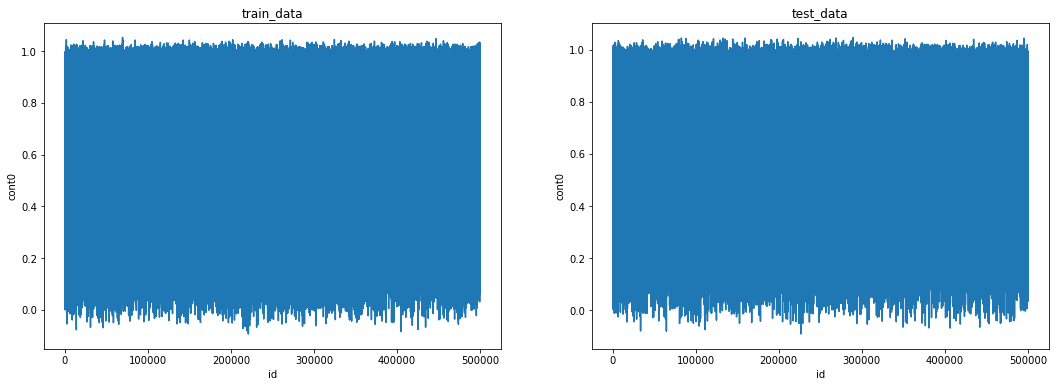

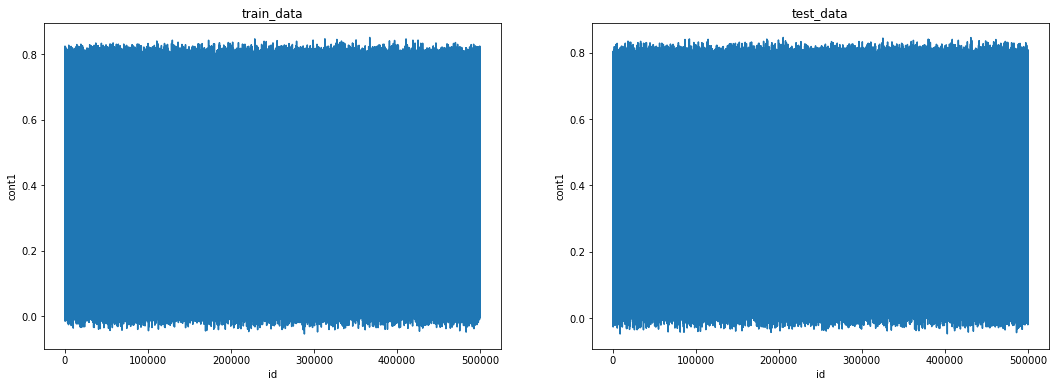

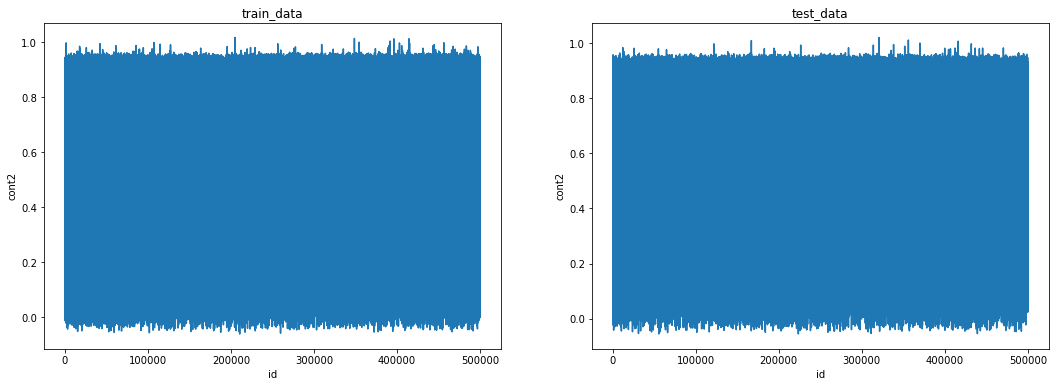

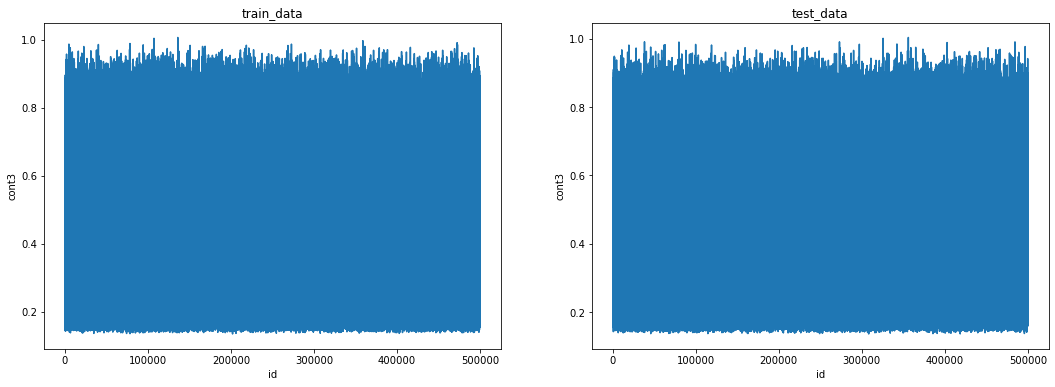

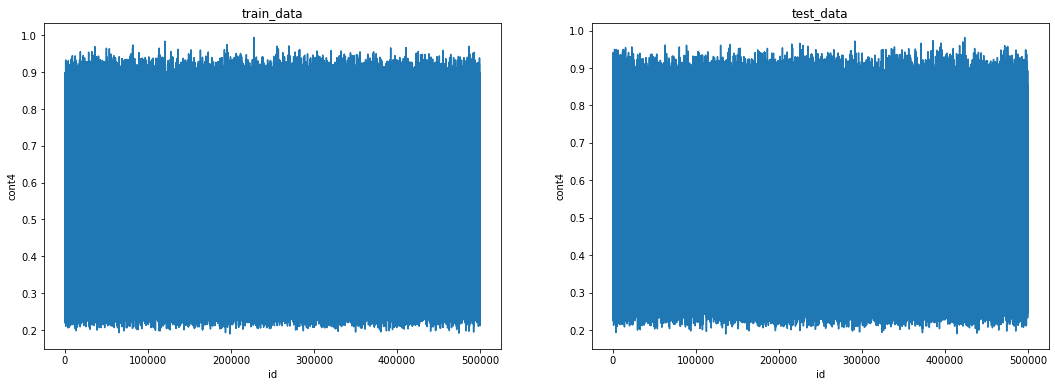

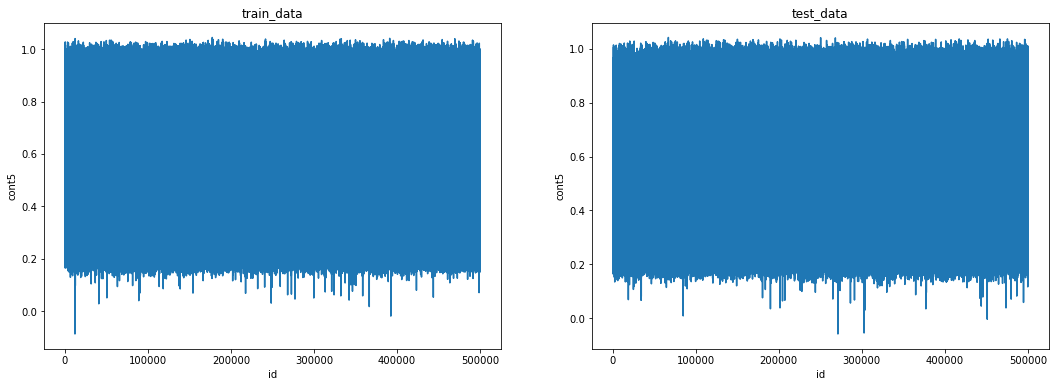

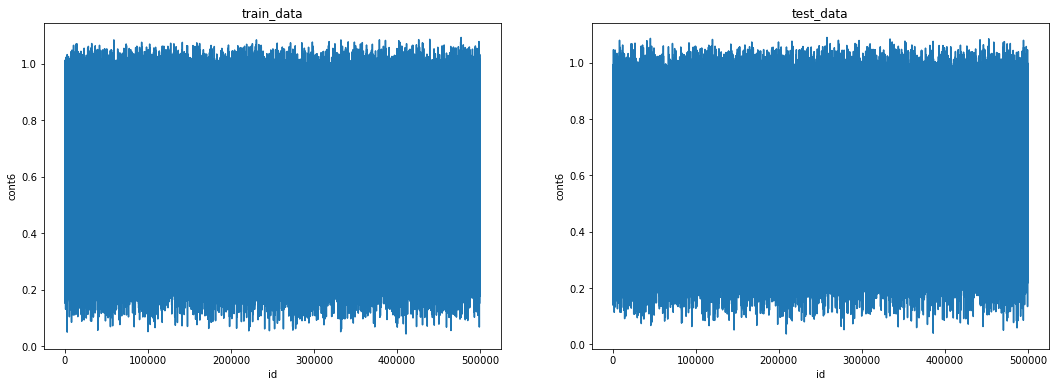

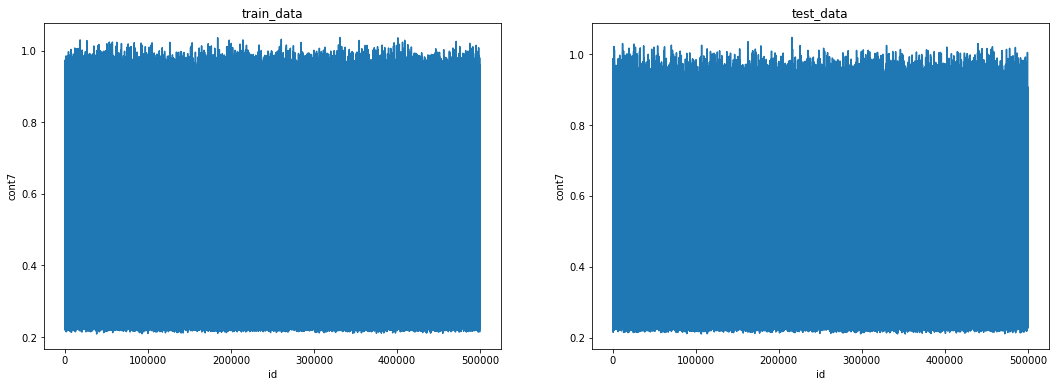

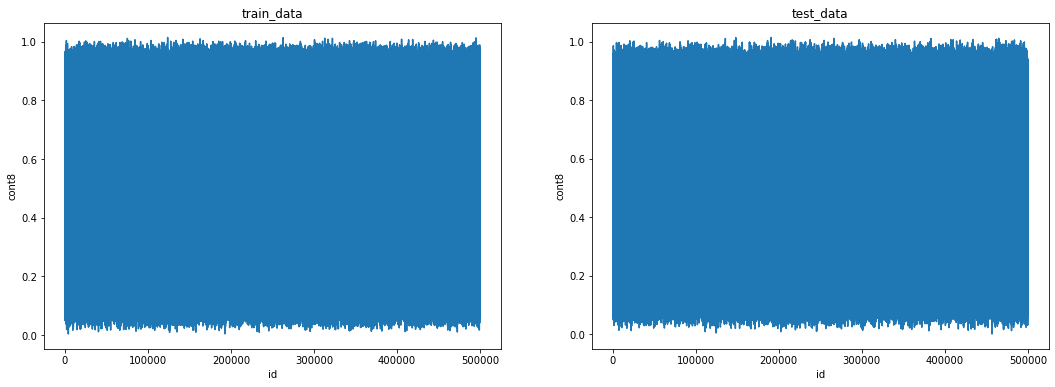

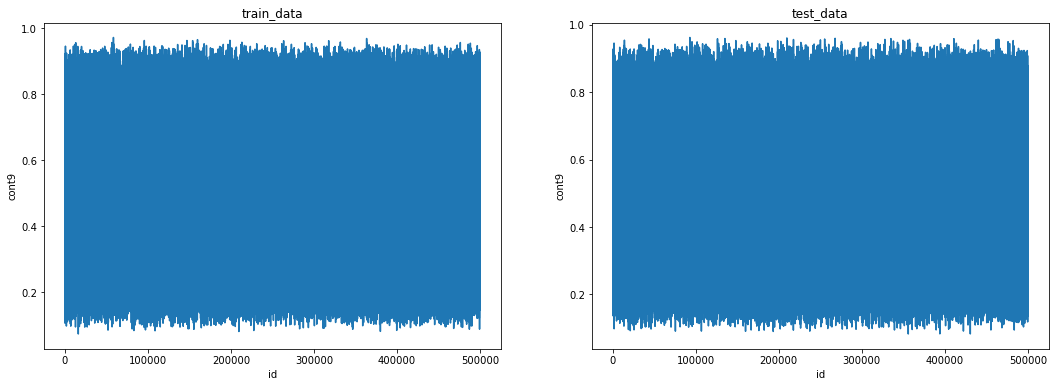

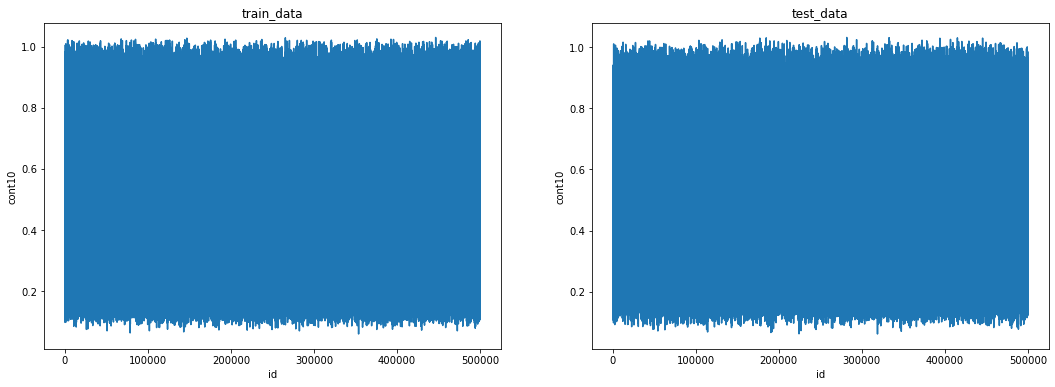

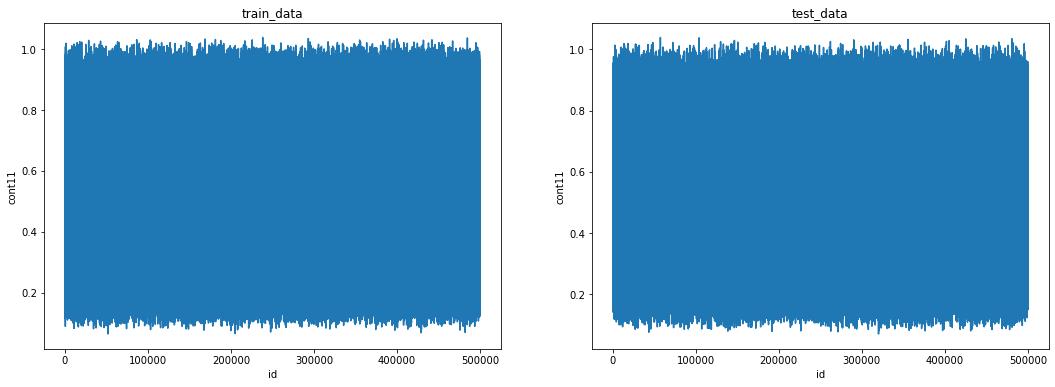

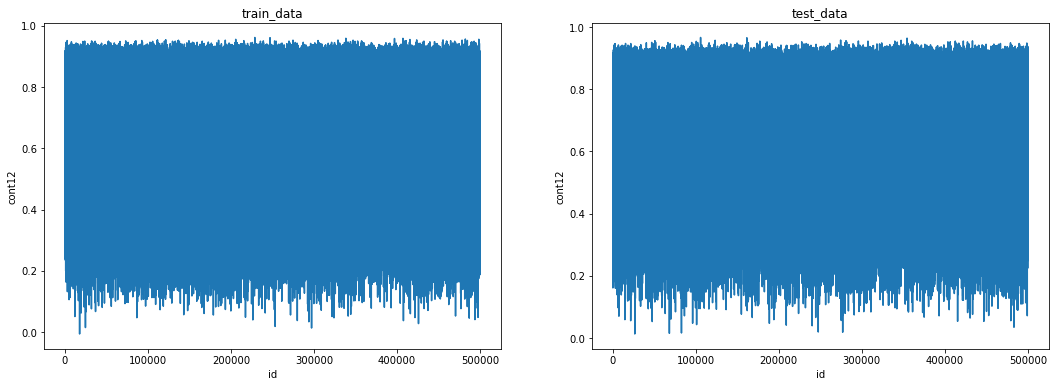

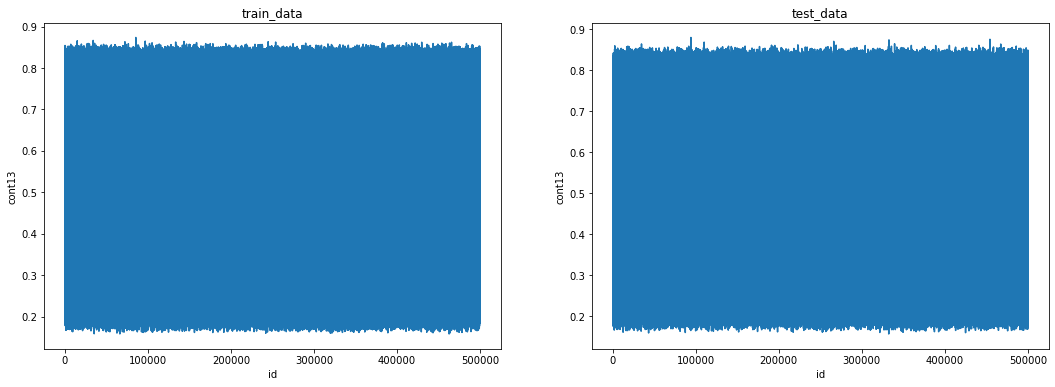

In [9]:
# Simple plots of the main features mainly to look for standout data weirdness 
for i in numerical_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    ax[0].plot(train["id"], train[i])
    ax[1].plot(test["id"], test[i])

    ax[0].set(xlabel="id", ylabel=i)
    ax[0].set_title('train_data')

    ax[1].set(xlabel="id", ylabel=i)
    ax[1].set_title("test_data")
    # I like to save the plots to look at in different porgrams the commented code below saves it
    #name ="./plots/" + i + "numplot.png"
    #plt.savefig(name)
    plt.show()

As these plots show the data is all very uniform without any crazy outliers. The only thing I picked up here are some negative values in the cont5 feature which is maybe worth investigating. 
Before that though some more plots. 

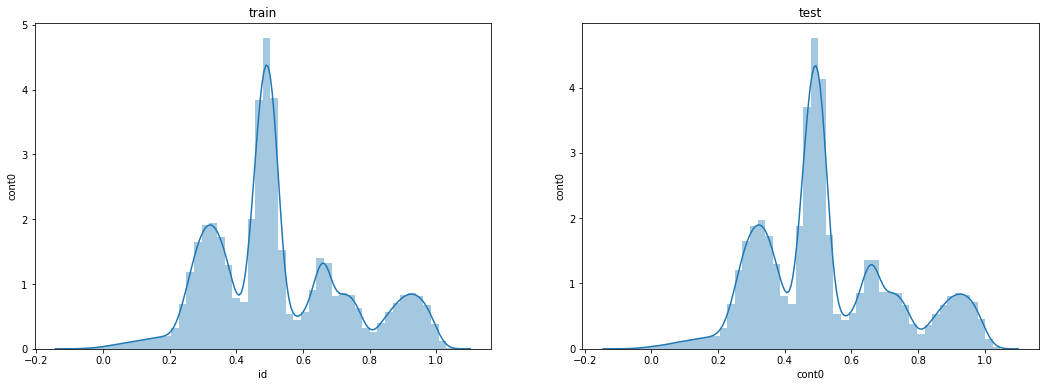

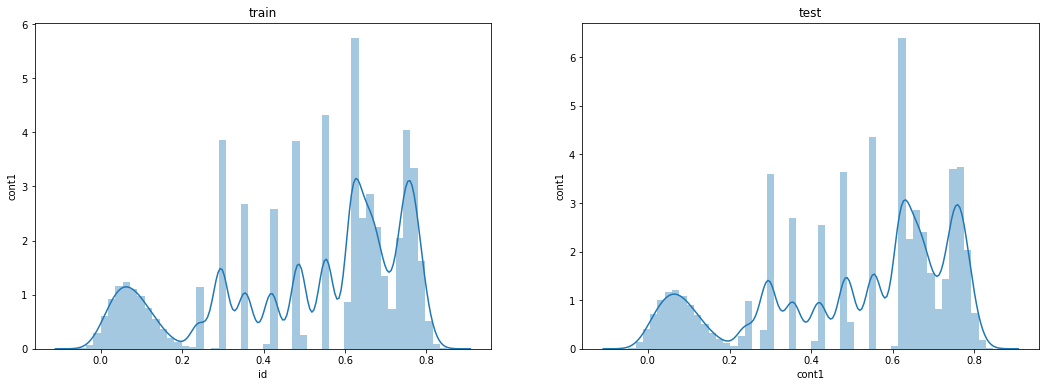

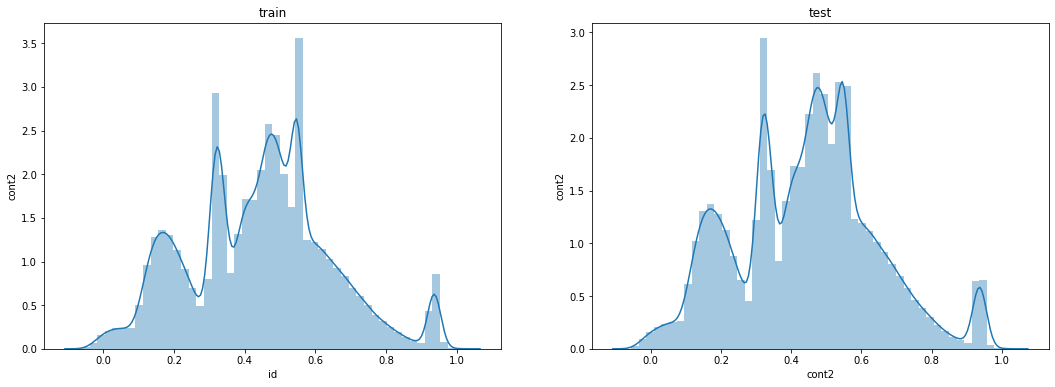

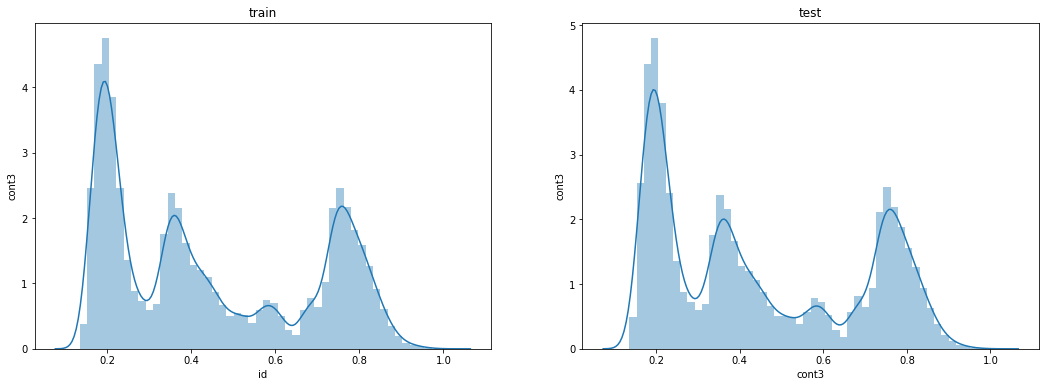

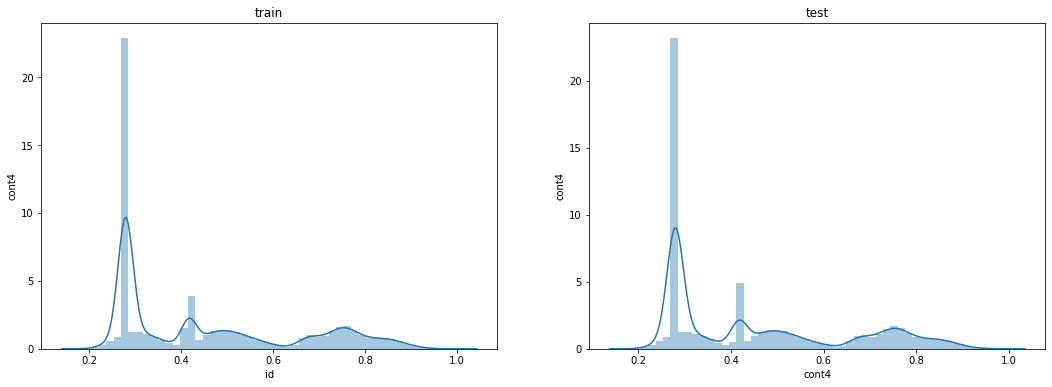

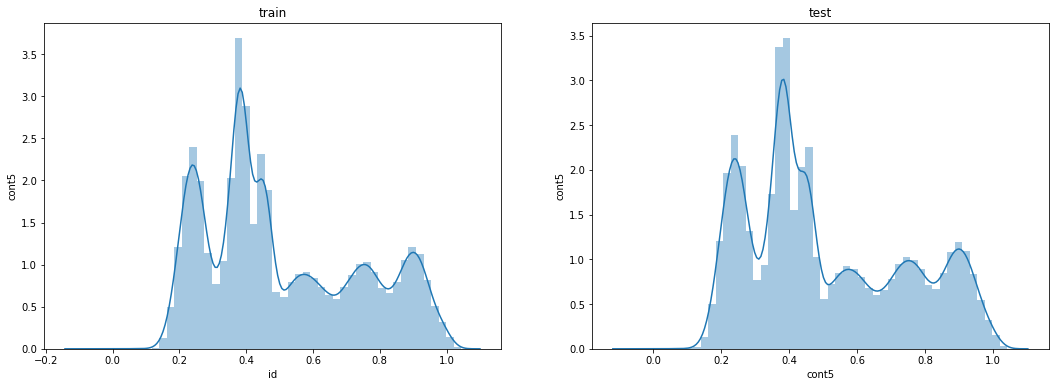

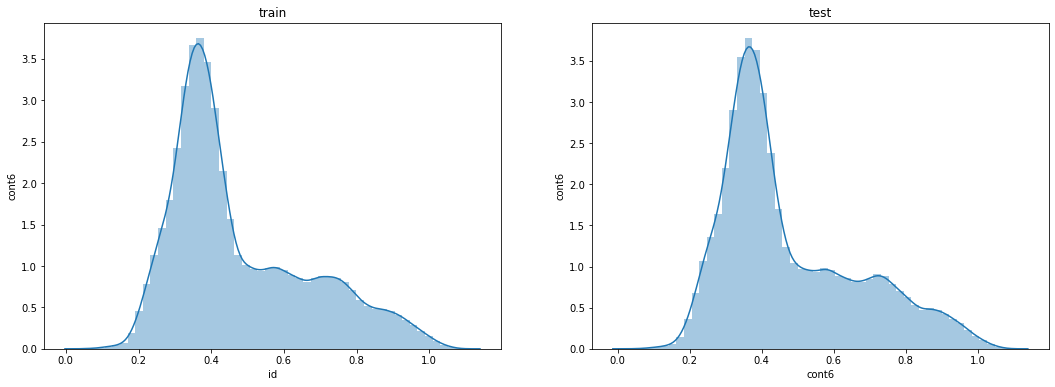

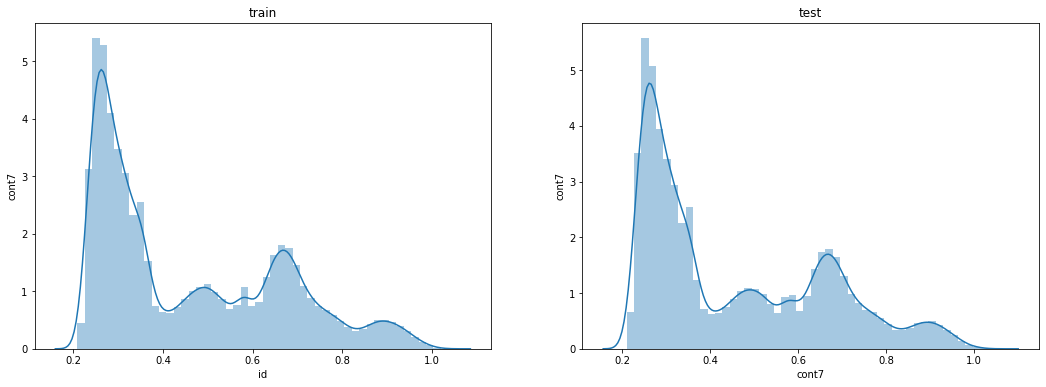

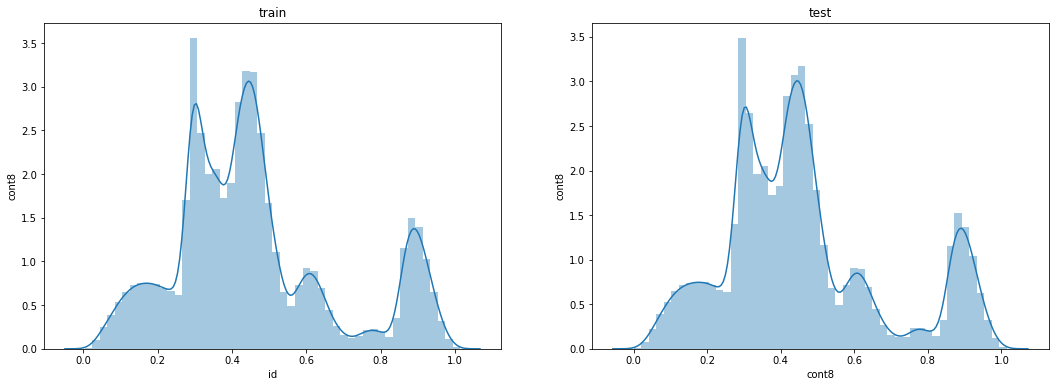

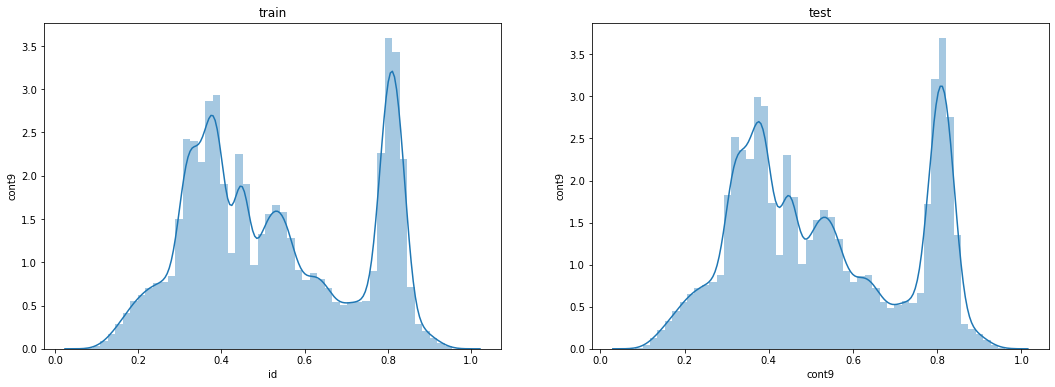

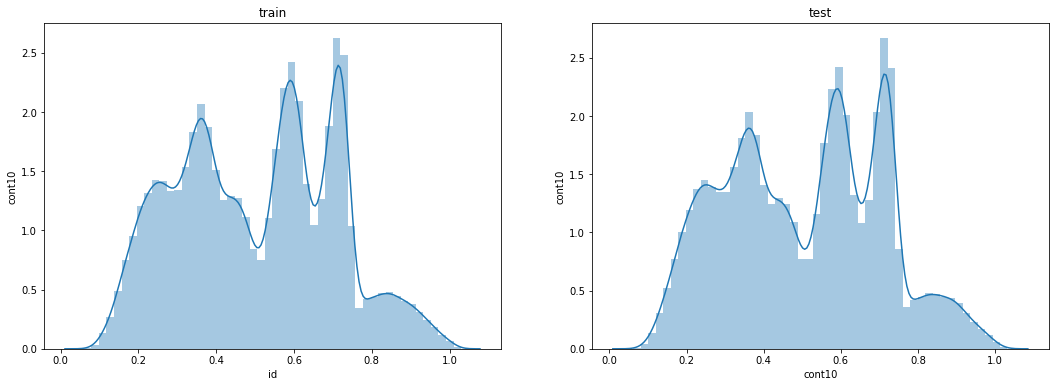

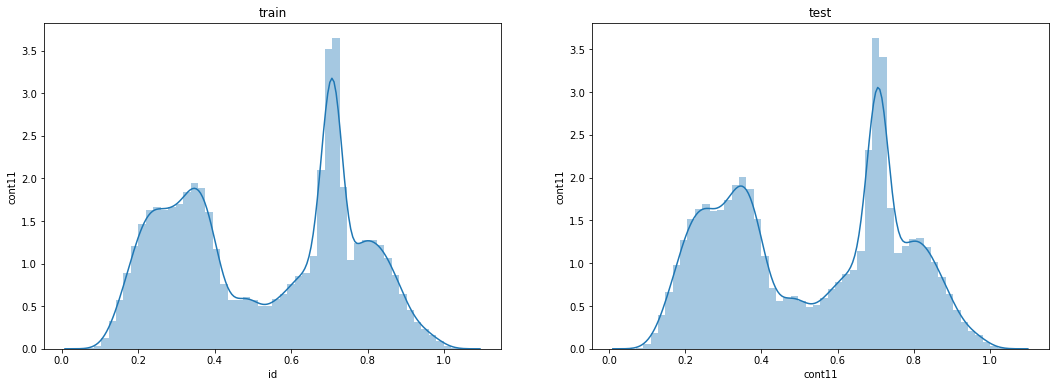

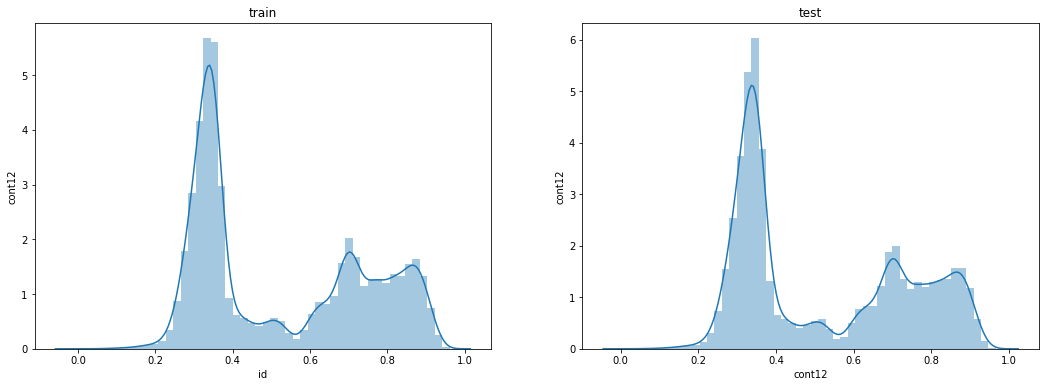

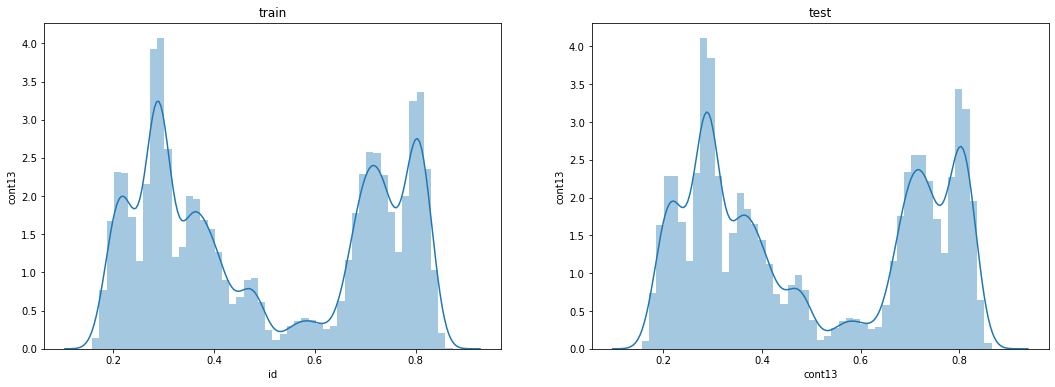

In [12]:
# Histograms of the numerical data. 
for i in numerical_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    sns.distplot(a=train[i], ax=ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train')

    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test")
    sns.distplot(a=test[i], ax=ax[1])
    #name ="./plots/" + i + "num_hist_plot.png"
    #plt.savefig(name)
    plt.show()

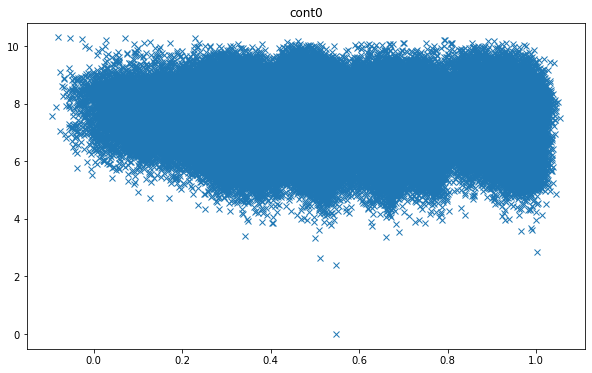

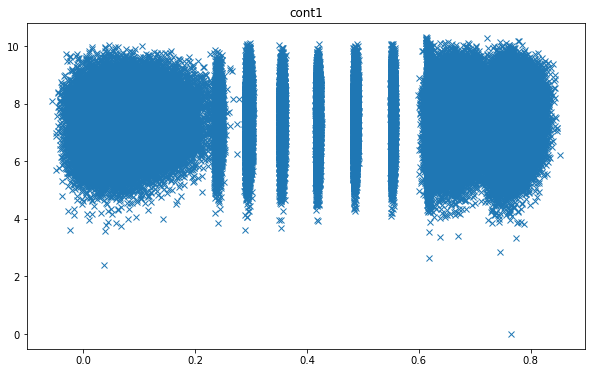

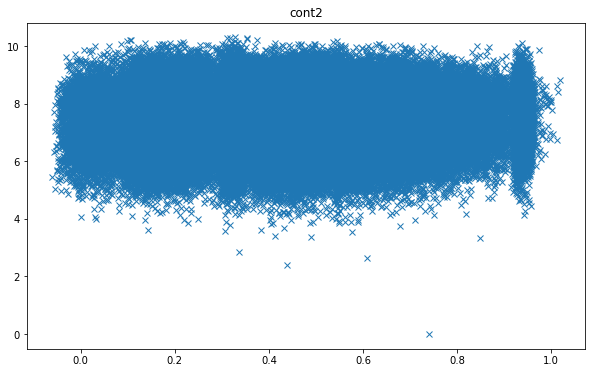

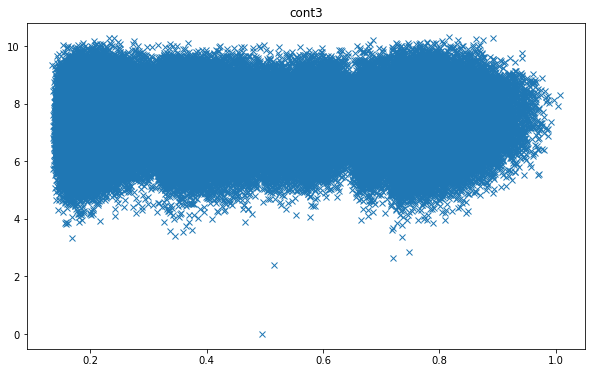

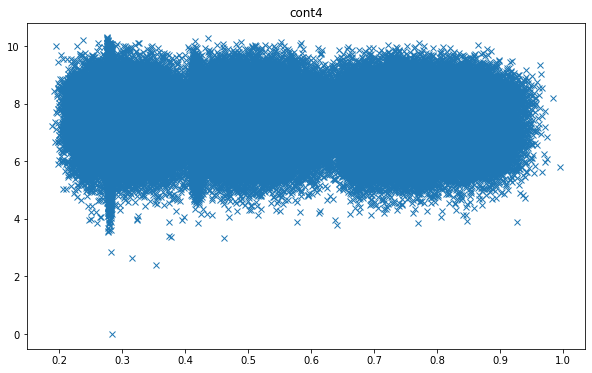

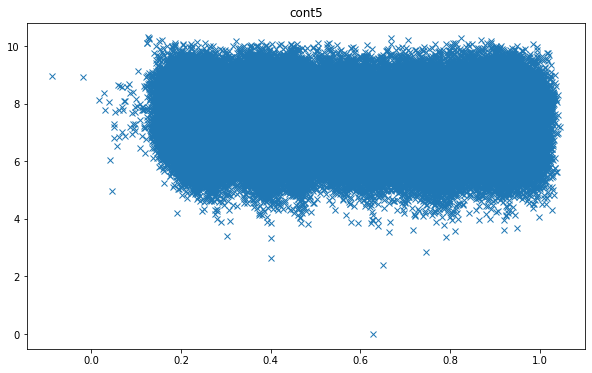

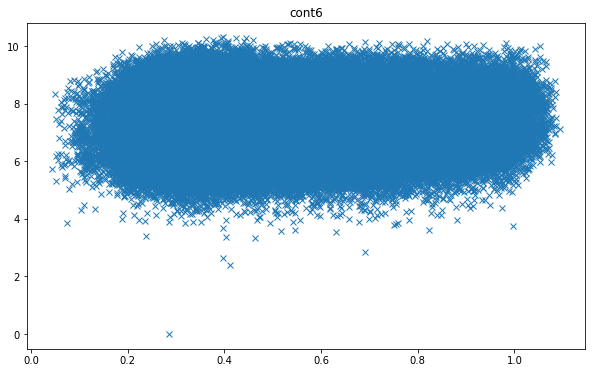

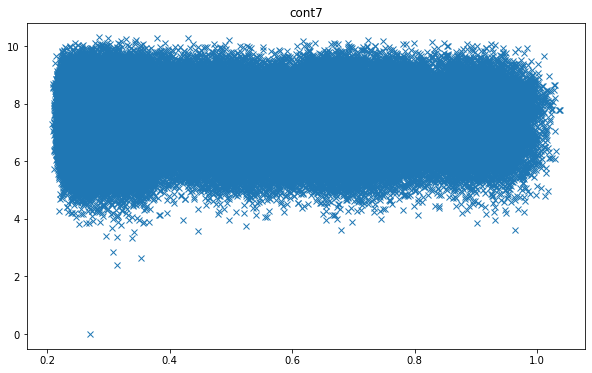

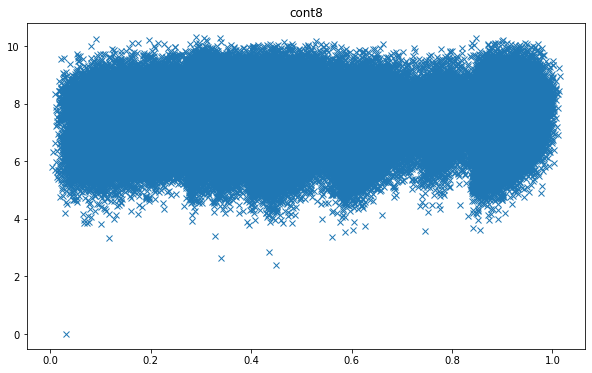

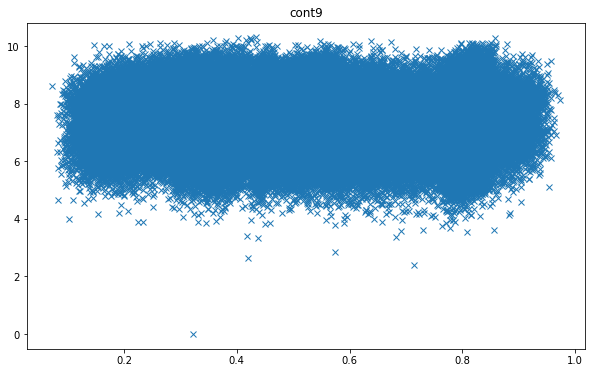

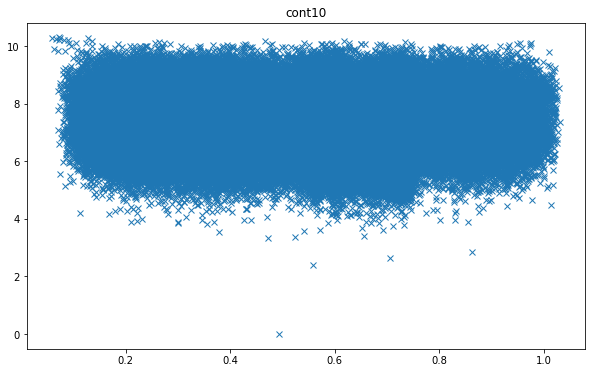

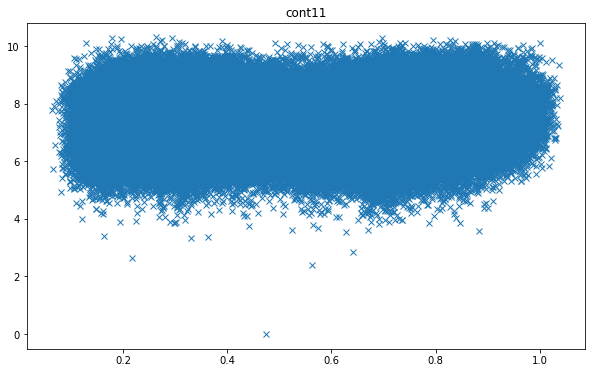

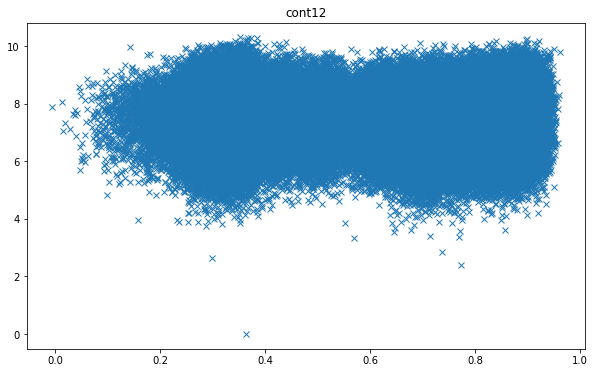

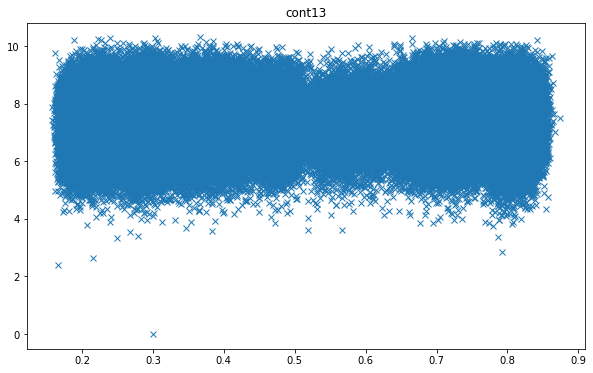

In [13]:
# Comparing the features to the traget 
for i in numerical_features:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train[i], train["target"], linestyle='', marker='x')
    plt.title(i)
    #name ="./plots/" +  i + "feature_vs_target_plot.png"
    #plt.savefig(name)
    plt.show()

### Now for plotting the catergorical data 

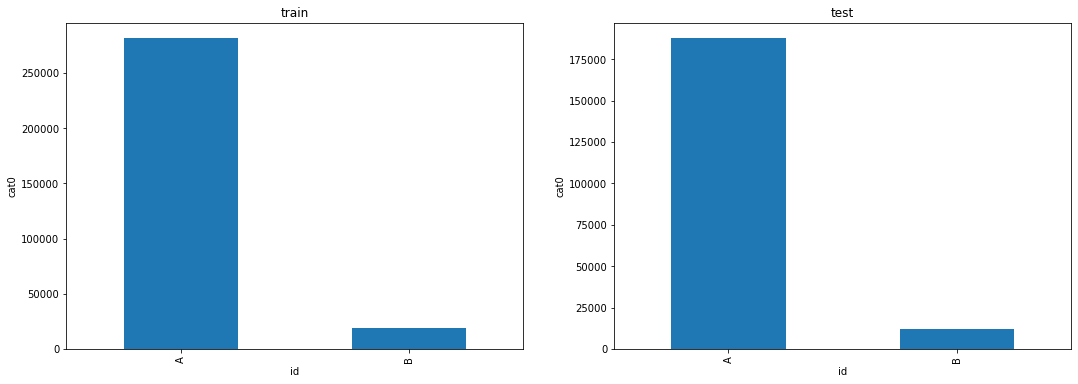

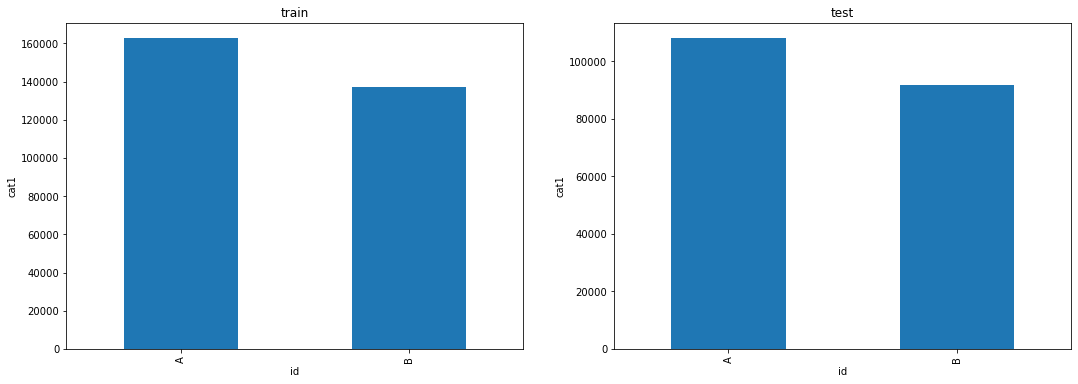

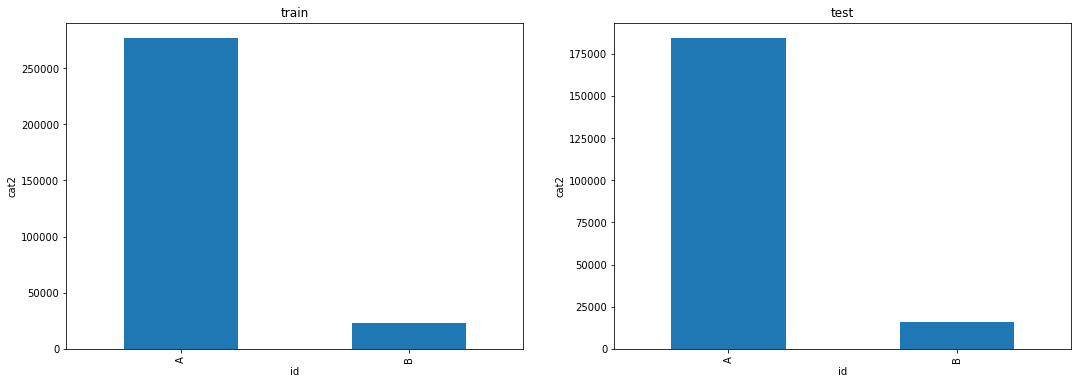

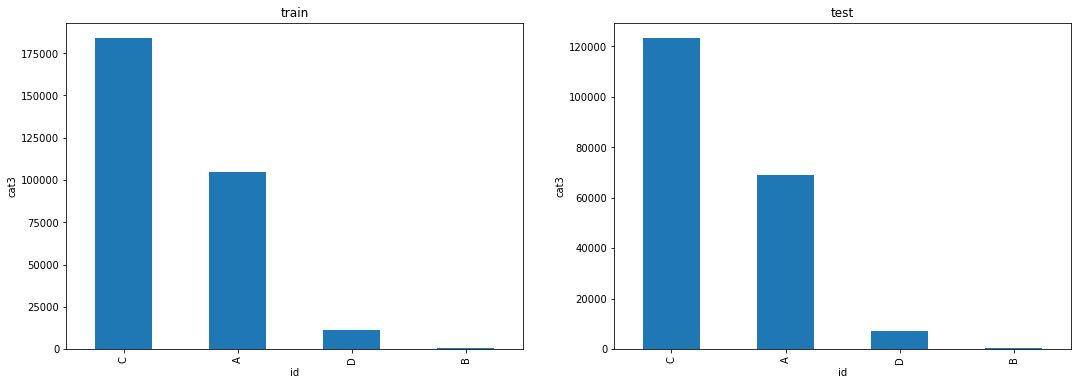

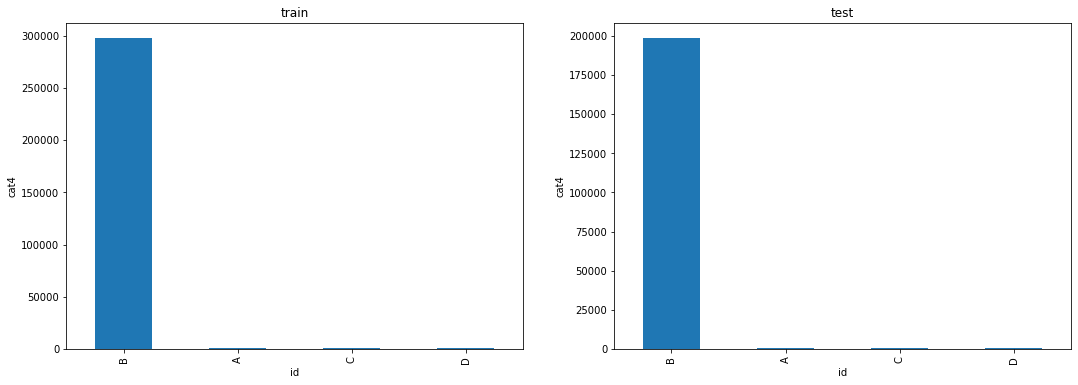

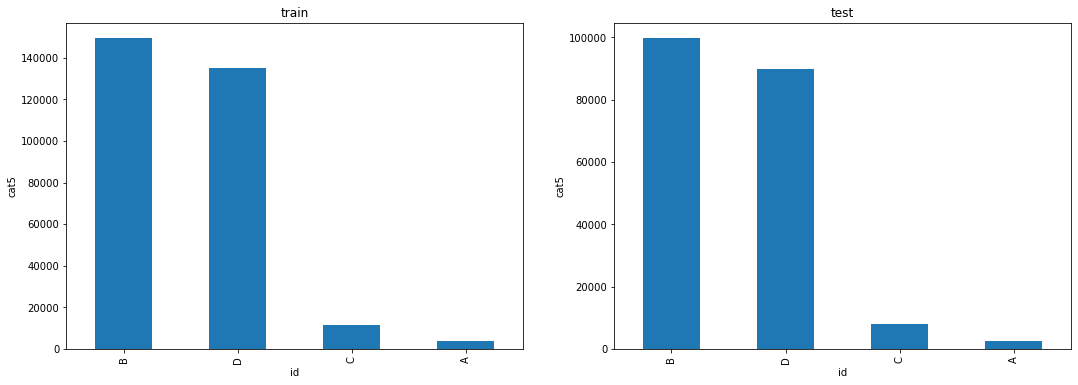

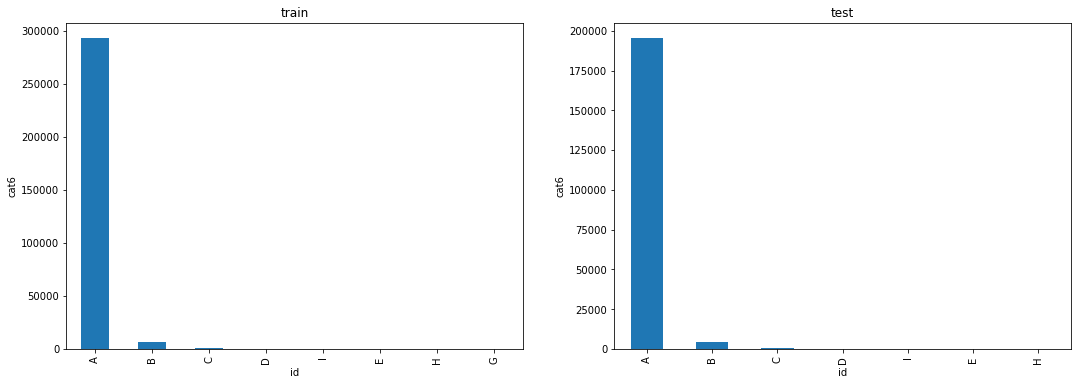

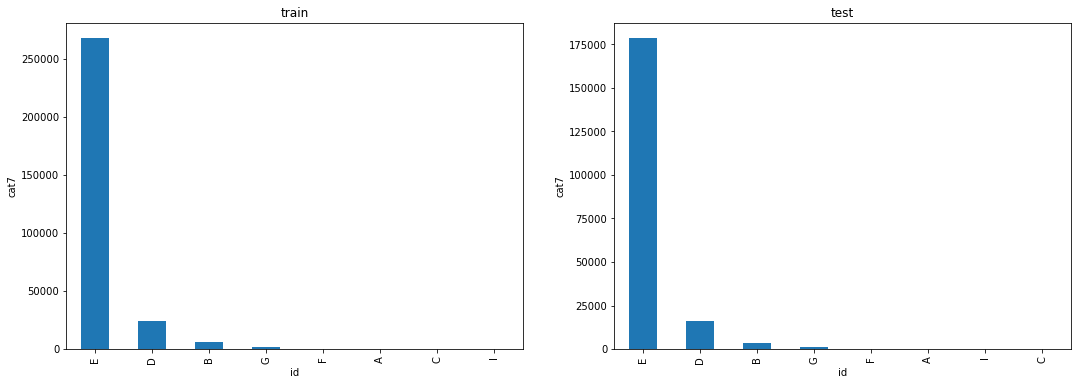

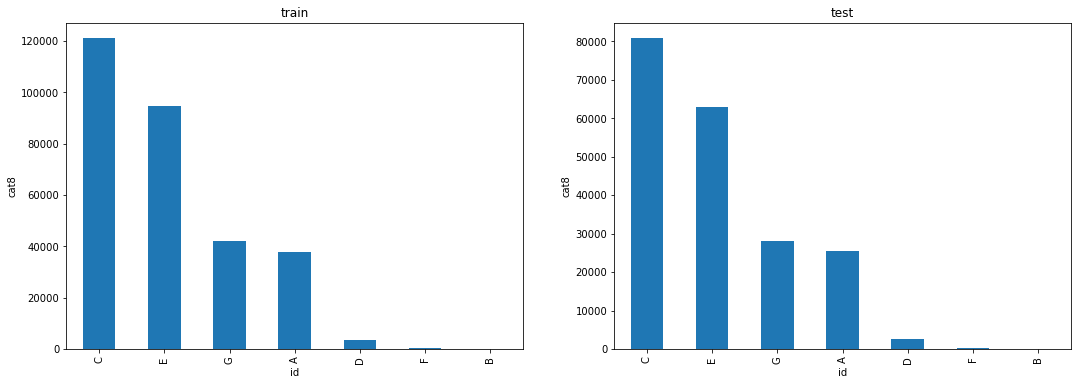

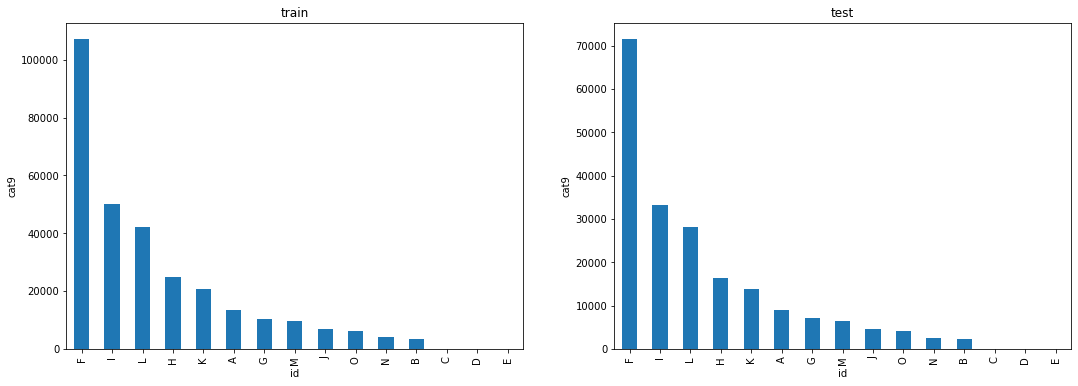

In [14]:
# bar plots of the categroies 
for i in cat_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    train[i].value_counts().plot(kind='bar', ax=ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train')

    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test")
    test[i].value_counts().plot(kind='bar', ax=ax[1])
    #name ="./plots/" + i + "cat_bar_plot.png"
    #plt.savefig(name)
    plt.show()

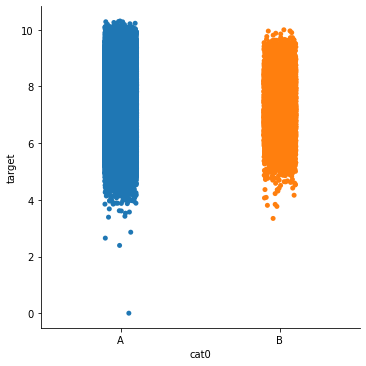

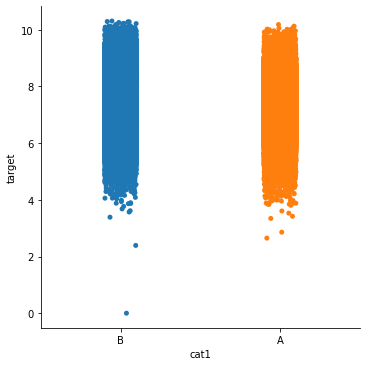

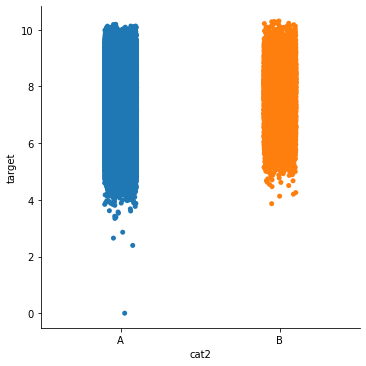

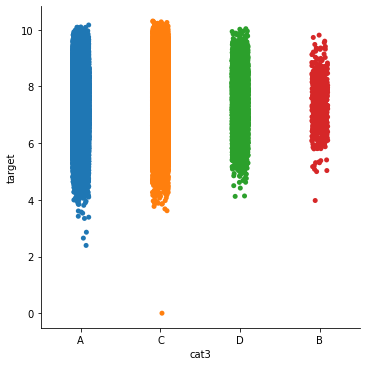

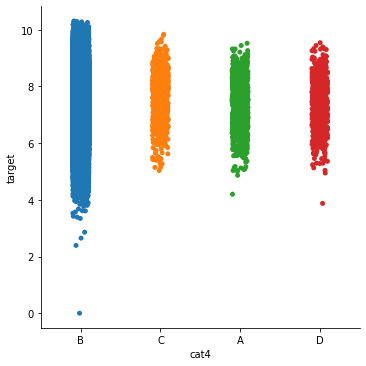

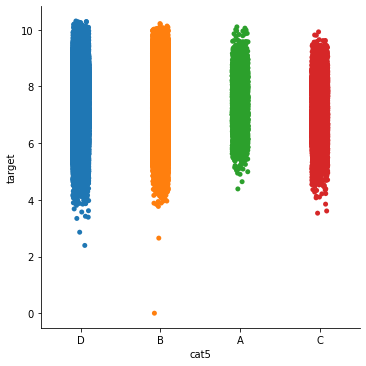

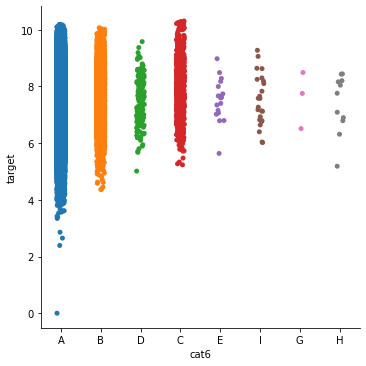

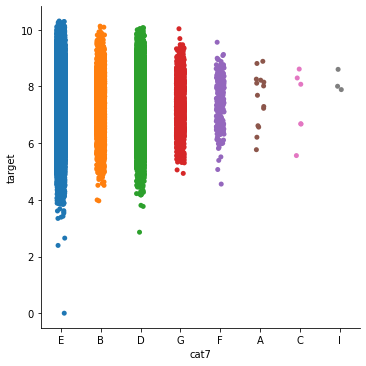

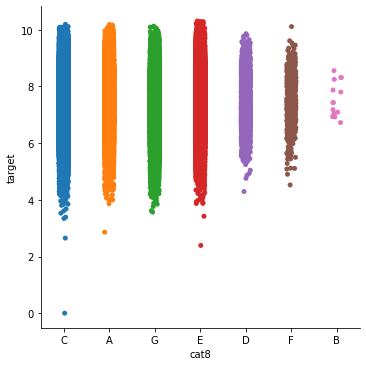

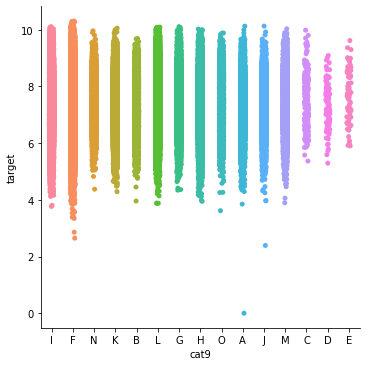

In [15]:
for i in cat_features:
    sns.catplot(x=i, y="target", data=train)
    #name ="./plots/" + i + "cat_plot.png"
    #plt.savefig(name)
    plt.show()

## Setting up to Train and Test Models
So now comes the leg work we have our data, and have removed an outlier, we should begin to train some models using kfold and then combine them for our submit. 

In [7]:
# Firstly we want to have a way of judging how long things are taking to run, the below method helps with this
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [16]:
def rmse(y_true, y_pred):
    """"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [17]:
# Now we are creating a class which holds the set up for the tree models we are using. 
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = None,
              cat_cols: list = None,
            ):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(
                X_train, label=y_train, cat_features=cat_cols)  #, group_id=[0] * len(X_train))
            self.val_data = Pool(
                X_val, label=y_val, cat_features=cat_cols)  #, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

In [18]:
# Now we cna set some basic parameters to use for the testing. 
ID_COL    = "id"
CAT_COLS  = cat_features #[f"cat{i}" for i in range(10)]
CONT_COLS = numerical_features #[f"cont{i}" for i in range(14)]
TGT_COL   = "target"

N_SPLITS  = 7 # Number of folds to use in the kfolds anaylsis 
RANDOM_SEED_LIST = [42]

Specifiy the parameters for each model to use. We may explore some sort of grid search later to tune these. I Have collected these params from the notebooks above and then tweaked them. 

In [29]:
MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "max_depth": 8,
        "learning_rate": 0.005,
        "colsample_bytree": 0.2,
        "subsample": 0.8,
        "subsample_freq": 6,
        "reg_alpha": 6.0,
        "min_data_in_leaf": 300,
        "max_leaves": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'tree_method': "hist",
        #"gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        "max_depth": 8,
        'learning_rate': 0.02,
        "colsample_bylevel": 0.4,
        "subsample": 0.6,
        "bagging_temperature": 6,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
#         "task_type": "GPU",
#         "devices" : "0",
        'num_boost_round': 20000,
        'grow_policy':'SymmetricTree',
        'od_type':'Iter', 
        'loss_function':'RMSE',
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 200,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  200,
    },
    "cat": {
        'early_stopping_rounds': 200,
        'verbose_eval': 200,
    }
}

## Feature Engineering 
At the moment I am doing nothing with the numerical features and using OrdinalEncoding for the catergorical features. 

In [20]:
#Make some new dataframes to use for encoding 
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()
#Encode the categories 
ord_enc = ce.OrdinalEncoder(cols=CAT_COLS)
train_cat_feat = ord_enc.fit_transform(train[CAT_COLS])
test_cat_feat = ord_enc.transform(test[CAT_COLS])
#Bring the dataframes back together 
train_feat = pd.concat([train_feat, train_cat_feat], axis=1)
test_feat = pd.concat([test_feat, test_cat_feat], axis=1)
use_feat_cols.extend(train_cat_feat.columns)

In [21]:
# Same process with the numerical 
train_cont_feat = train[CONT_COLS]
test_cont_feat = test[CONT_COLS]

train_feat = pd.concat([train_feat, train_cont_feat], axis=1)
test_feat = pd.concat([test_feat, test_cont_feat], axis=1)
use_feat_cols.extend(CONT_COLS)

In [10]:
# Check the dataframes
train_feat.head().T

0         1         2         3         4
id      1.000000  2.000000  3.000000  4.000000  6.000000
cat0    1.000000  2.000000  1.000000  1.000000  1.000000
cat1    1.000000  2.000000  2.000000  2.000000  1.000000
cat2    1.000000  1.000000  1.000000  1.000000  1.000000
cat3    1.000000  1.000000  2.000000  2.000000  1.000000
cat4    1.000000  1.000000  1.000000  1.000000  1.000000
cat5    1.000000  2.000000  1.000000  1.000000  2.000000
cat6    1.000000  1.000000  1.000000  1.000000  1.000000
cat7    1.000000  1.000000  2.000000  1.000000  1.000000
cat8    1.000000  2.000000  1.000000  3.000000  1.000000
cat9    1.000000  2.000000  3.000000  4.000000  2.000000
cont0   0.923191  0.437627  0.732209  0.705142  0.486063
cont1   0.684968  0.014213  0.760122  0.771678  0.639349
cont2   0.124454  0.357438  0.454644  0.153735  0.496212
cont3   0.217886  0.846127  0.812990  0.732893  0.354186
cont4   0.281421  0.282354  0.293756  0.769785  0.279105
cont5   0.881122  0.440011  0.914155  0.934138  0.382600
cont6   0.421650  0.346230  0.369602  0.578930  0.705940
cont7   0.741413  0.278495  0.832564  0.407313  0.325193
cont8   0.895799  0.593413  0.865620  0.868099  0.440967
cont9   0.802461  0.546056  0.825251  0.794402  0.462146
cont10  0.724417  0.613252  0.264104  0.494269  0.724447
cont11  0.701915  0.741289  0.695561  0.698125  0.683073
cont12  0.877618  0.326679  0.869133  0.809799  0.343457
cont13  0.719903  0.808464  0.828352  0.614766  0.297743

In [11]:
# Check test dataframe 
test_feat.head().T

0         1          2          3          4
id      0.000000  5.000000  15.000000  16.000000  17.000000
cat0    1.000000  1.000000   1.000000   1.000000   1.000000
cat1    1.000000  1.000000   1.000000   2.000000   1.000000
cat2    1.000000  1.000000   1.000000   2.000000   1.000000
cat3    2.000000  2.000000   2.000000   1.000000   1.000000
cat4    1.000000  1.000000   1.000000   1.000000   1.000000
cat5    1.000000  1.000000   1.000000   1.000000   2.000000
cat6    1.000000  1.000000   1.000000   1.000000   1.000000
cat7    1.000000  1.000000   1.000000   1.000000   1.000000
cat8    4.000000  1.000000   1.000000   4.000000   4.000000
cat9    7.000000  6.000000   2.000000   2.000000   1.000000
cont0   0.331261  0.402404   0.530677   0.439653   0.389844
cont1   0.551131  0.617546   0.618126   0.487403   0.752760
cont2   0.486284  0.296852   0.760865   0.715786   0.315269
cont3   0.156058  0.187440   0.199872   0.192808   0.191734
cont4   0.701679  0.277480   0.279508   0.479503   0.757845
cont5   0.595507  0.479552   0.676395   0.759875   0.210232
cont6   0.286912  0.397436   0.695284   0.240049   0.329851
cont7   0.279884  0.476742   0.253316   0.298074   0.616663
cont8   0.202234  0.857073   0.586934   0.442475   0.170475
cont9   0.242654  0.516393   0.548555   0.596746   0.263235
cont10  0.285147  0.562065   0.836193   0.414131   0.710961
cont11  0.264308  0.730542   0.759788   0.255382   0.224045
cont12  0.653654  0.318492   0.333572   0.589080   0.285860
cont13  0.302448  0.736251   0.273905   0.311625   0.794931

In [22]:
# Create a function to do our training 
def run_train_and_inference(X, X_test, y, use_model, model_params, 
                            train_params, seed_list, n_splits, cat_cols=None):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params, cat_cols=cat_cols
                )
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances


In [23]:
# Make our train test split 
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (300000, 24), test_feat: (200000, 24)


## Now Start Training 
### LightGBM

In [24]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 257142, number of used features: 24
[LightGBM] [Info] Start training from score 7.456568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	training's rmse: 0.859865	valid_1's rmse: 0.864895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1200]	training's rmse: 0.840448	valid_1's rmse: 0.849716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3800]	training's rmse: 0.821514	valid_1's rmse: 0.843719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model training146.144[s]
score: 0.84333
****************************************************************************************************
Seed: 42 - Fold: 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3635
[LightGBM] [Info] Number of data points in the train set: 257143, number of used features: 24
[LightGBM] [Info] Start training from score 7.457883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	training's rmse: 0.852955	valid_1's rmse: 0.8559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2200]	training's rmse: 0.830909	valid_1's rmse: 0.843049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2400]	training's rmse: 0.82953	valid_1's rmse: 0.842657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2600]	training's rmse: 0.828263	valid_1's rmse: 0.842388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	training's rmse: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	training's rmse: 0.822812	valid_1's rmse: 0.841632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	training's rmse: 0.81693	valid_1's rmse: 0.841318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	training's rmse: 0.832277	valid_1's rmse: 0.844696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2600]	training's rmse: 0.828145	valid_1's rmse: 0.843504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2800]	training's rmse: 0.826921	valid_1's rmse: 0.843208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	training's rmse: 0.8227	valid_1's rmse: 0.842448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4600]	training's rmse: 0.818272	valid_1's rmse: 0.841996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	training's rmse: 0.816753	valid_1's rmse: 0.841911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5400]	training's rmse: 0.815178	valid_1's rmse: 0.841861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5800]	training's rmse: 0.813619	valid_1's rmse: 0.841823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6200]	training's rmse: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6600]	training's rmse: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	training's rmse: 0.860304	valid_1's rmse: 0.861654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1200]	training's rmse: 0.840772	valid_1's rmse: 0.847289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	training's rmse: 0.834149	valid_1's rmse: 0.844226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3800]	training's rmse: 0.821812	valid_1's rmse: 0.841536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[4200]	training's rmse: 0.820082	valid_1's rmse: 0.841371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	training's rmse: 0.848033	valid_1's rmse: 0.849984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	training's rmse: 0.838543	valid_1's rmse: 0.843908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	training's rmse: 0

[2200]	training's rmse: 0.831169	valid_1's rmse: 0.840973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2400]	training's rmse: 0.829804	valid_1's rmse: 0.840596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2600]	training's rmse: 0.828533	valid_1's rmse: 0.840303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3200]	training's rmse: 0.824418	valid_1's rmse: 0.843304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4800]	training's rmse: 0.817333	valid_1's rmse: 0.842717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5200]	training's rmse: 0.815816	valid_1's rmse: 0.842693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5600]	training's rmse: 0.814277	valid_1's rmse: 0.842674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [25]:
# Print our results 
score_lgb

seed fold  rmse score
0   42    0    0.843329
1   42    1    0.841287
2   42    2    0.845003
3   42    3    0.841762
4   42    4    0.841085
5   42    5    0.839039
6   42    6    0.842659
7   42  oof    0.842025
8  avg  oof    0.842025

In [26]:
score_lgb.loc[score_lgb.fold == "oof"]

seed fold  rmse score
7   42  oof    0.842025
8  avg  oof    0.842025

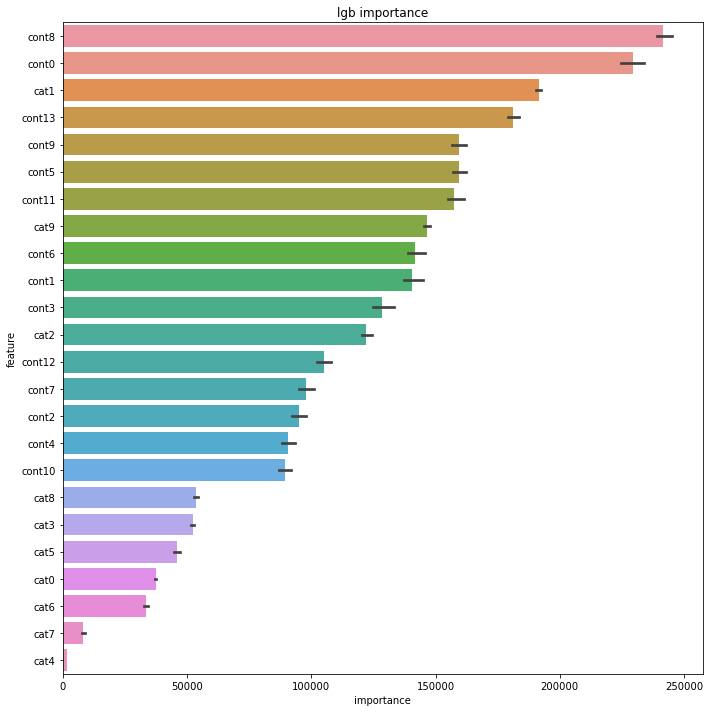

In [27]:
#Plot the featuires by importance as discovered by the model. 
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [30]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[1]	train-rmse:6.87553	val-rmse:6.87380
[2]	train-rmse:6.80792	val-rmse:6.80619
[3]	train-rmse:6.74098	val-rmse:6.73923
[4]	train-rmse:6.67476	val-rmse:6.67300
[5]	train-rmse:6.60916	val-rmse:6.60742
[6]	train-rmse:6.54423	val-rmse:6.54251
[7]	train-rmse:6.48000	val-rmse:6.47825
[8]	train-rmse:6.41642	val-rmse:6.41469
[9]	train-rmse:6.35349	val-rmse:6.35175
[10]	train-rmse:6.29113	val-rmse:6.28942
[11]	train-rmse:6.22947	val-rmse:6.22774
[12]	train-rmse:6.16843	val-rmse:6.16669
[13]	train-rmse:6.10801	val-rmse:6.10627
[14]	train-rmse:6.04818	val-rmse:6.04647
[15]	train-rmse:5.98901	val-rmse:5.98727
[16]	train-rmse:5.93044	val-rmse:5.92868
[17]	train-rmse:5.87238	val-rmse:5.87065
[18]	train-rmse:5.81499	val-rmse:5.81325
[19]	train-rmse:5.75817	val-rmse:5.75644
[20]	train-rmse:5.70194	val-rmse:5.70019
[21]	train-rmse:5.64627	val-rmse:5.64453
[22]	train-rmse:5.59115	val-

[196]	train-rmse:1.29219	val-rmse:1.29229
[197]	train-rmse:1.28502	val-rmse:1.28514
[198]	train-rmse:1.27794	val-rmse:1.27808
[199]	train-rmse:1.27097	val-rmse:1.27114
[201]	train-rmse:1.25731	val-rmse:1.25752
[202]	train-rmse:1.25063	val-rmse:1.25087
[203]	train-rmse:1.24406	val-rmse:1.24431
[204]	train-rmse:1.23757	val-rmse:1.23785
[205]	train-rmse:1.23118	val-rmse:1.23148
[206]	train-rmse:1.22489	val-rmse:1.22521
[207]	train-rmse:1.21870	val-rmse:1.21903
[208]	train-rmse:1.21258	val-rmse:1.21294
[209]	train-rmse:1.20654	val-rmse:1.20692
[210]	train-rmse:1.20060	val-rmse:1.20101
[211]	train-rmse:1.19475	val-rmse:1.19518
[212]	train-rmse:1.18900	val-rmse:1.18945
[213]	train-rmse:1.18333	val-rmse:1.18380
[214]	train-rmse:1.17776	val-rmse:1.17826
[215]	train-rmse:1.17226	val-rmse:1.17278
[216]	train-rmse:1.16684	val-rmse:1.16737
[217]	train-rmse:1.16150	val-rmse:1.16206
[218]	train-rmse:1.15626	val-rmse:1.15684
[219]	train-rmse:1.15109	val-rmse:1.15169
[220]	train-rmse:1.14600	val-rmse:

[393]	train-rmse:0.86311	val-rmse:0.86664
[394]	train-rmse:0.86286	val-rmse:0.86641
[395]	train-rmse:0.86262	val-rmse:0.86619
[396]	train-rmse:0.86239	val-rmse:0.86596
[397]	train-rmse:0.86215	val-rmse:0.86573
[398]	train-rmse:0.86191	val-rmse:0.86552
[399]	train-rmse:0.86169	val-rmse:0.86530
[401]	train-rmse:0.86126	val-rmse:0.86489
[402]	train-rmse:0.86103	val-rmse:0.86468
[403]	train-rmse:0.86081	val-rmse:0.86447
[404]	train-rmse:0.86061	val-rmse:0.86427
[405]	train-rmse:0.86040	val-rmse:0.86408
[406]	train-rmse:0.86021	val-rmse:0.86390
[407]	train-rmse:0.86002	val-rmse:0.86372
[408]	train-rmse:0.85981	val-rmse:0.86352
[409]	train-rmse:0.85963	val-rmse:0.86335
[410]	train-rmse:0.85944	val-rmse:0.86318
[411]	train-rmse:0.85926	val-rmse:0.86301
[412]	train-rmse:0.85908	val-rmse:0.86284
[413]	train-rmse:0.85889	val-rmse:0.86266
[414]	train-rmse:0.85871	val-rmse:0.86249
[415]	train-rmse:0.85854	val-rmse:0.86233
[416]	train-rmse:0.85837	val-rmse:0.86217
[417]	train-rmse:0.85821	val-rmse:

[590]	train-rmse:0.84688	val-rmse:0.85228
[591]	train-rmse:0.84686	val-rmse:0.85227
[592]	train-rmse:0.84681	val-rmse:0.85223
[593]	train-rmse:0.84678	val-rmse:0.85221
[594]	train-rmse:0.84675	val-rmse:0.85219
[595]	train-rmse:0.84673	val-rmse:0.85218
[596]	train-rmse:0.84671	val-rmse:0.85215
[597]	train-rmse:0.84669	val-rmse:0.85214
[598]	train-rmse:0.84665	val-rmse:0.85211
[599]	train-rmse:0.84663	val-rmse:0.85210
[601]	train-rmse:0.84657	val-rmse:0.85206
[602]	train-rmse:0.84655	val-rmse:0.85204
[603]	train-rmse:0.84652	val-rmse:0.85202
[604]	train-rmse:0.84649	val-rmse:0.85200
[605]	train-rmse:0.84646	val-rmse:0.85198
[606]	train-rmse:0.84645	val-rmse:0.85197
[607]	train-rmse:0.84643	val-rmse:0.85195
[608]	train-rmse:0.84638	val-rmse:0.85192
[609]	train-rmse:0.84636	val-rmse:0.85190
[610]	train-rmse:0.84632	val-rmse:0.85187
[611]	train-rmse:0.84629	val-rmse:0.85185
[612]	train-rmse:0.84626	val-rmse:0.85182
[613]	train-rmse:0.84623	val-rmse:0.85180
[614]	train-rmse:0.84620	val-rmse:

[787]	train-rmse:0.84257	val-rmse:0.84948
[788]	train-rmse:0.84254	val-rmse:0.84947
[789]	train-rmse:0.84252	val-rmse:0.84945
[790]	train-rmse:0.84250	val-rmse:0.84944
[791]	train-rmse:0.84249	val-rmse:0.84943
[792]	train-rmse:0.84247	val-rmse:0.84942
[793]	train-rmse:0.84245	val-rmse:0.84940
[794]	train-rmse:0.84244	val-rmse:0.84939
[795]	train-rmse:0.84242	val-rmse:0.84939
[796]	train-rmse:0.84240	val-rmse:0.84937
[797]	train-rmse:0.84238	val-rmse:0.84935
[798]	train-rmse:0.84236	val-rmse:0.84933
[799]	train-rmse:0.84234	val-rmse:0.84932
[801]	train-rmse:0.84231	val-rmse:0.84931
[802]	train-rmse:0.84229	val-rmse:0.84930
[803]	train-rmse:0.84227	val-rmse:0.84929
[804]	train-rmse:0.84225	val-rmse:0.84927
[805]	train-rmse:0.84223	val-rmse:0.84926
[806]	train-rmse:0.84221	val-rmse:0.84924
[807]	train-rmse:0.84220	val-rmse:0.84923
[808]	train-rmse:0.84218	val-rmse:0.84923
[809]	train-rmse:0.84217	val-rmse:0.84922
[810]	train-rmse:0.84215	val-rmse:0.84921
[811]	train-rmse:0.84214	val-rmse:

[984]	train-rmse:0.83946	val-rmse:0.84783
[985]	train-rmse:0.83944	val-rmse:0.84782
[986]	train-rmse:0.83943	val-rmse:0.84782
[987]	train-rmse:0.83942	val-rmse:0.84781
[988]	train-rmse:0.83940	val-rmse:0.84780
[989]	train-rmse:0.83940	val-rmse:0.84780
[990]	train-rmse:0.83939	val-rmse:0.84780
[991]	train-rmse:0.83938	val-rmse:0.84779
[992]	train-rmse:0.83937	val-rmse:0.84779
[993]	train-rmse:0.83935	val-rmse:0.84778
[994]	train-rmse:0.83934	val-rmse:0.84778
[995]	train-rmse:0.83932	val-rmse:0.84777
[996]	train-rmse:0.83930	val-rmse:0.84776
[997]	train-rmse:0.83929	val-rmse:0.84775
[998]	train-rmse:0.83928	val-rmse:0.84774
[999]	train-rmse:0.83926	val-rmse:0.84773
[1001]	train-rmse:0.83923	val-rmse:0.84772
[1002]	train-rmse:0.83922	val-rmse:0.84771
[1003]	train-rmse:0.83921	val-rmse:0.84771
[1004]	train-rmse:0.83920	val-rmse:0.84771
[1005]	train-rmse:0.83918	val-rmse:0.84769
[1006]	train-rmse:0.83916	val-rmse:0.84768
[1007]	train-rmse:0.83915	val-rmse:0.84768
[1008]	train-rmse:0.83914	v

[1176]	train-rmse:0.83696	val-rmse:0.84667
[1177]	train-rmse:0.83695	val-rmse:0.84666
[1178]	train-rmse:0.83693	val-rmse:0.84665
[1179]	train-rmse:0.83692	val-rmse:0.84664
[1180]	train-rmse:0.83691	val-rmse:0.84664
[1181]	train-rmse:0.83690	val-rmse:0.84664
[1182]	train-rmse:0.83689	val-rmse:0.84663
[1183]	train-rmse:0.83687	val-rmse:0.84662
[1184]	train-rmse:0.83686	val-rmse:0.84661
[1185]	train-rmse:0.83685	val-rmse:0.84661
[1186]	train-rmse:0.83684	val-rmse:0.84660
[1187]	train-rmse:0.83682	val-rmse:0.84660
[1188]	train-rmse:0.83681	val-rmse:0.84659
[1189]	train-rmse:0.83680	val-rmse:0.84659
[1190]	train-rmse:0.83679	val-rmse:0.84659
[1191]	train-rmse:0.83678	val-rmse:0.84658
[1192]	train-rmse:0.83676	val-rmse:0.84657
[1193]	train-rmse:0.83674	val-rmse:0.84656
[1194]	train-rmse:0.83673	val-rmse:0.84656
[1195]	train-rmse:0.83672	val-rmse:0.84656
[1196]	train-rmse:0.83671	val-rmse:0.84656
[1197]	train-rmse:0.83670	val-rmse:0.84655
[1198]	train-rmse:0.83669	val-rmse:0.84655
[1199]	trai

[1368]	train-rmse:0.83478	val-rmse:0.84587
[1369]	train-rmse:0.83476	val-rmse:0.84587
[1370]	train-rmse:0.83475	val-rmse:0.84586
[1371]	train-rmse:0.83474	val-rmse:0.84586
[1372]	train-rmse:0.83474	val-rmse:0.84586
[1373]	train-rmse:0.83472	val-rmse:0.84586
[1374]	train-rmse:0.83471	val-rmse:0.84585
[1375]	train-rmse:0.83470	val-rmse:0.84585
[1376]	train-rmse:0.83469	val-rmse:0.84585
[1377]	train-rmse:0.83468	val-rmse:0.84584
[1378]	train-rmse:0.83466	val-rmse:0.84584
[1379]	train-rmse:0.83465	val-rmse:0.84583
[1380]	train-rmse:0.83464	val-rmse:0.84583
[1381]	train-rmse:0.83463	val-rmse:0.84583
[1382]	train-rmse:0.83463	val-rmse:0.84583
[1383]	train-rmse:0.83461	val-rmse:0.84582
[1384]	train-rmse:0.83461	val-rmse:0.84582
[1385]	train-rmse:0.83460	val-rmse:0.84582
[1386]	train-rmse:0.83459	val-rmse:0.84582
[1387]	train-rmse:0.83457	val-rmse:0.84581
[1388]	train-rmse:0.83456	val-rmse:0.84581
[1389]	train-rmse:0.83455	val-rmse:0.84580
[1390]	train-rmse:0.83454	val-rmse:0.84579
[1391]	trai

[1560]	train-rmse:0.83282	val-rmse:0.84528
[1561]	train-rmse:0.83281	val-rmse:0.84528
[1562]	train-rmse:0.83281	val-rmse:0.84527
[1563]	train-rmse:0.83280	val-rmse:0.84527
[1564]	train-rmse:0.83279	val-rmse:0.84527
[1565]	train-rmse:0.83278	val-rmse:0.84527
[1566]	train-rmse:0.83277	val-rmse:0.84526
[1567]	train-rmse:0.83275	val-rmse:0.84526
[1568]	train-rmse:0.83274	val-rmse:0.84525
[1569]	train-rmse:0.83273	val-rmse:0.84525
[1570]	train-rmse:0.83272	val-rmse:0.84525
[1571]	train-rmse:0.83271	val-rmse:0.84524
[1572]	train-rmse:0.83270	val-rmse:0.84524
[1573]	train-rmse:0.83269	val-rmse:0.84524
[1574]	train-rmse:0.83268	val-rmse:0.84523
[1575]	train-rmse:0.83268	val-rmse:0.84523
[1576]	train-rmse:0.83267	val-rmse:0.84523
[1577]	train-rmse:0.83266	val-rmse:0.84523
[1578]	train-rmse:0.83265	val-rmse:0.84523
[1579]	train-rmse:0.83264	val-rmse:0.84523
[1580]	train-rmse:0.83263	val-rmse:0.84522
[1581]	train-rmse:0.83262	val-rmse:0.84522
[1582]	train-rmse:0.83261	val-rmse:0.84522
[1583]	trai

[1752]	train-rmse:0.83113	val-rmse:0.84488
[1753]	train-rmse:0.83112	val-rmse:0.84488
[1754]	train-rmse:0.83111	val-rmse:0.84487
[1755]	train-rmse:0.83110	val-rmse:0.84487
[1756]	train-rmse:0.83109	val-rmse:0.84487
[1757]	train-rmse:0.83108	val-rmse:0.84487
[1758]	train-rmse:0.83107	val-rmse:0.84486
[1759]	train-rmse:0.83106	val-rmse:0.84486
[1760]	train-rmse:0.83105	val-rmse:0.84486
[1761]	train-rmse:0.83104	val-rmse:0.84486
[1762]	train-rmse:0.83103	val-rmse:0.84485
[1763]	train-rmse:0.83101	val-rmse:0.84485
[1764]	train-rmse:0.83101	val-rmse:0.84484
[1765]	train-rmse:0.83100	val-rmse:0.84484
[1766]	train-rmse:0.83099	val-rmse:0.84484
[1767]	train-rmse:0.83098	val-rmse:0.84484
[1768]	train-rmse:0.83098	val-rmse:0.84484
[1769]	train-rmse:0.83096	val-rmse:0.84483
[1770]	train-rmse:0.83096	val-rmse:0.84483
[1771]	train-rmse:0.83095	val-rmse:0.84483
[1772]	train-rmse:0.83094	val-rmse:0.84483
[1773]	train-rmse:0.83094	val-rmse:0.84483
[1774]	train-rmse:0.83092	val-rmse:0.84483
[1775]	trai

[1944]	train-rmse:0.82949	val-rmse:0.84456
[1945]	train-rmse:0.82948	val-rmse:0.84456
[1946]	train-rmse:0.82948	val-rmse:0.84456
[1947]	train-rmse:0.82948	val-rmse:0.84456
[1948]	train-rmse:0.82947	val-rmse:0.84456
[1949]	train-rmse:0.82946	val-rmse:0.84456
[1950]	train-rmse:0.82945	val-rmse:0.84456
[1951]	train-rmse:0.82945	val-rmse:0.84456
[1952]	train-rmse:0.82944	val-rmse:0.84456
[1953]	train-rmse:0.82943	val-rmse:0.84456
[1954]	train-rmse:0.82942	val-rmse:0.84456
[1955]	train-rmse:0.82941	val-rmse:0.84456
[1956]	train-rmse:0.82940	val-rmse:0.84456
[1957]	train-rmse:0.82940	val-rmse:0.84455
[1958]	train-rmse:0.82939	val-rmse:0.84455
[1959]	train-rmse:0.82939	val-rmse:0.84455
[1960]	train-rmse:0.82938	val-rmse:0.84455
[1961]	train-rmse:0.82937	val-rmse:0.84455
[1962]	train-rmse:0.82936	val-rmse:0.84455
[1963]	train-rmse:0.82935	val-rmse:0.84455
[1964]	train-rmse:0.82934	val-rmse:0.84455
[1965]	train-rmse:0.82934	val-rmse:0.84455
[1966]	train-rmse:0.82933	val-rmse:0.84454
[1967]	trai

[2136]	train-rmse:0.82792	val-rmse:0.84432
[2137]	train-rmse:0.82791	val-rmse:0.84432
[2138]	train-rmse:0.82790	val-rmse:0.84432
[2139]	train-rmse:0.82789	val-rmse:0.84432
[2140]	train-rmse:0.82788	val-rmse:0.84432
[2141]	train-rmse:0.82788	val-rmse:0.84432
[2142]	train-rmse:0.82787	val-rmse:0.84432
[2143]	train-rmse:0.82786	val-rmse:0.84431
[2144]	train-rmse:0.82786	val-rmse:0.84431
[2145]	train-rmse:0.82785	val-rmse:0.84431
[2146]	train-rmse:0.82785	val-rmse:0.84431
[2147]	train-rmse:0.82783	val-rmse:0.84430
[2148]	train-rmse:0.82783	val-rmse:0.84430
[2149]	train-rmse:0.82782	val-rmse:0.84430
[2150]	train-rmse:0.82782	val-rmse:0.84430
[2151]	train-rmse:0.82781	val-rmse:0.84430
[2152]	train-rmse:0.82780	val-rmse:0.84430
[2153]	train-rmse:0.82779	val-rmse:0.84430
[2154]	train-rmse:0.82778	val-rmse:0.84430
[2155]	train-rmse:0.82777	val-rmse:0.84430
[2156]	train-rmse:0.82777	val-rmse:0.84430
[2157]	train-rmse:0.82776	val-rmse:0.84430
[2158]	train-rmse:0.82776	val-rmse:0.84430
[2159]	trai

[2328]	train-rmse:0.82651	val-rmse:0.84410
[2329]	train-rmse:0.82650	val-rmse:0.84410
[2330]	train-rmse:0.82649	val-rmse:0.84410
[2331]	train-rmse:0.82649	val-rmse:0.84410
[2332]	train-rmse:0.82648	val-rmse:0.84410
[2333]	train-rmse:0.82647	val-rmse:0.84410
[2334]	train-rmse:0.82646	val-rmse:0.84410
[2335]	train-rmse:0.82646	val-rmse:0.84410
[2336]	train-rmse:0.82645	val-rmse:0.84409
[2337]	train-rmse:0.82644	val-rmse:0.84409
[2338]	train-rmse:0.82643	val-rmse:0.84409
[2339]	train-rmse:0.82642	val-rmse:0.84409
[2340]	train-rmse:0.82641	val-rmse:0.84409
[2341]	train-rmse:0.82640	val-rmse:0.84409
[2342]	train-rmse:0.82640	val-rmse:0.84409
[2343]	train-rmse:0.82639	val-rmse:0.84408
[2344]	train-rmse:0.82638	val-rmse:0.84408
[2345]	train-rmse:0.82638	val-rmse:0.84408
[2346]	train-rmse:0.82637	val-rmse:0.84408
[2347]	train-rmse:0.82636	val-rmse:0.84408
[2348]	train-rmse:0.82635	val-rmse:0.84408
[2349]	train-rmse:0.82635	val-rmse:0.84408
[2350]	train-rmse:0.82634	val-rmse:0.84408
[2351]	trai

[2520]	train-rmse:0.82508	val-rmse:0.84396
[2521]	train-rmse:0.82508	val-rmse:0.84396
[2522]	train-rmse:0.82507	val-rmse:0.84396
[2523]	train-rmse:0.82506	val-rmse:0.84396
[2524]	train-rmse:0.82506	val-rmse:0.84396
[2525]	train-rmse:0.82505	val-rmse:0.84396
[2526]	train-rmse:0.82504	val-rmse:0.84396
[2527]	train-rmse:0.82504	val-rmse:0.84396
[2528]	train-rmse:0.82503	val-rmse:0.84396
[2529]	train-rmse:0.82502	val-rmse:0.84396
[2530]	train-rmse:0.82501	val-rmse:0.84396
[2531]	train-rmse:0.82500	val-rmse:0.84396
[2532]	train-rmse:0.82499	val-rmse:0.84396
[2533]	train-rmse:0.82498	val-rmse:0.84396
[2534]	train-rmse:0.82498	val-rmse:0.84395
[2535]	train-rmse:0.82497	val-rmse:0.84395
[2536]	train-rmse:0.82496	val-rmse:0.84395
[2537]	train-rmse:0.82496	val-rmse:0.84395
[2538]	train-rmse:0.82495	val-rmse:0.84395
[2539]	train-rmse:0.82495	val-rmse:0.84395
[2540]	train-rmse:0.82494	val-rmse:0.84395
[2541]	train-rmse:0.82493	val-rmse:0.84394
[2542]	train-rmse:0.82492	val-rmse:0.84394
[2543]	trai

[2712]	train-rmse:0.82373	val-rmse:0.84388
[2713]	train-rmse:0.82372	val-rmse:0.84387
[2714]	train-rmse:0.82371	val-rmse:0.84387
[2715]	train-rmse:0.82371	val-rmse:0.84388
[2716]	train-rmse:0.82370	val-rmse:0.84387
[2717]	train-rmse:0.82369	val-rmse:0.84387
[2718]	train-rmse:0.82369	val-rmse:0.84387
[2719]	train-rmse:0.82368	val-rmse:0.84387
[2720]	train-rmse:0.82368	val-rmse:0.84387
[2721]	train-rmse:0.82367	val-rmse:0.84387
[2722]	train-rmse:0.82366	val-rmse:0.84387
[2723]	train-rmse:0.82366	val-rmse:0.84387
[2724]	train-rmse:0.82365	val-rmse:0.84387
[2725]	train-rmse:0.82364	val-rmse:0.84387
[2726]	train-rmse:0.82363	val-rmse:0.84388
[2727]	train-rmse:0.82362	val-rmse:0.84387
[2728]	train-rmse:0.82362	val-rmse:0.84388
[2729]	train-rmse:0.82361	val-rmse:0.84388
[2730]	train-rmse:0.82361	val-rmse:0.84388
[2731]	train-rmse:0.82360	val-rmse:0.84388
[2732]	train-rmse:0.82359	val-rmse:0.84388
[2733]	train-rmse:0.82359	val-rmse:0.84388
[2734]	train-rmse:0.82359	val-rmse:0.84388
[2735]	trai

[2904]	train-rmse:0.82242	val-rmse:0.84384
[2905]	train-rmse:0.82242	val-rmse:0.84384
[2906]	train-rmse:0.82241	val-rmse:0.84384
[2907]	train-rmse:0.82241	val-rmse:0.84384
[2908]	train-rmse:0.82240	val-rmse:0.84384
[2909]	train-rmse:0.82239	val-rmse:0.84384
[2910]	train-rmse:0.82238	val-rmse:0.84384
[2911]	train-rmse:0.82238	val-rmse:0.84384
[2912]	train-rmse:0.82237	val-rmse:0.84384
[2913]	train-rmse:0.82237	val-rmse:0.84384
[2914]	train-rmse:0.82236	val-rmse:0.84384
[2915]	train-rmse:0.82236	val-rmse:0.84384
[2916]	train-rmse:0.82235	val-rmse:0.84384
[2917]	train-rmse:0.82235	val-rmse:0.84384
[2918]	train-rmse:0.82234	val-rmse:0.84384
[2919]	train-rmse:0.82233	val-rmse:0.84384
[2920]	train-rmse:0.82233	val-rmse:0.84384
[2921]	train-rmse:0.82232	val-rmse:0.84384
[2922]	train-rmse:0.82231	val-rmse:0.84384
[2923]	train-rmse:0.82230	val-rmse:0.84383
[2924]	train-rmse:0.82229	val-rmse:0.84383
[2925]	train-rmse:0.82228	val-rmse:0.84383
[2926]	train-rmse:0.82227	val-rmse:0.84383
[2927]	trai

[3096]	train-rmse:0.82119	val-rmse:0.84376
[3097]	train-rmse:0.82118	val-rmse:0.84376
[3098]	train-rmse:0.82118	val-rmse:0.84376
[3099]	train-rmse:0.82117	val-rmse:0.84376
[3100]	train-rmse:0.82116	val-rmse:0.84376
[3101]	train-rmse:0.82115	val-rmse:0.84376
[3102]	train-rmse:0.82115	val-rmse:0.84376
[3103]	train-rmse:0.82115	val-rmse:0.84376
[3104]	train-rmse:0.82114	val-rmse:0.84375
[3105]	train-rmse:0.82113	val-rmse:0.84375
[3106]	train-rmse:0.82113	val-rmse:0.84375
[3107]	train-rmse:0.82112	val-rmse:0.84375
[3108]	train-rmse:0.82111	val-rmse:0.84375
[3109]	train-rmse:0.82110	val-rmse:0.84375
[3110]	train-rmse:0.82110	val-rmse:0.84375
[3111]	train-rmse:0.82109	val-rmse:0.84375
[3112]	train-rmse:0.82109	val-rmse:0.84375
[3113]	train-rmse:0.82108	val-rmse:0.84375
[3114]	train-rmse:0.82107	val-rmse:0.84375
[3115]	train-rmse:0.82107	val-rmse:0.84375
[3116]	train-rmse:0.82106	val-rmse:0.84375
[3117]	train-rmse:0.82105	val-rmse:0.84375
[3118]	train-rmse:0.82104	val-rmse:0.84375
[3119]	trai

[3288]	train-rmse:0.81996	val-rmse:0.84375
[3289]	train-rmse:0.81996	val-rmse:0.84374
[3290]	train-rmse:0.81995	val-rmse:0.84374
[3291]	train-rmse:0.81994	val-rmse:0.84375
[3292]	train-rmse:0.81994	val-rmse:0.84375
[3293]	train-rmse:0.81993	val-rmse:0.84374
[3294]	train-rmse:0.81992	val-rmse:0.84374
[3295]	train-rmse:0.81992	val-rmse:0.84374
[3296]	train-rmse:0.81991	val-rmse:0.84374
[3297]	train-rmse:0.81991	val-rmse:0.84374
[3298]	train-rmse:0.81990	val-rmse:0.84374
[3299]	train-rmse:0.81990	val-rmse:0.84374
[3300]	train-rmse:0.81989	val-rmse:0.84374
[3301]	train-rmse:0.81988	val-rmse:0.84374
[3302]	train-rmse:0.81987	val-rmse:0.84374
[3303]	train-rmse:0.81987	val-rmse:0.84374
[3304]	train-rmse:0.81986	val-rmse:0.84374
[3305]	train-rmse:0.81985	val-rmse:0.84374
[3306]	train-rmse:0.81984	val-rmse:0.84374
[3307]	train-rmse:0.81984	val-rmse:0.84374
[3308]	train-rmse:0.81983	val-rmse:0.84374
[3309]	train-rmse:0.81983	val-rmse:0.84374
[3310]	train-rmse:0.81982	val-rmse:0.84374
[3311]	trai

[3480]	train-rmse:0.81876	val-rmse:0.84371
[3481]	train-rmse:0.81875	val-rmse:0.84371
[3482]	train-rmse:0.81875	val-rmse:0.84371
[3483]	train-rmse:0.81874	val-rmse:0.84371
[3484]	train-rmse:0.81874	val-rmse:0.84371
[3485]	train-rmse:0.81873	val-rmse:0.84371
[3486]	train-rmse:0.81873	val-rmse:0.84371
[3487]	train-rmse:0.81872	val-rmse:0.84371
[3488]	train-rmse:0.81871	val-rmse:0.84371
[3489]	train-rmse:0.81871	val-rmse:0.84371
[3490]	train-rmse:0.81870	val-rmse:0.84371
[3491]	train-rmse:0.81869	val-rmse:0.84371
[3492]	train-rmse:0.81869	val-rmse:0.84371
[3493]	train-rmse:0.81868	val-rmse:0.84371
[3494]	train-rmse:0.81868	val-rmse:0.84371
[3495]	train-rmse:0.81867	val-rmse:0.84371
[3496]	train-rmse:0.81867	val-rmse:0.84371
[3497]	train-rmse:0.81866	val-rmse:0.84371
[3498]	train-rmse:0.81866	val-rmse:0.84371
[3499]	train-rmse:0.81865	val-rmse:0.84371
[3500]	train-rmse:0.81864	val-rmse:0.84371
[3501]	train-rmse:0.81864	val-rmse:0.84371
[3502]	train-rmse:0.81863	val-rmse:0.84371
[3503]	trai

[3672]	train-rmse:0.81752	val-rmse:0.84368
[3673]	train-rmse:0.81752	val-rmse:0.84368
[3674]	train-rmse:0.81751	val-rmse:0.84367
[3675]	train-rmse:0.81750	val-rmse:0.84367
[3676]	train-rmse:0.81750	val-rmse:0.84368
[3677]	train-rmse:0.81749	val-rmse:0.84367
[3678]	train-rmse:0.81749	val-rmse:0.84367
[3679]	train-rmse:0.81748	val-rmse:0.84367
[3680]	train-rmse:0.81748	val-rmse:0.84367
[3681]	train-rmse:0.81747	val-rmse:0.84367
[3682]	train-rmse:0.81747	val-rmse:0.84367
[3683]	train-rmse:0.81746	val-rmse:0.84367
[3684]	train-rmse:0.81745	val-rmse:0.84367
[3685]	train-rmse:0.81745	val-rmse:0.84367
[3686]	train-rmse:0.81744	val-rmse:0.84367
[3687]	train-rmse:0.81744	val-rmse:0.84367
[3688]	train-rmse:0.81743	val-rmse:0.84367
[3689]	train-rmse:0.81742	val-rmse:0.84367
[3690]	train-rmse:0.81742	val-rmse:0.84367
[3691]	train-rmse:0.81741	val-rmse:0.84367
[3692]	train-rmse:0.81741	val-rmse:0.84367
[3693]	train-rmse:0.81740	val-rmse:0.84367
[3694]	train-rmse:0.81739	val-rmse:0.84367
[3695]	trai

[3864]	train-rmse:0.81634	val-rmse:0.84368
[3865]	train-rmse:0.81633	val-rmse:0.84368
[3866]	train-rmse:0.81633	val-rmse:0.84368
[3867]	train-rmse:0.81632	val-rmse:0.84369
[3868]	train-rmse:0.81632	val-rmse:0.84369
[3869]	train-rmse:0.81632	val-rmse:0.84369
[3870]	train-rmse:0.81631	val-rmse:0.84369
[3871]	train-rmse:0.81630	val-rmse:0.84369
[3872]	train-rmse:0.81630	val-rmse:0.84369
[3873]	train-rmse:0.81629	val-rmse:0.84369
[3874]	train-rmse:0.81629	val-rmse:0.84369
[3875]	train-rmse:0.81628	val-rmse:0.84369
[3876]	train-rmse:0.81627	val-rmse:0.84369
[3877]	train-rmse:0.81627	val-rmse:0.84369
[3878]	train-rmse:0.81626	val-rmse:0.84369
[3879]	train-rmse:0.81625	val-rmse:0.84369
[3880]	train-rmse:0.81625	val-rmse:0.84369
[3881]	train-rmse:0.81624	val-rmse:0.84369
[3882]	train-rmse:0.81624	val-rmse:0.84369
[3883]	train-rmse:0.81623	val-rmse:0.84369
[3884]	train-rmse:0.81623	val-rmse:0.84369
[3885]	train-rmse:0.81622	val-rmse:0.84369
[3886]	train-rmse:0.81622	val-rmse:0.84369
[3887]	trai

[90]	train-rmse:2.92215	val-rmse:2.91123
[91]	train-rmse:2.89553	val-rmse:2.88461
[92]	train-rmse:2.86919	val-rmse:2.85829
[93]	train-rmse:2.84314	val-rmse:2.83224
[94]	train-rmse:2.81737	val-rmse:2.80651
[95]	train-rmse:2.79188	val-rmse:2.78101
[96]	train-rmse:2.76669	val-rmse:2.75582
[97]	train-rmse:2.74175	val-rmse:2.73091
[98]	train-rmse:2.71711	val-rmse:2.70627
[99]	train-rmse:2.69274	val-rmse:2.68192
[100]	train-rmse:2.66861	val-rmse:2.65780
[101]	train-rmse:2.64477	val-rmse:2.63397
[102]	train-rmse:2.62119	val-rmse:2.61040
[103]	train-rmse:2.59785	val-rmse:2.58709
[104]	train-rmse:2.57481	val-rmse:2.56405
[105]	train-rmse:2.55201	val-rmse:2.54127
[106]	train-rmse:2.52946	val-rmse:2.51872
[107]	train-rmse:2.50714	val-rmse:2.49643
[108]	train-rmse:2.48511	val-rmse:2.47440
[109]	train-rmse:2.46331	val-rmse:2.45261
[110]	train-rmse:2.44176	val-rmse:2.43108
[111]	train-rmse:2.42042	val-rmse:2.40975
[112]	train-rmse:2.39934	val-rmse:2.38867
[113]	train-rmse:2.37849	val-rmse:2.36783
[1

[287]	train-rmse:0.94073	val-rmse:0.93647
[288]	train-rmse:0.93911	val-rmse:0.93490
[289]	train-rmse:0.93751	val-rmse:0.93334
[290]	train-rmse:0.93594	val-rmse:0.93181
[291]	train-rmse:0.93439	val-rmse:0.93030
[292]	train-rmse:0.93287	val-rmse:0.92883
[293]	train-rmse:0.93139	val-rmse:0.92739
[294]	train-rmse:0.92993	val-rmse:0.92598
[295]	train-rmse:0.92849	val-rmse:0.92458
[296]	train-rmse:0.92709	val-rmse:0.92323
[297]	train-rmse:0.92572	val-rmse:0.92190
[298]	train-rmse:0.92434	val-rmse:0.92058
[299]	train-rmse:0.92302	val-rmse:0.91930
[300]	train-rmse:0.92172	val-rmse:0.91803
[301]	train-rmse:0.92044	val-rmse:0.91680
[302]	train-rmse:0.91918	val-rmse:0.91559
[303]	train-rmse:0.91794	val-rmse:0.91438
[304]	train-rmse:0.91672	val-rmse:0.91320
[305]	train-rmse:0.91551	val-rmse:0.91204
[306]	train-rmse:0.91435	val-rmse:0.91092
[307]	train-rmse:0.91321	val-rmse:0.90982
[308]	train-rmse:0.91208	val-rmse:0.90872
[309]	train-rmse:0.91095	val-rmse:0.90764
[310]	train-rmse:0.90985	val-rmse:

[484]	train-rmse:0.85156	val-rmse:0.85274
[485]	train-rmse:0.85151	val-rmse:0.85269
[486]	train-rmse:0.85145	val-rmse:0.85265
[487]	train-rmse:0.85138	val-rmse:0.85261
[488]	train-rmse:0.85132	val-rmse:0.85257
[489]	train-rmse:0.85126	val-rmse:0.85252
[490]	train-rmse:0.85120	val-rmse:0.85247
[491]	train-rmse:0.85114	val-rmse:0.85242
[492]	train-rmse:0.85108	val-rmse:0.85238
[493]	train-rmse:0.85103	val-rmse:0.85234
[494]	train-rmse:0.85096	val-rmse:0.85230
[495]	train-rmse:0.85091	val-rmse:0.85226
[496]	train-rmse:0.85086	val-rmse:0.85221
[497]	train-rmse:0.85081	val-rmse:0.85218
[498]	train-rmse:0.85076	val-rmse:0.85214
[499]	train-rmse:0.85070	val-rmse:0.85210
[500]	train-rmse:0.85065	val-rmse:0.85206
[501]	train-rmse:0.85060	val-rmse:0.85203
[502]	train-rmse:0.85054	val-rmse:0.85198
[503]	train-rmse:0.85050	val-rmse:0.85194
[504]	train-rmse:0.85043	val-rmse:0.85189
[505]	train-rmse:0.85037	val-rmse:0.85185
[506]	train-rmse:0.85033	val-rmse:0.85181
[507]	train-rmse:0.85027	val-rmse:

[681]	train-rmse:0.84502	val-rmse:0.84835
[682]	train-rmse:0.84500	val-rmse:0.84834
[683]	train-rmse:0.84497	val-rmse:0.84831
[684]	train-rmse:0.84495	val-rmse:0.84830
[685]	train-rmse:0.84493	val-rmse:0.84829
[686]	train-rmse:0.84491	val-rmse:0.84829
[687]	train-rmse:0.84488	val-rmse:0.84826
[688]	train-rmse:0.84486	val-rmse:0.84825
[689]	train-rmse:0.84484	val-rmse:0.84823
[690]	train-rmse:0.84482	val-rmse:0.84823
[691]	train-rmse:0.84480	val-rmse:0.84821
[692]	train-rmse:0.84478	val-rmse:0.84820
[693]	train-rmse:0.84476	val-rmse:0.84820
[694]	train-rmse:0.84474	val-rmse:0.84818
[695]	train-rmse:0.84473	val-rmse:0.84817
[696]	train-rmse:0.84471	val-rmse:0.84816
[697]	train-rmse:0.84468	val-rmse:0.84815
[698]	train-rmse:0.84466	val-rmse:0.84814
[699]	train-rmse:0.84464	val-rmse:0.84812
[700]	train-rmse:0.84461	val-rmse:0.84810
[701]	train-rmse:0.84459	val-rmse:0.84808
[702]	train-rmse:0.84456	val-rmse:0.84807
[703]	train-rmse:0.84454	val-rmse:0.84806
[704]	train-rmse:0.84452	val-rmse:

[878]	train-rmse:0.84152	val-rmse:0.84633
[879]	train-rmse:0.84150	val-rmse:0.84633
[880]	train-rmse:0.84149	val-rmse:0.84632
[881]	train-rmse:0.84147	val-rmse:0.84631
[882]	train-rmse:0.84146	val-rmse:0.84630
[883]	train-rmse:0.84144	val-rmse:0.84629
[884]	train-rmse:0.84143	val-rmse:0.84628
[885]	train-rmse:0.84141	val-rmse:0.84627
[886]	train-rmse:0.84140	val-rmse:0.84627
[887]	train-rmse:0.84138	val-rmse:0.84626
[888]	train-rmse:0.84137	val-rmse:0.84626
[889]	train-rmse:0.84136	val-rmse:0.84625
[890]	train-rmse:0.84134	val-rmse:0.84625
[891]	train-rmse:0.84132	val-rmse:0.84623
[892]	train-rmse:0.84131	val-rmse:0.84623
[893]	train-rmse:0.84129	val-rmse:0.84621
[894]	train-rmse:0.84127	val-rmse:0.84620
[895]	train-rmse:0.84126	val-rmse:0.84620
[896]	train-rmse:0.84124	val-rmse:0.84618
[897]	train-rmse:0.84123	val-rmse:0.84617
[898]	train-rmse:0.84122	val-rmse:0.84616
[899]	train-rmse:0.84120	val-rmse:0.84615
[900]	train-rmse:0.84119	val-rmse:0.84615
[901]	train-rmse:0.84118	val-rmse:

[1073]	train-rmse:0.83881	val-rmse:0.84507
[1074]	train-rmse:0.83880	val-rmse:0.84506
[1075]	train-rmse:0.83878	val-rmse:0.84506
[1076]	train-rmse:0.83877	val-rmse:0.84505
[1077]	train-rmse:0.83876	val-rmse:0.84505
[1078]	train-rmse:0.83875	val-rmse:0.84504
[1079]	train-rmse:0.83874	val-rmse:0.84504
[1080]	train-rmse:0.83872	val-rmse:0.84503
[1081]	train-rmse:0.83871	val-rmse:0.84502
[1082]	train-rmse:0.83868	val-rmse:0.84500
[1083]	train-rmse:0.83867	val-rmse:0.84499
[1084]	train-rmse:0.83866	val-rmse:0.84499
[1085]	train-rmse:0.83865	val-rmse:0.84498
[1086]	train-rmse:0.83864	val-rmse:0.84498
[1087]	train-rmse:0.83862	val-rmse:0.84497
[1088]	train-rmse:0.83861	val-rmse:0.84496
[1089]	train-rmse:0.83859	val-rmse:0.84495
[1090]	train-rmse:0.83858	val-rmse:0.84495
[1091]	train-rmse:0.83857	val-rmse:0.84494
[1092]	train-rmse:0.83856	val-rmse:0.84493
[1093]	train-rmse:0.83855	val-rmse:0.84493
[1094]	train-rmse:0.83853	val-rmse:0.84492
[1095]	train-rmse:0.83852	val-rmse:0.84492
[1096]	trai

[1265]	train-rmse:0.83641	val-rmse:0.84398
[1266]	train-rmse:0.83639	val-rmse:0.84397
[1267]	train-rmse:0.83639	val-rmse:0.84397
[1268]	train-rmse:0.83638	val-rmse:0.84396
[1269]	train-rmse:0.83636	val-rmse:0.84396
[1270]	train-rmse:0.83635	val-rmse:0.84395
[1271]	train-rmse:0.83634	val-rmse:0.84395
[1272]	train-rmse:0.83633	val-rmse:0.84394
[1273]	train-rmse:0.83632	val-rmse:0.84394
[1274]	train-rmse:0.83631	val-rmse:0.84393
[1275]	train-rmse:0.83630	val-rmse:0.84393
[1276]	train-rmse:0.83629	val-rmse:0.84393
[1277]	train-rmse:0.83627	val-rmse:0.84392
[1278]	train-rmse:0.83627	val-rmse:0.84392
[1279]	train-rmse:0.83626	val-rmse:0.84391
[1280]	train-rmse:0.83625	val-rmse:0.84391
[1281]	train-rmse:0.83623	val-rmse:0.84390
[1282]	train-rmse:0.83622	val-rmse:0.84390
[1283]	train-rmse:0.83621	val-rmse:0.84389
[1284]	train-rmse:0.83620	val-rmse:0.84389
[1285]	train-rmse:0.83619	val-rmse:0.84389
[1286]	train-rmse:0.83618	val-rmse:0.84389
[1287]	train-rmse:0.83617	val-rmse:0.84388
[1288]	trai

[1457]	train-rmse:0.83439	val-rmse:0.84328
[1458]	train-rmse:0.83438	val-rmse:0.84327
[1459]	train-rmse:0.83437	val-rmse:0.84327
[1460]	train-rmse:0.83436	val-rmse:0.84326
[1461]	train-rmse:0.83435	val-rmse:0.84326
[1462]	train-rmse:0.83434	val-rmse:0.84326
[1463]	train-rmse:0.83433	val-rmse:0.84326
[1464]	train-rmse:0.83432	val-rmse:0.84326
[1465]	train-rmse:0.83431	val-rmse:0.84325
[1466]	train-rmse:0.83430	val-rmse:0.84325
[1467]	train-rmse:0.83429	val-rmse:0.84325
[1468]	train-rmse:0.83429	val-rmse:0.84325
[1469]	train-rmse:0.83427	val-rmse:0.84324
[1470]	train-rmse:0.83426	val-rmse:0.84324
[1471]	train-rmse:0.83425	val-rmse:0.84324
[1472]	train-rmse:0.83424	val-rmse:0.84323
[1473]	train-rmse:0.83423	val-rmse:0.84323
[1474]	train-rmse:0.83422	val-rmse:0.84322
[1475]	train-rmse:0.83421	val-rmse:0.84322
[1476]	train-rmse:0.83420	val-rmse:0.84322
[1477]	train-rmse:0.83418	val-rmse:0.84321
[1478]	train-rmse:0.83418	val-rmse:0.84321
[1479]	train-rmse:0.83417	val-rmse:0.84320
[1480]	trai

[1649]	train-rmse:0.83257	val-rmse:0.84273
[1650]	train-rmse:0.83256	val-rmse:0.84272
[1651]	train-rmse:0.83255	val-rmse:0.84273
[1652]	train-rmse:0.83254	val-rmse:0.84272
[1653]	train-rmse:0.83254	val-rmse:0.84272
[1654]	train-rmse:0.83253	val-rmse:0.84271
[1655]	train-rmse:0.83252	val-rmse:0.84271
[1656]	train-rmse:0.83251	val-rmse:0.84271
[1657]	train-rmse:0.83250	val-rmse:0.84271
[1658]	train-rmse:0.83249	val-rmse:0.84271
[1659]	train-rmse:0.83248	val-rmse:0.84271
[1660]	train-rmse:0.83247	val-rmse:0.84270
[1661]	train-rmse:0.83246	val-rmse:0.84270
[1662]	train-rmse:0.83245	val-rmse:0.84270
[1663]	train-rmse:0.83244	val-rmse:0.84270
[1664]	train-rmse:0.83244	val-rmse:0.84269
[1665]	train-rmse:0.83244	val-rmse:0.84269
[1666]	train-rmse:0.83242	val-rmse:0.84269
[1667]	train-rmse:0.83241	val-rmse:0.84269
[1668]	train-rmse:0.83240	val-rmse:0.84269
[1669]	train-rmse:0.83239	val-rmse:0.84269
[1670]	train-rmse:0.83238	val-rmse:0.84268
[1671]	train-rmse:0.83237	val-rmse:0.84268
[1672]	trai

[1841]	train-rmse:0.83088	val-rmse:0.84236
[1842]	train-rmse:0.83087	val-rmse:0.84236
[1843]	train-rmse:0.83086	val-rmse:0.84236
[1844]	train-rmse:0.83086	val-rmse:0.84235
[1845]	train-rmse:0.83085	val-rmse:0.84235
[1846]	train-rmse:0.83085	val-rmse:0.84235
[1847]	train-rmse:0.83084	val-rmse:0.84235
[1848]	train-rmse:0.83083	val-rmse:0.84235
[1849]	train-rmse:0.83082	val-rmse:0.84235
[1850]	train-rmse:0.83081	val-rmse:0.84235
[1851]	train-rmse:0.83080	val-rmse:0.84235
[1852]	train-rmse:0.83079	val-rmse:0.84234
[1853]	train-rmse:0.83078	val-rmse:0.84235
[1854]	train-rmse:0.83078	val-rmse:0.84235
[1855]	train-rmse:0.83077	val-rmse:0.84235
[1856]	train-rmse:0.83076	val-rmse:0.84234
[1857]	train-rmse:0.83076	val-rmse:0.84234
[1858]	train-rmse:0.83074	val-rmse:0.84234
[1859]	train-rmse:0.83074	val-rmse:0.84233
[1860]	train-rmse:0.83073	val-rmse:0.84233
[1861]	train-rmse:0.83072	val-rmse:0.84233
[1862]	train-rmse:0.83071	val-rmse:0.84233
[1863]	train-rmse:0.83071	val-rmse:0.84233
[1864]	trai

[2033]	train-rmse:0.82932	val-rmse:0.84208
[2034]	train-rmse:0.82932	val-rmse:0.84208
[2035]	train-rmse:0.82931	val-rmse:0.84208
[2036]	train-rmse:0.82930	val-rmse:0.84208
[2037]	train-rmse:0.82930	val-rmse:0.84208
[2038]	train-rmse:0.82929	val-rmse:0.84208
[2039]	train-rmse:0.82928	val-rmse:0.84208
[2040]	train-rmse:0.82927	val-rmse:0.84208
[2041]	train-rmse:0.82926	val-rmse:0.84207
[2042]	train-rmse:0.82925	val-rmse:0.84207
[2043]	train-rmse:0.82924	val-rmse:0.84207
[2044]	train-rmse:0.82923	val-rmse:0.84207
[2045]	train-rmse:0.82922	val-rmse:0.84206
[2046]	train-rmse:0.82922	val-rmse:0.84206
[2047]	train-rmse:0.82920	val-rmse:0.84207
[2048]	train-rmse:0.82919	val-rmse:0.84206
[2049]	train-rmse:0.82918	val-rmse:0.84206
[2050]	train-rmse:0.82917	val-rmse:0.84206
[2051]	train-rmse:0.82917	val-rmse:0.84206
[2052]	train-rmse:0.82916	val-rmse:0.84206
[2053]	train-rmse:0.82915	val-rmse:0.84205
[2054]	train-rmse:0.82914	val-rmse:0.84206
[2055]	train-rmse:0.82913	val-rmse:0.84206
[2056]	trai

[2225]	train-rmse:0.82776	val-rmse:0.84185
[2226]	train-rmse:0.82775	val-rmse:0.84185
[2227]	train-rmse:0.82774	val-rmse:0.84185
[2228]	train-rmse:0.82773	val-rmse:0.84185
[2229]	train-rmse:0.82773	val-rmse:0.84185
[2230]	train-rmse:0.82772	val-rmse:0.84184
[2231]	train-rmse:0.82771	val-rmse:0.84184
[2232]	train-rmse:0.82770	val-rmse:0.84184
[2233]	train-rmse:0.82769	val-rmse:0.84184
[2234]	train-rmse:0.82768	val-rmse:0.84184
[2235]	train-rmse:0.82767	val-rmse:0.84184
[2236]	train-rmse:0.82766	val-rmse:0.84184
[2237]	train-rmse:0.82766	val-rmse:0.84184
[2238]	train-rmse:0.82765	val-rmse:0.84184
[2239]	train-rmse:0.82764	val-rmse:0.84184
[2240]	train-rmse:0.82764	val-rmse:0.84184
[2241]	train-rmse:0.82763	val-rmse:0.84184
[2242]	train-rmse:0.82762	val-rmse:0.84183
[2243]	train-rmse:0.82761	val-rmse:0.84183
[2244]	train-rmse:0.82761	val-rmse:0.84183
[2245]	train-rmse:0.82760	val-rmse:0.84183
[2246]	train-rmse:0.82760	val-rmse:0.84182
[2247]	train-rmse:0.82759	val-rmse:0.84182
[2248]	trai

[2417]	train-rmse:0.82632	val-rmse:0.84166
[2418]	train-rmse:0.82632	val-rmse:0.84166
[2419]	train-rmse:0.82631	val-rmse:0.84166
[2420]	train-rmse:0.82631	val-rmse:0.84166
[2421]	train-rmse:0.82630	val-rmse:0.84166
[2422]	train-rmse:0.82629	val-rmse:0.84167
[2423]	train-rmse:0.82628	val-rmse:0.84166
[2424]	train-rmse:0.82627	val-rmse:0.84166
[2425]	train-rmse:0.82626	val-rmse:0.84166
[2426]	train-rmse:0.82625	val-rmse:0.84166
[2427]	train-rmse:0.82624	val-rmse:0.84165
[2428]	train-rmse:0.82623	val-rmse:0.84165
[2429]	train-rmse:0.82623	val-rmse:0.84166
[2430]	train-rmse:0.82622	val-rmse:0.84165
[2431]	train-rmse:0.82621	val-rmse:0.84165
[2432]	train-rmse:0.82620	val-rmse:0.84165
[2433]	train-rmse:0.82620	val-rmse:0.84165
[2434]	train-rmse:0.82619	val-rmse:0.84165
[2435]	train-rmse:0.82618	val-rmse:0.84165
[2436]	train-rmse:0.82617	val-rmse:0.84164
[2437]	train-rmse:0.82616	val-rmse:0.84165
[2438]	train-rmse:0.82616	val-rmse:0.84164
[2439]	train-rmse:0.82615	val-rmse:0.84164
[2440]	trai

[2609]	train-rmse:0.82490	val-rmse:0.84155
[2610]	train-rmse:0.82490	val-rmse:0.84155
[2611]	train-rmse:0.82489	val-rmse:0.84155
[2612]	train-rmse:0.82488	val-rmse:0.84154
[2613]	train-rmse:0.82487	val-rmse:0.84154
[2614]	train-rmse:0.82486	val-rmse:0.84154
[2615]	train-rmse:0.82485	val-rmse:0.84154
[2616]	train-rmse:0.82485	val-rmse:0.84154
[2617]	train-rmse:0.82484	val-rmse:0.84154
[2618]	train-rmse:0.82483	val-rmse:0.84154
[2619]	train-rmse:0.82482	val-rmse:0.84154
[2620]	train-rmse:0.82481	val-rmse:0.84154
[2621]	train-rmse:0.82481	val-rmse:0.84154
[2622]	train-rmse:0.82480	val-rmse:0.84154
[2623]	train-rmse:0.82479	val-rmse:0.84154
[2624]	train-rmse:0.82479	val-rmse:0.84154
[2625]	train-rmse:0.82478	val-rmse:0.84153
[2626]	train-rmse:0.82478	val-rmse:0.84153
[2627]	train-rmse:0.82477	val-rmse:0.84153
[2628]	train-rmse:0.82476	val-rmse:0.84154
[2629]	train-rmse:0.82476	val-rmse:0.84153
[2630]	train-rmse:0.82475	val-rmse:0.84153
[2631]	train-rmse:0.82474	val-rmse:0.84153
[2632]	trai

[2801]	train-rmse:0.82357	val-rmse:0.84147
[2802]	train-rmse:0.82356	val-rmse:0.84147
[2803]	train-rmse:0.82356	val-rmse:0.84147
[2804]	train-rmse:0.82355	val-rmse:0.84147
[2805]	train-rmse:0.82354	val-rmse:0.84147
[2806]	train-rmse:0.82354	val-rmse:0.84147
[2807]	train-rmse:0.82353	val-rmse:0.84146
[2808]	train-rmse:0.82352	val-rmse:0.84147
[2809]	train-rmse:0.82351	val-rmse:0.84147
[2810]	train-rmse:0.82351	val-rmse:0.84147
[2811]	train-rmse:0.82350	val-rmse:0.84147
[2812]	train-rmse:0.82349	val-rmse:0.84147
[2813]	train-rmse:0.82349	val-rmse:0.84147
[2814]	train-rmse:0.82348	val-rmse:0.84147
[2815]	train-rmse:0.82347	val-rmse:0.84147
[2816]	train-rmse:0.82346	val-rmse:0.84147
[2817]	train-rmse:0.82345	val-rmse:0.84147
[2818]	train-rmse:0.82345	val-rmse:0.84147
[2819]	train-rmse:0.82344	val-rmse:0.84147
[2820]	train-rmse:0.82344	val-rmse:0.84147
[2821]	train-rmse:0.82343	val-rmse:0.84147
[2822]	train-rmse:0.82342	val-rmse:0.84147
[2823]	train-rmse:0.82341	val-rmse:0.84147
[2824]	trai

[2992]	train-rmse:0.82229	val-rmse:0.84141
[2993]	train-rmse:0.82229	val-rmse:0.84141
[2994]	train-rmse:0.82228	val-rmse:0.84141
[2995]	train-rmse:0.82227	val-rmse:0.84141
[2996]	train-rmse:0.82226	val-rmse:0.84141
[2997]	train-rmse:0.82225	val-rmse:0.84141
[2998]	train-rmse:0.82224	val-rmse:0.84141
[2999]	train-rmse:0.82224	val-rmse:0.84141
[3001]	train-rmse:0.82222	val-rmse:0.84141
[3002]	train-rmse:0.82222	val-rmse:0.84141
[3003]	train-rmse:0.82221	val-rmse:0.84141
[3004]	train-rmse:0.82220	val-rmse:0.84141
[3005]	train-rmse:0.82220	val-rmse:0.84141
[3006]	train-rmse:0.82219	val-rmse:0.84141
[3007]	train-rmse:0.82219	val-rmse:0.84141
[3008]	train-rmse:0.82218	val-rmse:0.84141
[3009]	train-rmse:0.82217	val-rmse:0.84141
[3010]	train-rmse:0.82216	val-rmse:0.84141
[3011]	train-rmse:0.82216	val-rmse:0.84141
[3012]	train-rmse:0.82215	val-rmse:0.84141
[3013]	train-rmse:0.82214	val-rmse:0.84141
[3014]	train-rmse:0.82213	val-rmse:0.84141
[3015]	train-rmse:0.82213	val-rmse:0.84141
[3016]	trai

[3184]	train-rmse:0.82102	val-rmse:0.84136
[3185]	train-rmse:0.82101	val-rmse:0.84136
[3186]	train-rmse:0.82100	val-rmse:0.84136
[3187]	train-rmse:0.82100	val-rmse:0.84136
[3188]	train-rmse:0.82099	val-rmse:0.84136
[3189]	train-rmse:0.82098	val-rmse:0.84136
[3190]	train-rmse:0.82097	val-rmse:0.84136
[3191]	train-rmse:0.82097	val-rmse:0.84136
[3192]	train-rmse:0.82096	val-rmse:0.84136
[3193]	train-rmse:0.82096	val-rmse:0.84136
[3194]	train-rmse:0.82095	val-rmse:0.84136
[3195]	train-rmse:0.82094	val-rmse:0.84136
[3196]	train-rmse:0.82093	val-rmse:0.84137
[3197]	train-rmse:0.82093	val-rmse:0.84137
[3198]	train-rmse:0.82092	val-rmse:0.84136
[3199]	train-rmse:0.82091	val-rmse:0.84136
[3201]	train-rmse:0.82090	val-rmse:0.84136
[3202]	train-rmse:0.82089	val-rmse:0.84136
[3203]	train-rmse:0.82088	val-rmse:0.84136
[3204]	train-rmse:0.82088	val-rmse:0.84136
[3205]	train-rmse:0.82087	val-rmse:0.84136
[3206]	train-rmse:0.82087	val-rmse:0.84136
[3207]	train-rmse:0.82086	val-rmse:0.84136
[3208]	trai

[3376]	train-rmse:0.81977	val-rmse:0.84133
[3377]	train-rmse:0.81976	val-rmse:0.84133
[3378]	train-rmse:0.81976	val-rmse:0.84133
[3379]	train-rmse:0.81975	val-rmse:0.84133
[3380]	train-rmse:0.81974	val-rmse:0.84133
[3381]	train-rmse:0.81974	val-rmse:0.84133
[3382]	train-rmse:0.81973	val-rmse:0.84132
[3383]	train-rmse:0.81973	val-rmse:0.84132
[3384]	train-rmse:0.81972	val-rmse:0.84132
[3385]	train-rmse:0.81972	val-rmse:0.84132
[3386]	train-rmse:0.81971	val-rmse:0.84132
[3387]	train-rmse:0.81971	val-rmse:0.84132
[3388]	train-rmse:0.81970	val-rmse:0.84132
[3389]	train-rmse:0.81970	val-rmse:0.84132
[3390]	train-rmse:0.81969	val-rmse:0.84132
[3391]	train-rmse:0.81969	val-rmse:0.84132
[3392]	train-rmse:0.81968	val-rmse:0.84132
[3393]	train-rmse:0.81967	val-rmse:0.84132
[3394]	train-rmse:0.81967	val-rmse:0.84132
[3395]	train-rmse:0.81966	val-rmse:0.84132
[3396]	train-rmse:0.81965	val-rmse:0.84132
[3397]	train-rmse:0.81965	val-rmse:0.84132
[3398]	train-rmse:0.81964	val-rmse:0.84132
[3399]	trai

[3568]	train-rmse:0.81857	val-rmse:0.84128
[3569]	train-rmse:0.81857	val-rmse:0.84128
[3570]	train-rmse:0.81856	val-rmse:0.84128
[3571]	train-rmse:0.81855	val-rmse:0.84128
[3572]	train-rmse:0.81854	val-rmse:0.84128
[3573]	train-rmse:0.81854	val-rmse:0.84128
[3574]	train-rmse:0.81853	val-rmse:0.84128
[3575]	train-rmse:0.81852	val-rmse:0.84128
[3576]	train-rmse:0.81852	val-rmse:0.84128
[3577]	train-rmse:0.81852	val-rmse:0.84128
[3578]	train-rmse:0.81851	val-rmse:0.84128
[3579]	train-rmse:0.81850	val-rmse:0.84128
[3580]	train-rmse:0.81850	val-rmse:0.84128
[3581]	train-rmse:0.81849	val-rmse:0.84128
[3582]	train-rmse:0.81848	val-rmse:0.84128
[3583]	train-rmse:0.81847	val-rmse:0.84128
[3584]	train-rmse:0.81846	val-rmse:0.84128
[3585]	train-rmse:0.81846	val-rmse:0.84128
[3586]	train-rmse:0.81845	val-rmse:0.84128
[3587]	train-rmse:0.81845	val-rmse:0.84128
[3588]	train-rmse:0.81844	val-rmse:0.84128
[3589]	train-rmse:0.81844	val-rmse:0.84128
[3590]	train-rmse:0.81843	val-rmse:0.84128
[3591]	trai

[3760]	train-rmse:0.81741	val-rmse:0.84128
[3761]	train-rmse:0.81740	val-rmse:0.84128
[3762]	train-rmse:0.81740	val-rmse:0.84128
[3763]	train-rmse:0.81739	val-rmse:0.84128
[3764]	train-rmse:0.81739	val-rmse:0.84128
[3765]	train-rmse:0.81738	val-rmse:0.84128
[3766]	train-rmse:0.81738	val-rmse:0.84128
[3767]	train-rmse:0.81737	val-rmse:0.84128
[3768]	train-rmse:0.81736	val-rmse:0.84128
[3769]	train-rmse:0.81736	val-rmse:0.84128
[3770]	train-rmse:0.81735	val-rmse:0.84128
[3771]	train-rmse:0.81734	val-rmse:0.84128
[3772]	train-rmse:0.81734	val-rmse:0.84128
[3773]	train-rmse:0.81734	val-rmse:0.84128
[3774]	train-rmse:0.81733	val-rmse:0.84128
[3775]	train-rmse:0.81732	val-rmse:0.84128
[3776]	train-rmse:0.81732	val-rmse:0.84128
[3777]	train-rmse:0.81731	val-rmse:0.84128
[3778]	train-rmse:0.81730	val-rmse:0.84128
[3779]	train-rmse:0.81729	val-rmse:0.84128
[3780]	train-rmse:0.81729	val-rmse:0.84127
[3781]	train-rmse:0.81728	val-rmse:0.84127
[3782]	train-rmse:0.81727	val-rmse:0.84127
[3783]	trai

[75]	train-rmse:3.35721	val-rmse:3.36091
[76]	train-rmse:3.32588	val-rmse:3.32960
[77]	train-rmse:3.29488	val-rmse:3.29861
[78]	train-rmse:3.26425	val-rmse:3.26796
[79]	train-rmse:3.23391	val-rmse:3.23764
[80]	train-rmse:3.20391	val-rmse:3.20765
[81]	train-rmse:3.17423	val-rmse:3.17798
[82]	train-rmse:3.14488	val-rmse:3.14863
[83]	train-rmse:3.11584	val-rmse:3.11961
[84]	train-rmse:3.08713	val-rmse:3.09090
[85]	train-rmse:3.05873	val-rmse:3.06249
[86]	train-rmse:3.03061	val-rmse:3.03439
[87]	train-rmse:3.00280	val-rmse:3.00657
[88]	train-rmse:2.97528	val-rmse:2.97905
[89]	train-rmse:2.94807	val-rmse:2.95185
[90]	train-rmse:2.92116	val-rmse:2.92495
[91]	train-rmse:2.89453	val-rmse:2.89832
[92]	train-rmse:2.86820	val-rmse:2.87200
[93]	train-rmse:2.84216	val-rmse:2.84596
[94]	train-rmse:2.81641	val-rmse:2.82021
[95]	train-rmse:2.79093	val-rmse:2.79475
[96]	train-rmse:2.76576	val-rmse:2.76956
[97]	train-rmse:2.74087	val-rmse:2.74468
[98]	train-rmse:2.71622	val-rmse:2.72004
[99]	train-rmse:

[272]	train-rmse:0.96831	val-rmse:0.97291
[273]	train-rmse:0.96619	val-rmse:0.97080
[274]	train-rmse:0.96413	val-rmse:0.96874
[275]	train-rmse:0.96210	val-rmse:0.96671
[276]	train-rmse:0.96009	val-rmse:0.96471
[277]	train-rmse:0.95812	val-rmse:0.96274
[278]	train-rmse:0.95619	val-rmse:0.96083
[279]	train-rmse:0.95428	val-rmse:0.95892
[280]	train-rmse:0.95242	val-rmse:0.95706
[281]	train-rmse:0.95057	val-rmse:0.95522
[282]	train-rmse:0.94877	val-rmse:0.95341
[283]	train-rmse:0.94700	val-rmse:0.95164
[284]	train-rmse:0.94525	val-rmse:0.94990
[285]	train-rmse:0.94355	val-rmse:0.94820
[286]	train-rmse:0.94186	val-rmse:0.94652
[287]	train-rmse:0.94022	val-rmse:0.94488
[288]	train-rmse:0.93860	val-rmse:0.94326
[289]	train-rmse:0.93701	val-rmse:0.94168
[290]	train-rmse:0.93544	val-rmse:0.94012
[291]	train-rmse:0.93389	val-rmse:0.93856
[292]	train-rmse:0.93238	val-rmse:0.93705
[293]	train-rmse:0.93089	val-rmse:0.93557
[294]	train-rmse:0.92945	val-rmse:0.93412
[295]	train-rmse:0.92801	val-rmse:

[469]	train-rmse:0.85196	val-rmse:0.85772
[470]	train-rmse:0.85189	val-rmse:0.85765
[471]	train-rmse:0.85181	val-rmse:0.85759
[472]	train-rmse:0.85174	val-rmse:0.85752
[473]	train-rmse:0.85166	val-rmse:0.85745
[474]	train-rmse:0.85159	val-rmse:0.85738
[475]	train-rmse:0.85152	val-rmse:0.85731
[476]	train-rmse:0.85145	val-rmse:0.85725
[477]	train-rmse:0.85137	val-rmse:0.85718
[478]	train-rmse:0.85130	val-rmse:0.85711
[479]	train-rmse:0.85122	val-rmse:0.85704
[480]	train-rmse:0.85115	val-rmse:0.85698
[481]	train-rmse:0.85108	val-rmse:0.85693
[482]	train-rmse:0.85102	val-rmse:0.85687
[483]	train-rmse:0.85095	val-rmse:0.85681
[484]	train-rmse:0.85089	val-rmse:0.85675
[485]	train-rmse:0.85082	val-rmse:0.85670
[486]	train-rmse:0.85076	val-rmse:0.85664
[487]	train-rmse:0.85070	val-rmse:0.85659
[488]	train-rmse:0.85064	val-rmse:0.85654
[489]	train-rmse:0.85057	val-rmse:0.85648
[490]	train-rmse:0.85051	val-rmse:0.85642
[491]	train-rmse:0.85045	val-rmse:0.85637
[492]	train-rmse:0.85039	val-rmse:

[666]	train-rmse:0.84467	val-rmse:0.85214
[667]	train-rmse:0.84465	val-rmse:0.85213
[668]	train-rmse:0.84463	val-rmse:0.85212
[669]	train-rmse:0.84461	val-rmse:0.85211
[670]	train-rmse:0.84459	val-rmse:0.85210
[671]	train-rmse:0.84457	val-rmse:0.85208
[672]	train-rmse:0.84454	val-rmse:0.85207
[673]	train-rmse:0.84452	val-rmse:0.85206
[674]	train-rmse:0.84450	val-rmse:0.85205
[675]	train-rmse:0.84447	val-rmse:0.85204
[676]	train-rmse:0.84445	val-rmse:0.85202
[677]	train-rmse:0.84443	val-rmse:0.85201
[678]	train-rmse:0.84441	val-rmse:0.85200
[679]	train-rmse:0.84439	val-rmse:0.85199
[680]	train-rmse:0.84437	val-rmse:0.85198
[681]	train-rmse:0.84435	val-rmse:0.85197
[682]	train-rmse:0.84434	val-rmse:0.85196
[683]	train-rmse:0.84431	val-rmse:0.85195
[684]	train-rmse:0.84429	val-rmse:0.85193
[685]	train-rmse:0.84427	val-rmse:0.85192
[686]	train-rmse:0.84425	val-rmse:0.85191
[687]	train-rmse:0.84423	val-rmse:0.85190
[688]	train-rmse:0.84420	val-rmse:0.85189
[689]	train-rmse:0.84418	val-rmse:

[863]	train-rmse:0.84105	val-rmse:0.85027
[864]	train-rmse:0.84103	val-rmse:0.85026
[865]	train-rmse:0.84101	val-rmse:0.85026
[866]	train-rmse:0.84100	val-rmse:0.85025
[867]	train-rmse:0.84098	val-rmse:0.85024
[868]	train-rmse:0.84098	val-rmse:0.85024
[869]	train-rmse:0.84096	val-rmse:0.85023
[870]	train-rmse:0.84094	val-rmse:0.85022
[871]	train-rmse:0.84092	val-rmse:0.85021
[872]	train-rmse:0.84091	val-rmse:0.85020
[873]	train-rmse:0.84089	val-rmse:0.85019
[874]	train-rmse:0.84087	val-rmse:0.85018
[875]	train-rmse:0.84086	val-rmse:0.85018
[876]	train-rmse:0.84084	val-rmse:0.85017
[877]	train-rmse:0.84082	val-rmse:0.85015
[878]	train-rmse:0.84081	val-rmse:0.85015
[879]	train-rmse:0.84079	val-rmse:0.85014
[880]	train-rmse:0.84077	val-rmse:0.85013
[881]	train-rmse:0.84076	val-rmse:0.85012
[882]	train-rmse:0.84074	val-rmse:0.85011
[883]	train-rmse:0.84072	val-rmse:0.85010
[884]	train-rmse:0.84071	val-rmse:0.85010
[885]	train-rmse:0.84068	val-rmse:0.85008
[886]	train-rmse:0.84067	val-rmse:

[1058]	train-rmse:0.83816	val-rmse:0.84904
[1059]	train-rmse:0.83815	val-rmse:0.84904
[1060]	train-rmse:0.83814	val-rmse:0.84903
[1061]	train-rmse:0.83813	val-rmse:0.84903
[1062]	train-rmse:0.83811	val-rmse:0.84903
[1063]	train-rmse:0.83810	val-rmse:0.84902
[1064]	train-rmse:0.83808	val-rmse:0.84902
[1065]	train-rmse:0.83807	val-rmse:0.84902
[1066]	train-rmse:0.83806	val-rmse:0.84901
[1067]	train-rmse:0.83805	val-rmse:0.84901
[1068]	train-rmse:0.83803	val-rmse:0.84901
[1069]	train-rmse:0.83802	val-rmse:0.84900
[1070]	train-rmse:0.83801	val-rmse:0.84899
[1071]	train-rmse:0.83799	val-rmse:0.84898
[1072]	train-rmse:0.83797	val-rmse:0.84898
[1073]	train-rmse:0.83796	val-rmse:0.84897
[1074]	train-rmse:0.83795	val-rmse:0.84896
[1075]	train-rmse:0.83794	val-rmse:0.84896
[1076]	train-rmse:0.83793	val-rmse:0.84896
[1077]	train-rmse:0.83791	val-rmse:0.84895
[1078]	train-rmse:0.83790	val-rmse:0.84895
[1079]	train-rmse:0.83789	val-rmse:0.84894
[1080]	train-rmse:0.83788	val-rmse:0.84894
[1081]	trai

[1250]	train-rmse:0.83577	val-rmse:0.84811
[1251]	train-rmse:0.83576	val-rmse:0.84811
[1252]	train-rmse:0.83575	val-rmse:0.84811
[1253]	train-rmse:0.83574	val-rmse:0.84811
[1254]	train-rmse:0.83573	val-rmse:0.84810
[1255]	train-rmse:0.83572	val-rmse:0.84810
[1256]	train-rmse:0.83571	val-rmse:0.84810
[1257]	train-rmse:0.83570	val-rmse:0.84809
[1258]	train-rmse:0.83569	val-rmse:0.84808
[1259]	train-rmse:0.83568	val-rmse:0.84808
[1260]	train-rmse:0.83567	val-rmse:0.84808
[1261]	train-rmse:0.83566	val-rmse:0.84808
[1262]	train-rmse:0.83565	val-rmse:0.84807
[1263]	train-rmse:0.83564	val-rmse:0.84807
[1264]	train-rmse:0.83562	val-rmse:0.84807
[1265]	train-rmse:0.83561	val-rmse:0.84806
[1266]	train-rmse:0.83561	val-rmse:0.84806
[1267]	train-rmse:0.83559	val-rmse:0.84806
[1268]	train-rmse:0.83558	val-rmse:0.84806
[1269]	train-rmse:0.83557	val-rmse:0.84805
[1270]	train-rmse:0.83556	val-rmse:0.84805
[1271]	train-rmse:0.83554	val-rmse:0.84804
[1272]	train-rmse:0.83553	val-rmse:0.84804
[1273]	trai

[1442]	train-rmse:0.83370	val-rmse:0.84741
[1443]	train-rmse:0.83370	val-rmse:0.84741
[1444]	train-rmse:0.83369	val-rmse:0.84741
[1445]	train-rmse:0.83367	val-rmse:0.84740
[1446]	train-rmse:0.83366	val-rmse:0.84740
[1447]	train-rmse:0.83365	val-rmse:0.84740
[1448]	train-rmse:0.83364	val-rmse:0.84739
[1449]	train-rmse:0.83363	val-rmse:0.84739
[1450]	train-rmse:0.83361	val-rmse:0.84739
[1451]	train-rmse:0.83361	val-rmse:0.84739
[1452]	train-rmse:0.83360	val-rmse:0.84738
[1453]	train-rmse:0.83359	val-rmse:0.84738
[1454]	train-rmse:0.83358	val-rmse:0.84737
[1455]	train-rmse:0.83356	val-rmse:0.84737
[1456]	train-rmse:0.83355	val-rmse:0.84737
[1457]	train-rmse:0.83354	val-rmse:0.84737
[1458]	train-rmse:0.83354	val-rmse:0.84736
[1459]	train-rmse:0.83353	val-rmse:0.84736
[1460]	train-rmse:0.83352	val-rmse:0.84736
[1461]	train-rmse:0.83351	val-rmse:0.84736
[1462]	train-rmse:0.83350	val-rmse:0.84736
[1463]	train-rmse:0.83349	val-rmse:0.84735
[1464]	train-rmse:0.83348	val-rmse:0.84735
[1465]	trai

[1634]	train-rmse:0.83185	val-rmse:0.84693
[1635]	train-rmse:0.83184	val-rmse:0.84693
[1636]	train-rmse:0.83183	val-rmse:0.84693
[1637]	train-rmse:0.83183	val-rmse:0.84693
[1638]	train-rmse:0.83181	val-rmse:0.84693
[1639]	train-rmse:0.83181	val-rmse:0.84693
[1640]	train-rmse:0.83179	val-rmse:0.84692
[1641]	train-rmse:0.83178	val-rmse:0.84691
[1642]	train-rmse:0.83177	val-rmse:0.84691
[1643]	train-rmse:0.83176	val-rmse:0.84691
[1644]	train-rmse:0.83176	val-rmse:0.84691
[1645]	train-rmse:0.83174	val-rmse:0.84691
[1646]	train-rmse:0.83173	val-rmse:0.84690
[1647]	train-rmse:0.83172	val-rmse:0.84690
[1648]	train-rmse:0.83172	val-rmse:0.84691
[1649]	train-rmse:0.83171	val-rmse:0.84691
[1650]	train-rmse:0.83170	val-rmse:0.84690
[1651]	train-rmse:0.83169	val-rmse:0.84690
[1652]	train-rmse:0.83169	val-rmse:0.84690
[1653]	train-rmse:0.83167	val-rmse:0.84690
[1654]	train-rmse:0.83166	val-rmse:0.84690
[1655]	train-rmse:0.83166	val-rmse:0.84690
[1656]	train-rmse:0.83165	val-rmse:0.84690
[1657]	trai

[1826]	train-rmse:0.83010	val-rmse:0.84652
[1827]	train-rmse:0.83009	val-rmse:0.84652
[1828]	train-rmse:0.83008	val-rmse:0.84652
[1829]	train-rmse:0.83007	val-rmse:0.84652
[1830]	train-rmse:0.83007	val-rmse:0.84651
[1831]	train-rmse:0.83006	val-rmse:0.84651
[1832]	train-rmse:0.83005	val-rmse:0.84651
[1833]	train-rmse:0.83004	val-rmse:0.84650
[1834]	train-rmse:0.83003	val-rmse:0.84650
[1835]	train-rmse:0.83002	val-rmse:0.84650
[1836]	train-rmse:0.83002	val-rmse:0.84650
[1837]	train-rmse:0.83001	val-rmse:0.84650
[1838]	train-rmse:0.83000	val-rmse:0.84650
[1839]	train-rmse:0.83000	val-rmse:0.84650
[1840]	train-rmse:0.82999	val-rmse:0.84650
[1841]	train-rmse:0.82998	val-rmse:0.84650
[1842]	train-rmse:0.82997	val-rmse:0.84650
[1843]	train-rmse:0.82997	val-rmse:0.84650
[1844]	train-rmse:0.82996	val-rmse:0.84650
[1845]	train-rmse:0.82995	val-rmse:0.84650
[1846]	train-rmse:0.82995	val-rmse:0.84650
[1847]	train-rmse:0.82994	val-rmse:0.84649
[1848]	train-rmse:0.82993	val-rmse:0.84650
[1849]	trai

[2018]	train-rmse:0.82852	val-rmse:0.84623
[2019]	train-rmse:0.82852	val-rmse:0.84623
[2020]	train-rmse:0.82851	val-rmse:0.84623
[2021]	train-rmse:0.82850	val-rmse:0.84623
[2022]	train-rmse:0.82849	val-rmse:0.84623
[2023]	train-rmse:0.82848	val-rmse:0.84623
[2024]	train-rmse:0.82848	val-rmse:0.84623
[2025]	train-rmse:0.82846	val-rmse:0.84622
[2026]	train-rmse:0.82846	val-rmse:0.84622
[2027]	train-rmse:0.82845	val-rmse:0.84622
[2028]	train-rmse:0.82844	val-rmse:0.84622
[2029]	train-rmse:0.82843	val-rmse:0.84622
[2030]	train-rmse:0.82843	val-rmse:0.84622
[2031]	train-rmse:0.82842	val-rmse:0.84622
[2032]	train-rmse:0.82841	val-rmse:0.84621
[2033]	train-rmse:0.82840	val-rmse:0.84621
[2034]	train-rmse:0.82839	val-rmse:0.84621
[2035]	train-rmse:0.82838	val-rmse:0.84621
[2036]	train-rmse:0.82837	val-rmse:0.84621
[2037]	train-rmse:0.82837	val-rmse:0.84621
[2038]	train-rmse:0.82836	val-rmse:0.84620
[2039]	train-rmse:0.82835	val-rmse:0.84620
[2040]	train-rmse:0.82834	val-rmse:0.84620
[2041]	trai

[2210]	train-rmse:0.82705	val-rmse:0.84604
[2211]	train-rmse:0.82704	val-rmse:0.84604
[2212]	train-rmse:0.82703	val-rmse:0.84603
[2213]	train-rmse:0.82702	val-rmse:0.84603
[2214]	train-rmse:0.82702	val-rmse:0.84603
[2215]	train-rmse:0.82701	val-rmse:0.84603
[2216]	train-rmse:0.82700	val-rmse:0.84603
[2217]	train-rmse:0.82699	val-rmse:0.84602
[2218]	train-rmse:0.82698	val-rmse:0.84602
[2219]	train-rmse:0.82698	val-rmse:0.84602
[2220]	train-rmse:0.82697	val-rmse:0.84602
[2221]	train-rmse:0.82696	val-rmse:0.84601
[2222]	train-rmse:0.82696	val-rmse:0.84601
[2223]	train-rmse:0.82695	val-rmse:0.84601
[2224]	train-rmse:0.82694	val-rmse:0.84601
[2225]	train-rmse:0.82693	val-rmse:0.84601
[2226]	train-rmse:0.82692	val-rmse:0.84600
[2227]	train-rmse:0.82692	val-rmse:0.84600
[2228]	train-rmse:0.82691	val-rmse:0.84600
[2229]	train-rmse:0.82690	val-rmse:0.84600
[2230]	train-rmse:0.82689	val-rmse:0.84600
[2231]	train-rmse:0.82688	val-rmse:0.84600
[2232]	train-rmse:0.82688	val-rmse:0.84600
[2233]	trai

[2402]	train-rmse:0.82560	val-rmse:0.84586
[2403]	train-rmse:0.82559	val-rmse:0.84586
[2404]	train-rmse:0.82559	val-rmse:0.84586
[2405]	train-rmse:0.82558	val-rmse:0.84586
[2406]	train-rmse:0.82557	val-rmse:0.84586
[2407]	train-rmse:0.82557	val-rmse:0.84586
[2408]	train-rmse:0.82556	val-rmse:0.84587
[2409]	train-rmse:0.82555	val-rmse:0.84587
[2410]	train-rmse:0.82555	val-rmse:0.84587
[2411]	train-rmse:0.82555	val-rmse:0.84587
[2412]	train-rmse:0.82554	val-rmse:0.84587
[2413]	train-rmse:0.82553	val-rmse:0.84587
[2414]	train-rmse:0.82552	val-rmse:0.84587
[2415]	train-rmse:0.82551	val-rmse:0.84586
[2416]	train-rmse:0.82551	val-rmse:0.84586
[2417]	train-rmse:0.82550	val-rmse:0.84587
[2418]	train-rmse:0.82549	val-rmse:0.84587
[2419]	train-rmse:0.82548	val-rmse:0.84587
[2420]	train-rmse:0.82547	val-rmse:0.84586
[2421]	train-rmse:0.82547	val-rmse:0.84586
[2422]	train-rmse:0.82546	val-rmse:0.84586
[2423]	train-rmse:0.82545	val-rmse:0.84587
[2424]	train-rmse:0.82544	val-rmse:0.84586
[2425]	trai

[2593]	train-rmse:0.82422	val-rmse:0.84577
[2594]	train-rmse:0.82421	val-rmse:0.84577
[2595]	train-rmse:0.82420	val-rmse:0.84578
[2596]	train-rmse:0.82419	val-rmse:0.84578
[2597]	train-rmse:0.82418	val-rmse:0.84578
[2598]	train-rmse:0.82418	val-rmse:0.84578
[2599]	train-rmse:0.82417	val-rmse:0.84578
[2601]	train-rmse:0.82415	val-rmse:0.84578
[2602]	train-rmse:0.82415	val-rmse:0.84578
[2603]	train-rmse:0.82414	val-rmse:0.84578
[2604]	train-rmse:0.82413	val-rmse:0.84579
[2605]	train-rmse:0.82413	val-rmse:0.84578
[2606]	train-rmse:0.82412	val-rmse:0.84578
[2607]	train-rmse:0.82412	val-rmse:0.84578
[2608]	train-rmse:0.82411	val-rmse:0.84578
[2609]	train-rmse:0.82410	val-rmse:0.84578
[2610]	train-rmse:0.82410	val-rmse:0.84578
[2611]	train-rmse:0.82409	val-rmse:0.84578
[2612]	train-rmse:0.82408	val-rmse:0.84578
[2613]	train-rmse:0.82408	val-rmse:0.84578
[2614]	train-rmse:0.82407	val-rmse:0.84578
[2615]	train-rmse:0.82406	val-rmse:0.84578
[2616]	train-rmse:0.82405	val-rmse:0.84578
[2617]	trai

[2785]	train-rmse:0.82290	val-rmse:0.84569
[2786]	train-rmse:0.82290	val-rmse:0.84569
[2787]	train-rmse:0.82289	val-rmse:0.84568
[2788]	train-rmse:0.82289	val-rmse:0.84568
[2789]	train-rmse:0.82288	val-rmse:0.84568
[2790]	train-rmse:0.82287	val-rmse:0.84568
[2791]	train-rmse:0.82287	val-rmse:0.84568
[2792]	train-rmse:0.82286	val-rmse:0.84568
[2793]	train-rmse:0.82286	val-rmse:0.84568
[2794]	train-rmse:0.82285	val-rmse:0.84569
[2795]	train-rmse:0.82285	val-rmse:0.84568
[2796]	train-rmse:0.82284	val-rmse:0.84568
[2797]	train-rmse:0.82284	val-rmse:0.84568
[2798]	train-rmse:0.82283	val-rmse:0.84568
[2799]	train-rmse:0.82282	val-rmse:0.84568
[2801]	train-rmse:0.82281	val-rmse:0.84568
[2802]	train-rmse:0.82280	val-rmse:0.84568
[2803]	train-rmse:0.82280	val-rmse:0.84568
[2804]	train-rmse:0.82279	val-rmse:0.84568
[2805]	train-rmse:0.82278	val-rmse:0.84568
[2806]	train-rmse:0.82278	val-rmse:0.84568
[2807]	train-rmse:0.82277	val-rmse:0.84568
[2808]	train-rmse:0.82277	val-rmse:0.84568
[2809]	trai

[2977]	train-rmse:0.82160	val-rmse:0.84558
[2978]	train-rmse:0.82159	val-rmse:0.84558
[2979]	train-rmse:0.82158	val-rmse:0.84558
[2980]	train-rmse:0.82157	val-rmse:0.84558
[2981]	train-rmse:0.82157	val-rmse:0.84558
[2982]	train-rmse:0.82156	val-rmse:0.84558
[2983]	train-rmse:0.82156	val-rmse:0.84558
[2984]	train-rmse:0.82155	val-rmse:0.84558
[2985]	train-rmse:0.82154	val-rmse:0.84558
[2986]	train-rmse:0.82154	val-rmse:0.84558
[2987]	train-rmse:0.82153	val-rmse:0.84558
[2988]	train-rmse:0.82152	val-rmse:0.84558
[2989]	train-rmse:0.82152	val-rmse:0.84558
[2990]	train-rmse:0.82151	val-rmse:0.84558
[2991]	train-rmse:0.82151	val-rmse:0.84557
[2992]	train-rmse:0.82150	val-rmse:0.84557
[2993]	train-rmse:0.82149	val-rmse:0.84557
[2994]	train-rmse:0.82148	val-rmse:0.84557
[2995]	train-rmse:0.82147	val-rmse:0.84557
[2996]	train-rmse:0.82147	val-rmse:0.84557
[2997]	train-rmse:0.82146	val-rmse:0.84557
[2998]	train-rmse:0.82145	val-rmse:0.84557
[2999]	train-rmse:0.82144	val-rmse:0.84556
[3001]	trai

[3169]	train-rmse:0.82036	val-rmse:0.84552
[3170]	train-rmse:0.82036	val-rmse:0.84551
[3171]	train-rmse:0.82035	val-rmse:0.84552
[3172]	train-rmse:0.82034	val-rmse:0.84551
[3173]	train-rmse:0.82033	val-rmse:0.84551
[3174]	train-rmse:0.82033	val-rmse:0.84552
[3175]	train-rmse:0.82032	val-rmse:0.84552
[3176]	train-rmse:0.82031	val-rmse:0.84552
[3177]	train-rmse:0.82031	val-rmse:0.84552
[3178]	train-rmse:0.82030	val-rmse:0.84551
[3179]	train-rmse:0.82029	val-rmse:0.84551
[3180]	train-rmse:0.82029	val-rmse:0.84551
[3181]	train-rmse:0.82028	val-rmse:0.84551
[3182]	train-rmse:0.82028	val-rmse:0.84551
[3183]	train-rmse:0.82027	val-rmse:0.84552
[3184]	train-rmse:0.82026	val-rmse:0.84552
[3185]	train-rmse:0.82026	val-rmse:0.84552
[3186]	train-rmse:0.82025	val-rmse:0.84552
[3187]	train-rmse:0.82025	val-rmse:0.84552
[3188]	train-rmse:0.82024	val-rmse:0.84552
[3189]	train-rmse:0.82024	val-rmse:0.84552
[3190]	train-rmse:0.82023	val-rmse:0.84552
[3191]	train-rmse:0.82022	val-rmse:0.84552
[3192]	trai

[3361]	train-rmse:0.81914	val-rmse:0.84551
[3362]	train-rmse:0.81913	val-rmse:0.84551
[3363]	train-rmse:0.81913	val-rmse:0.84551
[3364]	train-rmse:0.81912	val-rmse:0.84551
[3365]	train-rmse:0.81912	val-rmse:0.84551
[3366]	train-rmse:0.81912	val-rmse:0.84551
[3367]	train-rmse:0.81911	val-rmse:0.84551
[3368]	train-rmse:0.81910	val-rmse:0.84551
[3369]	train-rmse:0.81910	val-rmse:0.84551
[3370]	train-rmse:0.81909	val-rmse:0.84551
[3371]	train-rmse:0.81908	val-rmse:0.84551
[3372]	train-rmse:0.81908	val-rmse:0.84551
[3373]	train-rmse:0.81907	val-rmse:0.84551
[3374]	train-rmse:0.81907	val-rmse:0.84551
[3375]	train-rmse:0.81906	val-rmse:0.84551
[3376]	train-rmse:0.81906	val-rmse:0.84551
[3377]	train-rmse:0.81905	val-rmse:0.84551
[3378]	train-rmse:0.81905	val-rmse:0.84551
[3379]	train-rmse:0.81904	val-rmse:0.84551
[3380]	train-rmse:0.81903	val-rmse:0.84551
[3381]	train-rmse:0.81903	val-rmse:0.84551
[3382]	train-rmse:0.81902	val-rmse:0.84551
[3383]	train-rmse:0.81902	val-rmse:0.84552
[3384]	trai

[101]	train-rmse:2.64396	val-rmse:2.64371
[102]	train-rmse:2.62036	val-rmse:2.62010
[103]	train-rmse:2.59702	val-rmse:2.59676
[104]	train-rmse:2.57397	val-rmse:2.57371
[105]	train-rmse:2.55118	val-rmse:2.55093
[106]	train-rmse:2.52865	val-rmse:2.52838
[107]	train-rmse:2.50634	val-rmse:2.50609
[108]	train-rmse:2.48427	val-rmse:2.48403
[109]	train-rmse:2.46251	val-rmse:2.46226
[110]	train-rmse:2.44096	val-rmse:2.44071
[111]	train-rmse:2.41964	val-rmse:2.41940
[112]	train-rmse:2.39855	val-rmse:2.39830
[113]	train-rmse:2.37769	val-rmse:2.37744
[114]	train-rmse:2.35708	val-rmse:2.35685
[115]	train-rmse:2.33670	val-rmse:2.33647
[116]	train-rmse:2.31655	val-rmse:2.31632
[117]	train-rmse:2.29664	val-rmse:2.29642
[118]	train-rmse:2.27697	val-rmse:2.27674
[119]	train-rmse:2.25748	val-rmse:2.25726
[120]	train-rmse:2.23824	val-rmse:2.23801
[121]	train-rmse:2.21923	val-rmse:2.21902
[122]	train-rmse:2.20047	val-rmse:2.20026
[123]	train-rmse:2.18187	val-rmse:2.18166
[124]	train-rmse:2.16351	val-rmse:

[298]	train-rmse:0.92417	val-rmse:0.92558
[299]	train-rmse:0.92285	val-rmse:0.92427
[300]	train-rmse:0.92156	val-rmse:0.92299
[301]	train-rmse:0.92027	val-rmse:0.92172
[302]	train-rmse:0.91900	val-rmse:0.92046
[303]	train-rmse:0.91776	val-rmse:0.91924
[304]	train-rmse:0.91656	val-rmse:0.91804
[305]	train-rmse:0.91536	val-rmse:0.91686
[306]	train-rmse:0.91419	val-rmse:0.91569
[307]	train-rmse:0.91303	val-rmse:0.91455
[308]	train-rmse:0.91190	val-rmse:0.91343
[309]	train-rmse:0.91079	val-rmse:0.91233
[310]	train-rmse:0.90968	val-rmse:0.91124
[311]	train-rmse:0.90862	val-rmse:0.91018
[312]	train-rmse:0.90756	val-rmse:0.90914
[313]	train-rmse:0.90653	val-rmse:0.90812
[314]	train-rmse:0.90552	val-rmse:0.90712
[315]	train-rmse:0.90452	val-rmse:0.90614
[316]	train-rmse:0.90355	val-rmse:0.90518
[317]	train-rmse:0.90260	val-rmse:0.90424
[318]	train-rmse:0.90165	val-rmse:0.90330
[319]	train-rmse:0.90072	val-rmse:0.90239
[320]	train-rmse:0.89982	val-rmse:0.90149
[321]	train-rmse:0.89892	val-rmse:

[495]	train-rmse:0.85068	val-rmse:0.85420
[496]	train-rmse:0.85062	val-rmse:0.85415
[497]	train-rmse:0.85057	val-rmse:0.85411
[498]	train-rmse:0.85052	val-rmse:0.85407
[499]	train-rmse:0.85047	val-rmse:0.85402
[500]	train-rmse:0.85041	val-rmse:0.85398
[501]	train-rmse:0.85037	val-rmse:0.85394
[502]	train-rmse:0.85031	val-rmse:0.85389
[503]	train-rmse:0.85026	val-rmse:0.85385
[504]	train-rmse:0.85021	val-rmse:0.85381
[505]	train-rmse:0.85016	val-rmse:0.85376
[506]	train-rmse:0.85011	val-rmse:0.85373
[507]	train-rmse:0.85007	val-rmse:0.85369
[508]	train-rmse:0.85002	val-rmse:0.85365
[509]	train-rmse:0.84997	val-rmse:0.85360
[510]	train-rmse:0.84993	val-rmse:0.85357
[511]	train-rmse:0.84988	val-rmse:0.85353
[512]	train-rmse:0.84983	val-rmse:0.85348
[513]	train-rmse:0.84979	val-rmse:0.85344
[514]	train-rmse:0.84974	val-rmse:0.85340
[515]	train-rmse:0.84969	val-rmse:0.85337
[516]	train-rmse:0.84964	val-rmse:0.85333
[517]	train-rmse:0.84960	val-rmse:0.85330
[518]	train-rmse:0.84955	val-rmse:

[692]	train-rmse:0.84454	val-rmse:0.84972
[693]	train-rmse:0.84452	val-rmse:0.84971
[694]	train-rmse:0.84450	val-rmse:0.84969
[695]	train-rmse:0.84448	val-rmse:0.84968
[696]	train-rmse:0.84445	val-rmse:0.84966
[697]	train-rmse:0.84443	val-rmse:0.84965
[698]	train-rmse:0.84441	val-rmse:0.84964
[699]	train-rmse:0.84438	val-rmse:0.84961
[700]	train-rmse:0.84437	val-rmse:0.84960
[701]	train-rmse:0.84435	val-rmse:0.84958
[702]	train-rmse:0.84432	val-rmse:0.84957
[703]	train-rmse:0.84429	val-rmse:0.84955
[704]	train-rmse:0.84426	val-rmse:0.84954
[705]	train-rmse:0.84425	val-rmse:0.84953
[706]	train-rmse:0.84422	val-rmse:0.84950
[707]	train-rmse:0.84420	val-rmse:0.84949
[708]	train-rmse:0.84418	val-rmse:0.84947
[709]	train-rmse:0.84417	val-rmse:0.84946
[710]	train-rmse:0.84414	val-rmse:0.84945
[711]	train-rmse:0.84413	val-rmse:0.84944
[712]	train-rmse:0.84411	val-rmse:0.84943
[713]	train-rmse:0.84408	val-rmse:0.84941
[714]	train-rmse:0.84406	val-rmse:0.84940
[715]	train-rmse:0.84405	val-rmse:

[889]	train-rmse:0.84103	val-rmse:0.84765
[890]	train-rmse:0.84102	val-rmse:0.84764
[891]	train-rmse:0.84100	val-rmse:0.84764
[892]	train-rmse:0.84098	val-rmse:0.84763
[893]	train-rmse:0.84097	val-rmse:0.84762
[894]	train-rmse:0.84095	val-rmse:0.84762
[895]	train-rmse:0.84094	val-rmse:0.84761
[896]	train-rmse:0.84092	val-rmse:0.84760
[897]	train-rmse:0.84091	val-rmse:0.84759
[898]	train-rmse:0.84089	val-rmse:0.84759
[899]	train-rmse:0.84087	val-rmse:0.84758
[900]	train-rmse:0.84086	val-rmse:0.84757
[901]	train-rmse:0.84084	val-rmse:0.84757
[902]	train-rmse:0.84083	val-rmse:0.84755
[903]	train-rmse:0.84081	val-rmse:0.84755
[904]	train-rmse:0.84080	val-rmse:0.84754
[905]	train-rmse:0.84079	val-rmse:0.84753
[906]	train-rmse:0.84077	val-rmse:0.84752
[907]	train-rmse:0.84076	val-rmse:0.84752
[908]	train-rmse:0.84074	val-rmse:0.84751
[909]	train-rmse:0.84073	val-rmse:0.84750
[910]	train-rmse:0.84071	val-rmse:0.84749
[911]	train-rmse:0.84069	val-rmse:0.84749
[912]	train-rmse:0.84069	val-rmse:

[1084]	train-rmse:0.83829	val-rmse:0.84630
[1085]	train-rmse:0.83828	val-rmse:0.84630
[1086]	train-rmse:0.83827	val-rmse:0.84629
[1087]	train-rmse:0.83825	val-rmse:0.84628
[1088]	train-rmse:0.83825	val-rmse:0.84628
[1089]	train-rmse:0.83823	val-rmse:0.84627
[1090]	train-rmse:0.83822	val-rmse:0.84627
[1091]	train-rmse:0.83821	val-rmse:0.84627
[1092]	train-rmse:0.83819	val-rmse:0.84626
[1093]	train-rmse:0.83818	val-rmse:0.84625
[1094]	train-rmse:0.83816	val-rmse:0.84625
[1095]	train-rmse:0.83815	val-rmse:0.84624
[1096]	train-rmse:0.83814	val-rmse:0.84624
[1097]	train-rmse:0.83812	val-rmse:0.84623
[1098]	train-rmse:0.83811	val-rmse:0.84623
[1099]	train-rmse:0.83810	val-rmse:0.84623
[1100]	train-rmse:0.83809	val-rmse:0.84622
[1101]	train-rmse:0.83808	val-rmse:0.84622
[1102]	train-rmse:0.83806	val-rmse:0.84620
[1103]	train-rmse:0.83804	val-rmse:0.84619
[1104]	train-rmse:0.83803	val-rmse:0.84619
[1105]	train-rmse:0.83802	val-rmse:0.84618
[1106]	train-rmse:0.83801	val-rmse:0.84618
[1107]	trai

[1276]	train-rmse:0.83592	val-rmse:0.84525
[1277]	train-rmse:0.83590	val-rmse:0.84525
[1278]	train-rmse:0.83590	val-rmse:0.84524
[1279]	train-rmse:0.83589	val-rmse:0.84524
[1280]	train-rmse:0.83588	val-rmse:0.84523
[1281]	train-rmse:0.83587	val-rmse:0.84523
[1282]	train-rmse:0.83585	val-rmse:0.84523
[1283]	train-rmse:0.83584	val-rmse:0.84522
[1284]	train-rmse:0.83583	val-rmse:0.84522
[1285]	train-rmse:0.83582	val-rmse:0.84522
[1286]	train-rmse:0.83581	val-rmse:0.84522
[1287]	train-rmse:0.83581	val-rmse:0.84521
[1288]	train-rmse:0.83579	val-rmse:0.84520
[1289]	train-rmse:0.83578	val-rmse:0.84520
[1290]	train-rmse:0.83577	val-rmse:0.84520
[1291]	train-rmse:0.83575	val-rmse:0.84520
[1292]	train-rmse:0.83574	val-rmse:0.84519
[1293]	train-rmse:0.83573	val-rmse:0.84518
[1294]	train-rmse:0.83572	val-rmse:0.84518
[1295]	train-rmse:0.83571	val-rmse:0.84518
[1296]	train-rmse:0.83569	val-rmse:0.84517
[1297]	train-rmse:0.83569	val-rmse:0.84517
[1298]	train-rmse:0.83567	val-rmse:0.84516
[1299]	trai

[1468]	train-rmse:0.83386	val-rmse:0.84448
[1469]	train-rmse:0.83385	val-rmse:0.84447
[1470]	train-rmse:0.83384	val-rmse:0.84447
[1471]	train-rmse:0.83383	val-rmse:0.84447
[1472]	train-rmse:0.83381	val-rmse:0.84447
[1473]	train-rmse:0.83380	val-rmse:0.84447
[1474]	train-rmse:0.83380	val-rmse:0.84446
[1475]	train-rmse:0.83378	val-rmse:0.84446
[1476]	train-rmse:0.83377	val-rmse:0.84445
[1477]	train-rmse:0.83376	val-rmse:0.84445
[1478]	train-rmse:0.83375	val-rmse:0.84445
[1479]	train-rmse:0.83374	val-rmse:0.84444
[1480]	train-rmse:0.83372	val-rmse:0.84444
[1481]	train-rmse:0.83372	val-rmse:0.84443
[1482]	train-rmse:0.83371	val-rmse:0.84443
[1483]	train-rmse:0.83370	val-rmse:0.84443
[1484]	train-rmse:0.83369	val-rmse:0.84442
[1485]	train-rmse:0.83368	val-rmse:0.84442
[1486]	train-rmse:0.83367	val-rmse:0.84442
[1487]	train-rmse:0.83366	val-rmse:0.84441
[1488]	train-rmse:0.83365	val-rmse:0.84441
[1489]	train-rmse:0.83364	val-rmse:0.84441
[1490]	train-rmse:0.83363	val-rmse:0.84440
[1491]	trai

[1660]	train-rmse:0.83202	val-rmse:0.84393
[1661]	train-rmse:0.83201	val-rmse:0.84393
[1662]	train-rmse:0.83200	val-rmse:0.84392
[1663]	train-rmse:0.83199	val-rmse:0.84392
[1664]	train-rmse:0.83198	val-rmse:0.84392
[1665]	train-rmse:0.83197	val-rmse:0.84392
[1666]	train-rmse:0.83197	val-rmse:0.84392
[1667]	train-rmse:0.83196	val-rmse:0.84392
[1668]	train-rmse:0.83196	val-rmse:0.84391
[1669]	train-rmse:0.83194	val-rmse:0.84391
[1670]	train-rmse:0.83193	val-rmse:0.84391
[1671]	train-rmse:0.83192	val-rmse:0.84391
[1672]	train-rmse:0.83191	val-rmse:0.84390
[1673]	train-rmse:0.83190	val-rmse:0.84390
[1674]	train-rmse:0.83190	val-rmse:0.84390
[1675]	train-rmse:0.83189	val-rmse:0.84390
[1676]	train-rmse:0.83188	val-rmse:0.84389
[1677]	train-rmse:0.83188	val-rmse:0.84389
[1678]	train-rmse:0.83187	val-rmse:0.84389
[1679]	train-rmse:0.83186	val-rmse:0.84388
[1680]	train-rmse:0.83185	val-rmse:0.84388
[1681]	train-rmse:0.83184	val-rmse:0.84388
[1682]	train-rmse:0.83183	val-rmse:0.84388
[1683]	trai

[1852]	train-rmse:0.83038	val-rmse:0.84349
[1853]	train-rmse:0.83037	val-rmse:0.84349
[1854]	train-rmse:0.83037	val-rmse:0.84349
[1855]	train-rmse:0.83036	val-rmse:0.84348
[1856]	train-rmse:0.83035	val-rmse:0.84348
[1857]	train-rmse:0.83035	val-rmse:0.84348
[1858]	train-rmse:0.83033	val-rmse:0.84348
[1859]	train-rmse:0.83033	val-rmse:0.84347
[1860]	train-rmse:0.83032	val-rmse:0.84347
[1861]	train-rmse:0.83031	val-rmse:0.84347
[1862]	train-rmse:0.83030	val-rmse:0.84347
[1863]	train-rmse:0.83029	val-rmse:0.84346
[1864]	train-rmse:0.83028	val-rmse:0.84346
[1865]	train-rmse:0.83027	val-rmse:0.84346
[1866]	train-rmse:0.83026	val-rmse:0.84346
[1867]	train-rmse:0.83025	val-rmse:0.84345
[1868]	train-rmse:0.83024	val-rmse:0.84346
[1869]	train-rmse:0.83023	val-rmse:0.84345
[1870]	train-rmse:0.83022	val-rmse:0.84345
[1871]	train-rmse:0.83021	val-rmse:0.84345
[1872]	train-rmse:0.83020	val-rmse:0.84345
[1873]	train-rmse:0.83019	val-rmse:0.84345
[1874]	train-rmse:0.83018	val-rmse:0.84344
[1875]	trai

[2044]	train-rmse:0.82879	val-rmse:0.84316
[2045]	train-rmse:0.82878	val-rmse:0.84315
[2046]	train-rmse:0.82877	val-rmse:0.84315
[2047]	train-rmse:0.82876	val-rmse:0.84316
[2048]	train-rmse:0.82875	val-rmse:0.84315
[2049]	train-rmse:0.82875	val-rmse:0.84315
[2050]	train-rmse:0.82874	val-rmse:0.84315
[2051]	train-rmse:0.82873	val-rmse:0.84314
[2052]	train-rmse:0.82872	val-rmse:0.84314
[2053]	train-rmse:0.82871	val-rmse:0.84314
[2054]	train-rmse:0.82870	val-rmse:0.84314
[2055]	train-rmse:0.82870	val-rmse:0.84314
[2056]	train-rmse:0.82869	val-rmse:0.84314
[2057]	train-rmse:0.82868	val-rmse:0.84314
[2058]	train-rmse:0.82868	val-rmse:0.84314
[2059]	train-rmse:0.82867	val-rmse:0.84314
[2060]	train-rmse:0.82866	val-rmse:0.84314
[2061]	train-rmse:0.82865	val-rmse:0.84314
[2062]	train-rmse:0.82864	val-rmse:0.84313
[2063]	train-rmse:0.82863	val-rmse:0.84313
[2064]	train-rmse:0.82862	val-rmse:0.84313
[2065]	train-rmse:0.82862	val-rmse:0.84313
[2066]	train-rmse:0.82861	val-rmse:0.84313
[2067]	trai

[2236]	train-rmse:0.82729	val-rmse:0.84293
[2237]	train-rmse:0.82728	val-rmse:0.84293
[2238]	train-rmse:0.82727	val-rmse:0.84293
[2239]	train-rmse:0.82726	val-rmse:0.84293
[2240]	train-rmse:0.82725	val-rmse:0.84293
[2241]	train-rmse:0.82724	val-rmse:0.84292
[2242]	train-rmse:0.82724	val-rmse:0.84292
[2243]	train-rmse:0.82723	val-rmse:0.84292
[2244]	train-rmse:0.82722	val-rmse:0.84292
[2245]	train-rmse:0.82722	val-rmse:0.84292
[2246]	train-rmse:0.82720	val-rmse:0.84292
[2247]	train-rmse:0.82719	val-rmse:0.84292
[2248]	train-rmse:0.82718	val-rmse:0.84291
[2249]	train-rmse:0.82718	val-rmse:0.84291
[2250]	train-rmse:0.82717	val-rmse:0.84291
[2251]	train-rmse:0.82717	val-rmse:0.84291
[2252]	train-rmse:0.82716	val-rmse:0.84291
[2253]	train-rmse:0.82715	val-rmse:0.84291
[2254]	train-rmse:0.82714	val-rmse:0.84291
[2255]	train-rmse:0.82714	val-rmse:0.84291
[2256]	train-rmse:0.82712	val-rmse:0.84291
[2257]	train-rmse:0.82712	val-rmse:0.84291
[2258]	train-rmse:0.82711	val-rmse:0.84291
[2259]	trai

[2428]	train-rmse:0.82588	val-rmse:0.84276
[2429]	train-rmse:0.82587	val-rmse:0.84275
[2430]	train-rmse:0.82586	val-rmse:0.84276
[2431]	train-rmse:0.82585	val-rmse:0.84275
[2432]	train-rmse:0.82585	val-rmse:0.84275
[2433]	train-rmse:0.82583	val-rmse:0.84275
[2434]	train-rmse:0.82583	val-rmse:0.84275
[2435]	train-rmse:0.82582	val-rmse:0.84275
[2436]	train-rmse:0.82582	val-rmse:0.84275
[2437]	train-rmse:0.82581	val-rmse:0.84274
[2438]	train-rmse:0.82580	val-rmse:0.84274
[2439]	train-rmse:0.82580	val-rmse:0.84274
[2440]	train-rmse:0.82579	val-rmse:0.84274
[2441]	train-rmse:0.82578	val-rmse:0.84274
[2442]	train-rmse:0.82577	val-rmse:0.84274
[2443]	train-rmse:0.82576	val-rmse:0.84274
[2444]	train-rmse:0.82575	val-rmse:0.84274
[2445]	train-rmse:0.82574	val-rmse:0.84274
[2446]	train-rmse:0.82573	val-rmse:0.84274
[2447]	train-rmse:0.82573	val-rmse:0.84274
[2448]	train-rmse:0.82572	val-rmse:0.84273
[2449]	train-rmse:0.82571	val-rmse:0.84273
[2450]	train-rmse:0.82571	val-rmse:0.84273
[2451]	trai

[2620]	train-rmse:0.82450	val-rmse:0.84256
[2621]	train-rmse:0.82449	val-rmse:0.84256
[2622]	train-rmse:0.82449	val-rmse:0.84257
[2623]	train-rmse:0.82448	val-rmse:0.84257
[2624]	train-rmse:0.82448	val-rmse:0.84257
[2625]	train-rmse:0.82447	val-rmse:0.84257
[2626]	train-rmse:0.82446	val-rmse:0.84256
[2627]	train-rmse:0.82445	val-rmse:0.84257
[2628]	train-rmse:0.82445	val-rmse:0.84257
[2629]	train-rmse:0.82444	val-rmse:0.84256
[2630]	train-rmse:0.82443	val-rmse:0.84256
[2631]	train-rmse:0.82442	val-rmse:0.84256
[2632]	train-rmse:0.82442	val-rmse:0.84256
[2633]	train-rmse:0.82441	val-rmse:0.84256
[2634]	train-rmse:0.82440	val-rmse:0.84256
[2635]	train-rmse:0.82440	val-rmse:0.84256
[2636]	train-rmse:0.82439	val-rmse:0.84255
[2637]	train-rmse:0.82438	val-rmse:0.84255
[2638]	train-rmse:0.82437	val-rmse:0.84255
[2639]	train-rmse:0.82437	val-rmse:0.84255
[2640]	train-rmse:0.82436	val-rmse:0.84256
[2641]	train-rmse:0.82435	val-rmse:0.84256
[2642]	train-rmse:0.82434	val-rmse:0.84255
[2643]	trai

[2812]	train-rmse:0.82321	val-rmse:0.84244
[2813]	train-rmse:0.82321	val-rmse:0.84244
[2814]	train-rmse:0.82320	val-rmse:0.84244
[2815]	train-rmse:0.82319	val-rmse:0.84244
[2816]	train-rmse:0.82319	val-rmse:0.84243
[2817]	train-rmse:0.82318	val-rmse:0.84243
[2818]	train-rmse:0.82317	val-rmse:0.84243
[2819]	train-rmse:0.82316	val-rmse:0.84243
[2820]	train-rmse:0.82315	val-rmse:0.84243
[2821]	train-rmse:0.82315	val-rmse:0.84243
[2822]	train-rmse:0.82314	val-rmse:0.84243
[2823]	train-rmse:0.82313	val-rmse:0.84243
[2824]	train-rmse:0.82312	val-rmse:0.84243
[2825]	train-rmse:0.82312	val-rmse:0.84242
[2826]	train-rmse:0.82311	val-rmse:0.84243
[2827]	train-rmse:0.82310	val-rmse:0.84242
[2828]	train-rmse:0.82310	val-rmse:0.84242
[2829]	train-rmse:0.82309	val-rmse:0.84242
[2830]	train-rmse:0.82308	val-rmse:0.84242
[2831]	train-rmse:0.82307	val-rmse:0.84242
[2832]	train-rmse:0.82307	val-rmse:0.84242
[2833]	train-rmse:0.82306	val-rmse:0.84242
[2834]	train-rmse:0.82305	val-rmse:0.84242
[2835]	trai

[3004]	train-rmse:0.82193	val-rmse:0.84237
[3005]	train-rmse:0.82192	val-rmse:0.84237
[3006]	train-rmse:0.82191	val-rmse:0.84237
[3007]	train-rmse:0.82191	val-rmse:0.84237
[3008]	train-rmse:0.82190	val-rmse:0.84237
[3009]	train-rmse:0.82190	val-rmse:0.84237
[3010]	train-rmse:0.82189	val-rmse:0.84237
[3011]	train-rmse:0.82188	val-rmse:0.84237
[3012]	train-rmse:0.82188	val-rmse:0.84237
[3013]	train-rmse:0.82187	val-rmse:0.84237
[3014]	train-rmse:0.82186	val-rmse:0.84236
[3015]	train-rmse:0.82186	val-rmse:0.84236
[3016]	train-rmse:0.82185	val-rmse:0.84236
[3017]	train-rmse:0.82185	val-rmse:0.84236
[3018]	train-rmse:0.82184	val-rmse:0.84236
[3019]	train-rmse:0.82183	val-rmse:0.84236
[3020]	train-rmse:0.82183	val-rmse:0.84236
[3021]	train-rmse:0.82182	val-rmse:0.84235
[3022]	train-rmse:0.82182	val-rmse:0.84235
[3023]	train-rmse:0.82181	val-rmse:0.84235
[3024]	train-rmse:0.82180	val-rmse:0.84235
[3025]	train-rmse:0.82179	val-rmse:0.84235
[3026]	train-rmse:0.82178	val-rmse:0.84235
[3027]	trai

[3195]	train-rmse:0.82071	val-rmse:0.84231
[3196]	train-rmse:0.82070	val-rmse:0.84231
[3197]	train-rmse:0.82070	val-rmse:0.84231
[3198]	train-rmse:0.82069	val-rmse:0.84231
[3199]	train-rmse:0.82068	val-rmse:0.84231
[3201]	train-rmse:0.82067	val-rmse:0.84231
[3202]	train-rmse:0.82066	val-rmse:0.84231
[3203]	train-rmse:0.82066	val-rmse:0.84231
[3204]	train-rmse:0.82066	val-rmse:0.84231
[3205]	train-rmse:0.82065	val-rmse:0.84231
[3206]	train-rmse:0.82064	val-rmse:0.84231
[3207]	train-rmse:0.82063	val-rmse:0.84231
[3208]	train-rmse:0.82063	val-rmse:0.84231
[3209]	train-rmse:0.82062	val-rmse:0.84231
[3210]	train-rmse:0.82061	val-rmse:0.84231
[3211]	train-rmse:0.82061	val-rmse:0.84231
[3212]	train-rmse:0.82060	val-rmse:0.84231
[3213]	train-rmse:0.82060	val-rmse:0.84231
[3214]	train-rmse:0.82059	val-rmse:0.84231
[3215]	train-rmse:0.82059	val-rmse:0.84231
[3216]	train-rmse:0.82058	val-rmse:0.84231
[3217]	train-rmse:0.82057	val-rmse:0.84232
[3218]	train-rmse:0.82056	val-rmse:0.84231
[3219]	trai

[3387]	train-rmse:0.81947	val-rmse:0.84226
[3388]	train-rmse:0.81946	val-rmse:0.84226
[3389]	train-rmse:0.81946	val-rmse:0.84226
[3390]	train-rmse:0.81945	val-rmse:0.84226
[3391]	train-rmse:0.81945	val-rmse:0.84226
[3392]	train-rmse:0.81944	val-rmse:0.84226
[3393]	train-rmse:0.81943	val-rmse:0.84226
[3394]	train-rmse:0.81943	val-rmse:0.84226
[3395]	train-rmse:0.81942	val-rmse:0.84226
[3396]	train-rmse:0.81942	val-rmse:0.84226
[3397]	train-rmse:0.81941	val-rmse:0.84226
[3398]	train-rmse:0.81940	val-rmse:0.84226
[3399]	train-rmse:0.81939	val-rmse:0.84225
[3401]	train-rmse:0.81937	val-rmse:0.84225
[3402]	train-rmse:0.81937	val-rmse:0.84225
[3403]	train-rmse:0.81936	val-rmse:0.84225
[3404]	train-rmse:0.81936	val-rmse:0.84225
[3405]	train-rmse:0.81935	val-rmse:0.84226
[3406]	train-rmse:0.81934	val-rmse:0.84226
[3407]	train-rmse:0.81934	val-rmse:0.84226
[3408]	train-rmse:0.81933	val-rmse:0.84226
[3409]	train-rmse:0.81932	val-rmse:0.84225
[3410]	train-rmse:0.81932	val-rmse:0.84225
[3411]	trai

[3579]	train-rmse:0.81829	val-rmse:0.84224
[3580]	train-rmse:0.81828	val-rmse:0.84224
[3581]	train-rmse:0.81827	val-rmse:0.84224
[3582]	train-rmse:0.81827	val-rmse:0.84224
[3583]	train-rmse:0.81826	val-rmse:0.84224
[3584]	train-rmse:0.81825	val-rmse:0.84224
[3585]	train-rmse:0.81824	val-rmse:0.84224
[3586]	train-rmse:0.81824	val-rmse:0.84224
[3587]	train-rmse:0.81823	val-rmse:0.84223
[3588]	train-rmse:0.81822	val-rmse:0.84224
[3589]	train-rmse:0.81822	val-rmse:0.84224
[3590]	train-rmse:0.81821	val-rmse:0.84224
[3591]	train-rmse:0.81820	val-rmse:0.84224
[3592]	train-rmse:0.81820	val-rmse:0.84224
[3593]	train-rmse:0.81819	val-rmse:0.84224
[3594]	train-rmse:0.81819	val-rmse:0.84224
[3595]	train-rmse:0.81818	val-rmse:0.84224
[3596]	train-rmse:0.81817	val-rmse:0.84224
[3597]	train-rmse:0.81816	val-rmse:0.84224
[3598]	train-rmse:0.81816	val-rmse:0.84224
[3599]	train-rmse:0.81815	val-rmse:0.84224
[3601]	train-rmse:0.81814	val-rmse:0.84224
[3602]	train-rmse:0.81813	val-rmse:0.84223
[3603]	trai

[3771]	train-rmse:0.81712	val-rmse:0.84220
[3772]	train-rmse:0.81712	val-rmse:0.84220
[3773]	train-rmse:0.81711	val-rmse:0.84221
[3774]	train-rmse:0.81710	val-rmse:0.84221
[3775]	train-rmse:0.81710	val-rmse:0.84221
[3776]	train-rmse:0.81709	val-rmse:0.84221
[3777]	train-rmse:0.81709	val-rmse:0.84220
[3778]	train-rmse:0.81708	val-rmse:0.84220
[3779]	train-rmse:0.81708	val-rmse:0.84220
[3780]	train-rmse:0.81707	val-rmse:0.84220
[3781]	train-rmse:0.81706	val-rmse:0.84220
[3782]	train-rmse:0.81706	val-rmse:0.84220
[3783]	train-rmse:0.81705	val-rmse:0.84220
[3784]	train-rmse:0.81705	val-rmse:0.84220
[3785]	train-rmse:0.81704	val-rmse:0.84220
[3786]	train-rmse:0.81703	val-rmse:0.84220
[3787]	train-rmse:0.81702	val-rmse:0.84220
[3788]	train-rmse:0.81702	val-rmse:0.84220
[3789]	train-rmse:0.81701	val-rmse:0.84220
[3790]	train-rmse:0.81701	val-rmse:0.84220
[3791]	train-rmse:0.81700	val-rmse:0.84220
[3792]	train-rmse:0.81700	val-rmse:0.84220
[3793]	train-rmse:0.81699	val-rmse:0.84220
[3794]	trai

[3963]	train-rmse:0.81597	val-rmse:0.84221
[3964]	train-rmse:0.81596	val-rmse:0.84221
[3965]	train-rmse:0.81596	val-rmse:0.84221
[3966]	train-rmse:0.81595	val-rmse:0.84221
[3967]	train-rmse:0.81595	val-rmse:0.84221
[3968]	train-rmse:0.81594	val-rmse:0.84221
[3969]	train-rmse:0.81593	val-rmse:0.84220
[3970]	train-rmse:0.81593	val-rmse:0.84220
[3971]	train-rmse:0.81593	val-rmse:0.84220
[3972]	train-rmse:0.81592	val-rmse:0.84220
[3973]	train-rmse:0.81591	val-rmse:0.84220
[3974]	train-rmse:0.81591	val-rmse:0.84220
[3975]	train-rmse:0.81590	val-rmse:0.84220
[3976]	train-rmse:0.81590	val-rmse:0.84220
[3977]	train-rmse:0.81589	val-rmse:0.84220
[3978]	train-rmse:0.81588	val-rmse:0.84220
[3979]	train-rmse:0.81588	val-rmse:0.84220
[3980]	train-rmse:0.81587	val-rmse:0.84220
[3981]	train-rmse:0.81587	val-rmse:0.84220
[3982]	train-rmse:0.81586	val-rmse:0.84220
[3983]	train-rmse:0.81585	val-rmse:0.84220
[3984]	train-rmse:0.81585	val-rmse:0.84220
[3985]	train-rmse:0.81584	val-rmse:0.84220
[3986]	trai

[156]	train-rmse:1.67799	val-rmse:1.67581
[157]	train-rmse:1.66568	val-rmse:1.66350
[158]	train-rmse:1.65350	val-rmse:1.65133
[159]	train-rmse:1.64152	val-rmse:1.63935
[160]	train-rmse:1.62967	val-rmse:1.62752
[161]	train-rmse:1.61797	val-rmse:1.61582
[162]	train-rmse:1.60642	val-rmse:1.60428
[163]	train-rmse:1.59499	val-rmse:1.59286
[164]	train-rmse:1.58372	val-rmse:1.58159
[165]	train-rmse:1.57262	val-rmse:1.57049
[166]	train-rmse:1.56162	val-rmse:1.55949
[167]	train-rmse:1.55081	val-rmse:1.54870
[168]	train-rmse:1.54007	val-rmse:1.53798
[169]	train-rmse:1.52955	val-rmse:1.52746
[170]	train-rmse:1.51913	val-rmse:1.51705
[171]	train-rmse:1.50886	val-rmse:1.50679
[172]	train-rmse:1.49870	val-rmse:1.49665
[173]	train-rmse:1.48868	val-rmse:1.48664
[174]	train-rmse:1.47879	val-rmse:1.47674
[175]	train-rmse:1.46904	val-rmse:1.46700
[176]	train-rmse:1.45944	val-rmse:1.45741
[177]	train-rmse:1.44995	val-rmse:1.44793
[178]	train-rmse:1.44056	val-rmse:1.43856
[179]	train-rmse:1.43134	val-rmse:

[353]	train-rmse:0.87755	val-rmse:0.87788
[354]	train-rmse:0.87706	val-rmse:0.87740
[355]	train-rmse:0.87658	val-rmse:0.87694
[356]	train-rmse:0.87610	val-rmse:0.87648
[357]	train-rmse:0.87564	val-rmse:0.87604
[358]	train-rmse:0.87520	val-rmse:0.87560
[359]	train-rmse:0.87475	val-rmse:0.87516
[360]	train-rmse:0.87430	val-rmse:0.87473
[361]	train-rmse:0.87387	val-rmse:0.87431
[362]	train-rmse:0.87344	val-rmse:0.87390
[363]	train-rmse:0.87302	val-rmse:0.87350
[364]	train-rmse:0.87262	val-rmse:0.87309
[365]	train-rmse:0.87221	val-rmse:0.87271
[366]	train-rmse:0.87182	val-rmse:0.87233
[367]	train-rmse:0.87144	val-rmse:0.87196
[368]	train-rmse:0.87104	val-rmse:0.87157
[369]	train-rmse:0.87066	val-rmse:0.87120
[370]	train-rmse:0.87029	val-rmse:0.87085
[371]	train-rmse:0.86993	val-rmse:0.87051
[372]	train-rmse:0.86957	val-rmse:0.87015
[373]	train-rmse:0.86922	val-rmse:0.86982
[374]	train-rmse:0.86888	val-rmse:0.86950
[375]	train-rmse:0.86854	val-rmse:0.86916
[376]	train-rmse:0.86821	val-rmse:

[550]	train-rmse:0.84842	val-rmse:0.85088
[551]	train-rmse:0.84839	val-rmse:0.85085
[552]	train-rmse:0.84835	val-rmse:0.85083
[553]	train-rmse:0.84831	val-rmse:0.85080
[554]	train-rmse:0.84829	val-rmse:0.85077
[555]	train-rmse:0.84826	val-rmse:0.85075
[556]	train-rmse:0.84823	val-rmse:0.85073
[557]	train-rmse:0.84820	val-rmse:0.85071
[558]	train-rmse:0.84817	val-rmse:0.85069
[559]	train-rmse:0.84813	val-rmse:0.85067
[560]	train-rmse:0.84810	val-rmse:0.85065
[561]	train-rmse:0.84808	val-rmse:0.85063
[562]	train-rmse:0.84805	val-rmse:0.85061
[563]	train-rmse:0.84802	val-rmse:0.85059
[564]	train-rmse:0.84799	val-rmse:0.85057
[565]	train-rmse:0.84796	val-rmse:0.85055
[566]	train-rmse:0.84793	val-rmse:0.85053
[567]	train-rmse:0.84791	val-rmse:0.85052
[568]	train-rmse:0.84788	val-rmse:0.85049
[569]	train-rmse:0.84785	val-rmse:0.85047
[570]	train-rmse:0.84780	val-rmse:0.85043
[571]	train-rmse:0.84777	val-rmse:0.85041
[572]	train-rmse:0.84775	val-rmse:0.85039
[573]	train-rmse:0.84771	val-rmse:

[747]	train-rmse:0.84360	val-rmse:0.84771
[748]	train-rmse:0.84359	val-rmse:0.84769
[749]	train-rmse:0.84357	val-rmse:0.84768
[750]	train-rmse:0.84354	val-rmse:0.84767
[751]	train-rmse:0.84352	val-rmse:0.84766
[752]	train-rmse:0.84351	val-rmse:0.84765
[753]	train-rmse:0.84349	val-rmse:0.84764
[754]	train-rmse:0.84346	val-rmse:0.84762
[755]	train-rmse:0.84345	val-rmse:0.84761
[756]	train-rmse:0.84343	val-rmse:0.84760
[757]	train-rmse:0.84341	val-rmse:0.84759
[758]	train-rmse:0.84339	val-rmse:0.84759
[759]	train-rmse:0.84338	val-rmse:0.84758
[760]	train-rmse:0.84336	val-rmse:0.84757
[761]	train-rmse:0.84334	val-rmse:0.84756
[762]	train-rmse:0.84332	val-rmse:0.84755
[763]	train-rmse:0.84330	val-rmse:0.84754
[764]	train-rmse:0.84328	val-rmse:0.84752
[765]	train-rmse:0.84326	val-rmse:0.84751
[766]	train-rmse:0.84325	val-rmse:0.84750
[767]	train-rmse:0.84323	val-rmse:0.84749
[768]	train-rmse:0.84321	val-rmse:0.84747
[769]	train-rmse:0.84319	val-rmse:0.84747
[770]	train-rmse:0.84317	val-rmse:

[944]	train-rmse:0.84039	val-rmse:0.84591
[945]	train-rmse:0.84037	val-rmse:0.84590
[946]	train-rmse:0.84035	val-rmse:0.84589
[947]	train-rmse:0.84035	val-rmse:0.84589
[948]	train-rmse:0.84033	val-rmse:0.84588
[949]	train-rmse:0.84032	val-rmse:0.84588
[950]	train-rmse:0.84030	val-rmse:0.84587
[951]	train-rmse:0.84029	val-rmse:0.84586
[952]	train-rmse:0.84027	val-rmse:0.84586
[953]	train-rmse:0.84026	val-rmse:0.84586
[954]	train-rmse:0.84024	val-rmse:0.84585
[955]	train-rmse:0.84023	val-rmse:0.84585
[956]	train-rmse:0.84023	val-rmse:0.84584
[957]	train-rmse:0.84021	val-rmse:0.84584
[958]	train-rmse:0.84019	val-rmse:0.84583
[959]	train-rmse:0.84017	val-rmse:0.84582
[960]	train-rmse:0.84016	val-rmse:0.84582
[961]	train-rmse:0.84016	val-rmse:0.84581
[962]	train-rmse:0.84015	val-rmse:0.84581
[963]	train-rmse:0.84013	val-rmse:0.84580
[964]	train-rmse:0.84012	val-rmse:0.84579
[965]	train-rmse:0.84010	val-rmse:0.84579
[966]	train-rmse:0.84009	val-rmse:0.84578
[967]	train-rmse:0.84008	val-rmse:

[1137]	train-rmse:0.83784	val-rmse:0.84474
[1138]	train-rmse:0.83783	val-rmse:0.84474
[1139]	train-rmse:0.83782	val-rmse:0.84473
[1140]	train-rmse:0.83781	val-rmse:0.84473
[1141]	train-rmse:0.83780	val-rmse:0.84472
[1142]	train-rmse:0.83779	val-rmse:0.84472
[1143]	train-rmse:0.83777	val-rmse:0.84471
[1144]	train-rmse:0.83776	val-rmse:0.84470
[1145]	train-rmse:0.83775	val-rmse:0.84470
[1146]	train-rmse:0.83773	val-rmse:0.84470
[1147]	train-rmse:0.83772	val-rmse:0.84469
[1148]	train-rmse:0.83770	val-rmse:0.84468
[1149]	train-rmse:0.83769	val-rmse:0.84468
[1150]	train-rmse:0.83769	val-rmse:0.84467
[1151]	train-rmse:0.83768	val-rmse:0.84467
[1152]	train-rmse:0.83766	val-rmse:0.84466
[1153]	train-rmse:0.83765	val-rmse:0.84466
[1154]	train-rmse:0.83763	val-rmse:0.84465
[1155]	train-rmse:0.83762	val-rmse:0.84465
[1156]	train-rmse:0.83761	val-rmse:0.84464
[1157]	train-rmse:0.83760	val-rmse:0.84463
[1158]	train-rmse:0.83758	val-rmse:0.84463
[1159]	train-rmse:0.83757	val-rmse:0.84462
[1160]	trai

[1329]	train-rmse:0.83562	val-rmse:0.84387
[1330]	train-rmse:0.83561	val-rmse:0.84387
[1331]	train-rmse:0.83560	val-rmse:0.84387
[1332]	train-rmse:0.83559	val-rmse:0.84387
[1333]	train-rmse:0.83558	val-rmse:0.84386
[1334]	train-rmse:0.83557	val-rmse:0.84386
[1335]	train-rmse:0.83556	val-rmse:0.84385
[1336]	train-rmse:0.83554	val-rmse:0.84384
[1337]	train-rmse:0.83553	val-rmse:0.84384
[1338]	train-rmse:0.83552	val-rmse:0.84384
[1339]	train-rmse:0.83551	val-rmse:0.84384
[1340]	train-rmse:0.83550	val-rmse:0.84383
[1341]	train-rmse:0.83549	val-rmse:0.84383
[1342]	train-rmse:0.83548	val-rmse:0.84382
[1343]	train-rmse:0.83547	val-rmse:0.84382
[1344]	train-rmse:0.83546	val-rmse:0.84381
[1345]	train-rmse:0.83544	val-rmse:0.84381
[1346]	train-rmse:0.83543	val-rmse:0.84380
[1347]	train-rmse:0.83542	val-rmse:0.84379
[1348]	train-rmse:0.83541	val-rmse:0.84379
[1349]	train-rmse:0.83540	val-rmse:0.84379
[1350]	train-rmse:0.83539	val-rmse:0.84379
[1351]	train-rmse:0.83538	val-rmse:0.84379
[1352]	trai

[1521]	train-rmse:0.83369	val-rmse:0.84322
[1522]	train-rmse:0.83368	val-rmse:0.84322
[1523]	train-rmse:0.83367	val-rmse:0.84321
[1524]	train-rmse:0.83366	val-rmse:0.84321
[1525]	train-rmse:0.83365	val-rmse:0.84320
[1526]	train-rmse:0.83364	val-rmse:0.84320
[1527]	train-rmse:0.83364	val-rmse:0.84320
[1528]	train-rmse:0.83363	val-rmse:0.84320
[1529]	train-rmse:0.83362	val-rmse:0.84320
[1530]	train-rmse:0.83361	val-rmse:0.84319
[1531]	train-rmse:0.83360	val-rmse:0.84319
[1532]	train-rmse:0.83359	val-rmse:0.84318
[1533]	train-rmse:0.83358	val-rmse:0.84318
[1534]	train-rmse:0.83357	val-rmse:0.84318
[1535]	train-rmse:0.83355	val-rmse:0.84317
[1536]	train-rmse:0.83355	val-rmse:0.84317
[1537]	train-rmse:0.83354	val-rmse:0.84317
[1538]	train-rmse:0.83353	val-rmse:0.84317
[1539]	train-rmse:0.83352	val-rmse:0.84316
[1540]	train-rmse:0.83351	val-rmse:0.84316
[1541]	train-rmse:0.83350	val-rmse:0.84315
[1542]	train-rmse:0.83349	val-rmse:0.84315
[1543]	train-rmse:0.83349	val-rmse:0.84315
[1544]	trai

[1713]	train-rmse:0.83194	val-rmse:0.84276
[1714]	train-rmse:0.83193	val-rmse:0.84276
[1715]	train-rmse:0.83192	val-rmse:0.84275
[1716]	train-rmse:0.83191	val-rmse:0.84275
[1717]	train-rmse:0.83191	val-rmse:0.84275
[1718]	train-rmse:0.83189	val-rmse:0.84274
[1719]	train-rmse:0.83189	val-rmse:0.84274
[1720]	train-rmse:0.83188	val-rmse:0.84274
[1721]	train-rmse:0.83187	val-rmse:0.84274
[1722]	train-rmse:0.83186	val-rmse:0.84274
[1723]	train-rmse:0.83185	val-rmse:0.84273
[1724]	train-rmse:0.83184	val-rmse:0.84273
[1725]	train-rmse:0.83183	val-rmse:0.84273
[1726]	train-rmse:0.83182	val-rmse:0.84273
[1727]	train-rmse:0.83181	val-rmse:0.84272
[1728]	train-rmse:0.83180	val-rmse:0.84272
[1729]	train-rmse:0.83179	val-rmse:0.84272
[1730]	train-rmse:0.83179	val-rmse:0.84272
[1731]	train-rmse:0.83178	val-rmse:0.84271
[1732]	train-rmse:0.83177	val-rmse:0.84271
[1733]	train-rmse:0.83176	val-rmse:0.84271
[1734]	train-rmse:0.83175	val-rmse:0.84271
[1735]	train-rmse:0.83174	val-rmse:0.84271
[1736]	trai

[1905]	train-rmse:0.83030	val-rmse:0.84241
[1906]	train-rmse:0.83030	val-rmse:0.84241
[1907]	train-rmse:0.83029	val-rmse:0.84240
[1908]	train-rmse:0.83028	val-rmse:0.84240
[1909]	train-rmse:0.83027	val-rmse:0.84240
[1910]	train-rmse:0.83027	val-rmse:0.84240
[1911]	train-rmse:0.83025	val-rmse:0.84240
[1912]	train-rmse:0.83025	val-rmse:0.84240
[1913]	train-rmse:0.83023	val-rmse:0.84239
[1914]	train-rmse:0.83023	val-rmse:0.84239
[1915]	train-rmse:0.83022	val-rmse:0.84239
[1916]	train-rmse:0.83021	val-rmse:0.84239
[1917]	train-rmse:0.83020	val-rmse:0.84238
[1918]	train-rmse:0.83019	val-rmse:0.84238
[1919]	train-rmse:0.83018	val-rmse:0.84238
[1920]	train-rmse:0.83017	val-rmse:0.84238
[1921]	train-rmse:0.83017	val-rmse:0.84238
[1922]	train-rmse:0.83016	val-rmse:0.84238
[1923]	train-rmse:0.83015	val-rmse:0.84238
[1924]	train-rmse:0.83014	val-rmse:0.84238
[1925]	train-rmse:0.83013	val-rmse:0.84238
[1926]	train-rmse:0.83012	val-rmse:0.84238
[1927]	train-rmse:0.83011	val-rmse:0.84237
[1928]	trai

[2097]	train-rmse:0.82876	val-rmse:0.84208
[2098]	train-rmse:0.82875	val-rmse:0.84208
[2099]	train-rmse:0.82874	val-rmse:0.84208
[2100]	train-rmse:0.82874	val-rmse:0.84208
[2101]	train-rmse:0.82873	val-rmse:0.84208
[2102]	train-rmse:0.82872	val-rmse:0.84208
[2103]	train-rmse:0.82872	val-rmse:0.84207
[2104]	train-rmse:0.82871	val-rmse:0.84207
[2105]	train-rmse:0.82870	val-rmse:0.84208
[2106]	train-rmse:0.82869	val-rmse:0.84207
[2107]	train-rmse:0.82869	val-rmse:0.84207
[2108]	train-rmse:0.82868	val-rmse:0.84207
[2109]	train-rmse:0.82867	val-rmse:0.84207
[2110]	train-rmse:0.82866	val-rmse:0.84207
[2111]	train-rmse:0.82866	val-rmse:0.84207
[2112]	train-rmse:0.82865	val-rmse:0.84207
[2113]	train-rmse:0.82864	val-rmse:0.84207
[2114]	train-rmse:0.82863	val-rmse:0.84206
[2115]	train-rmse:0.82862	val-rmse:0.84206
[2116]	train-rmse:0.82861	val-rmse:0.84206
[2117]	train-rmse:0.82860	val-rmse:0.84206
[2118]	train-rmse:0.82859	val-rmse:0.84206
[2119]	train-rmse:0.82858	val-rmse:0.84206
[2120]	trai

[2289]	train-rmse:0.82729	val-rmse:0.84188
[2290]	train-rmse:0.82729	val-rmse:0.84188
[2291]	train-rmse:0.82728	val-rmse:0.84188
[2292]	train-rmse:0.82727	val-rmse:0.84188
[2293]	train-rmse:0.82727	val-rmse:0.84188
[2294]	train-rmse:0.82726	val-rmse:0.84188
[2295]	train-rmse:0.82725	val-rmse:0.84188
[2296]	train-rmse:0.82725	val-rmse:0.84188
[2297]	train-rmse:0.82724	val-rmse:0.84187
[2298]	train-rmse:0.82723	val-rmse:0.84187
[2299]	train-rmse:0.82722	val-rmse:0.84187
[2300]	train-rmse:0.82721	val-rmse:0.84187
[2301]	train-rmse:0.82721	val-rmse:0.84187
[2302]	train-rmse:0.82720	val-rmse:0.84187
[2303]	train-rmse:0.82720	val-rmse:0.84186
[2304]	train-rmse:0.82719	val-rmse:0.84186
[2305]	train-rmse:0.82718	val-rmse:0.84186
[2306]	train-rmse:0.82717	val-rmse:0.84186
[2307]	train-rmse:0.82716	val-rmse:0.84185
[2308]	train-rmse:0.82715	val-rmse:0.84185
[2309]	train-rmse:0.82715	val-rmse:0.84185
[2310]	train-rmse:0.82714	val-rmse:0.84185
[2311]	train-rmse:0.82713	val-rmse:0.84185
[2312]	trai

[2481]	train-rmse:0.82585	val-rmse:0.84167
[2482]	train-rmse:0.82585	val-rmse:0.84167
[2483]	train-rmse:0.82584	val-rmse:0.84167
[2484]	train-rmse:0.82583	val-rmse:0.84167
[2485]	train-rmse:0.82582	val-rmse:0.84167
[2486]	train-rmse:0.82581	val-rmse:0.84167
[2487]	train-rmse:0.82581	val-rmse:0.84167
[2488]	train-rmse:0.82580	val-rmse:0.84167
[2489]	train-rmse:0.82579	val-rmse:0.84167
[2490]	train-rmse:0.82579	val-rmse:0.84167
[2491]	train-rmse:0.82578	val-rmse:0.84167
[2492]	train-rmse:0.82577	val-rmse:0.84167
[2493]	train-rmse:0.82576	val-rmse:0.84167
[2494]	train-rmse:0.82576	val-rmse:0.84167
[2495]	train-rmse:0.82575	val-rmse:0.84167
[2496]	train-rmse:0.82574	val-rmse:0.84167
[2497]	train-rmse:0.82573	val-rmse:0.84167
[2498]	train-rmse:0.82572	val-rmse:0.84166
[2499]	train-rmse:0.82572	val-rmse:0.84166
[2500]	train-rmse:0.82571	val-rmse:0.84166
[2501]	train-rmse:0.82570	val-rmse:0.84166
[2502]	train-rmse:0.82570	val-rmse:0.84166
[2503]	train-rmse:0.82569	val-rmse:0.84166
[2504]	trai

[2673]	train-rmse:0.82452	val-rmse:0.84154
[2674]	train-rmse:0.82451	val-rmse:0.84154
[2675]	train-rmse:0.82451	val-rmse:0.84154
[2676]	train-rmse:0.82450	val-rmse:0.84154
[2677]	train-rmse:0.82449	val-rmse:0.84154
[2678]	train-rmse:0.82449	val-rmse:0.84154
[2679]	train-rmse:0.82448	val-rmse:0.84154
[2680]	train-rmse:0.82447	val-rmse:0.84154
[2681]	train-rmse:0.82446	val-rmse:0.84154
[2682]	train-rmse:0.82445	val-rmse:0.84153
[2683]	train-rmse:0.82444	val-rmse:0.84153
[2684]	train-rmse:0.82444	val-rmse:0.84153
[2685]	train-rmse:0.82443	val-rmse:0.84153
[2686]	train-rmse:0.82442	val-rmse:0.84153
[2687]	train-rmse:0.82441	val-rmse:0.84153
[2688]	train-rmse:0.82441	val-rmse:0.84153
[2689]	train-rmse:0.82440	val-rmse:0.84153
[2690]	train-rmse:0.82439	val-rmse:0.84153
[2691]	train-rmse:0.82439	val-rmse:0.84152
[2692]	train-rmse:0.82438	val-rmse:0.84152
[2693]	train-rmse:0.82438	val-rmse:0.84153
[2694]	train-rmse:0.82437	val-rmse:0.84153
[2695]	train-rmse:0.82437	val-rmse:0.84153
[2696]	trai

[2865]	train-rmse:0.82323	val-rmse:0.84147
[2866]	train-rmse:0.82322	val-rmse:0.84147
[2867]	train-rmse:0.82321	val-rmse:0.84146
[2868]	train-rmse:0.82321	val-rmse:0.84146
[2869]	train-rmse:0.82320	val-rmse:0.84146
[2870]	train-rmse:0.82319	val-rmse:0.84146
[2871]	train-rmse:0.82319	val-rmse:0.84146
[2872]	train-rmse:0.82318	val-rmse:0.84146
[2873]	train-rmse:0.82318	val-rmse:0.84146
[2874]	train-rmse:0.82317	val-rmse:0.84146
[2875]	train-rmse:0.82316	val-rmse:0.84146
[2876]	train-rmse:0.82315	val-rmse:0.84146
[2877]	train-rmse:0.82315	val-rmse:0.84145
[2878]	train-rmse:0.82314	val-rmse:0.84145
[2879]	train-rmse:0.82313	val-rmse:0.84145
[2880]	train-rmse:0.82312	val-rmse:0.84145
[2881]	train-rmse:0.82312	val-rmse:0.84145
[2882]	train-rmse:0.82311	val-rmse:0.84145
[2883]	train-rmse:0.82310	val-rmse:0.84145
[2884]	train-rmse:0.82310	val-rmse:0.84145
[2885]	train-rmse:0.82309	val-rmse:0.84145
[2886]	train-rmse:0.82309	val-rmse:0.84145
[2887]	train-rmse:0.82308	val-rmse:0.84145
[2888]	trai

[3057]	train-rmse:0.82196	val-rmse:0.84140
[3058]	train-rmse:0.82196	val-rmse:0.84140
[3059]	train-rmse:0.82195	val-rmse:0.84140
[3060]	train-rmse:0.82194	val-rmse:0.84140
[3061]	train-rmse:0.82194	val-rmse:0.84140
[3062]	train-rmse:0.82193	val-rmse:0.84140
[3063]	train-rmse:0.82192	val-rmse:0.84139
[3064]	train-rmse:0.82192	val-rmse:0.84139
[3065]	train-rmse:0.82191	val-rmse:0.84139
[3066]	train-rmse:0.82190	val-rmse:0.84139
[3067]	train-rmse:0.82190	val-rmse:0.84139
[3068]	train-rmse:0.82189	val-rmse:0.84139
[3069]	train-rmse:0.82189	val-rmse:0.84139
[3070]	train-rmse:0.82188	val-rmse:0.84138
[3071]	train-rmse:0.82187	val-rmse:0.84138
[3072]	train-rmse:0.82186	val-rmse:0.84138
[3073]	train-rmse:0.82186	val-rmse:0.84138
[3074]	train-rmse:0.82185	val-rmse:0.84138
[3075]	train-rmse:0.82184	val-rmse:0.84138
[3076]	train-rmse:0.82183	val-rmse:0.84138
[3077]	train-rmse:0.82183	val-rmse:0.84138
[3078]	train-rmse:0.82182	val-rmse:0.84138
[3079]	train-rmse:0.82181	val-rmse:0.84137
[3080]	trai

[3249]	train-rmse:0.82071	val-rmse:0.84135
[3250]	train-rmse:0.82070	val-rmse:0.84136
[3251]	train-rmse:0.82070	val-rmse:0.84136
[3252]	train-rmse:0.82069	val-rmse:0.84136
[3253]	train-rmse:0.82069	val-rmse:0.84136
[3254]	train-rmse:0.82068	val-rmse:0.84136
[3255]	train-rmse:0.82068	val-rmse:0.84135
[3256]	train-rmse:0.82067	val-rmse:0.84136
[3257]	train-rmse:0.82066	val-rmse:0.84136
[3258]	train-rmse:0.82066	val-rmse:0.84136
[3259]	train-rmse:0.82065	val-rmse:0.84136
[3260]	train-rmse:0.82064	val-rmse:0.84136
[3261]	train-rmse:0.82064	val-rmse:0.84136
[3262]	train-rmse:0.82063	val-rmse:0.84135
[3263]	train-rmse:0.82062	val-rmse:0.84135
[3264]	train-rmse:0.82061	val-rmse:0.84135
[3265]	train-rmse:0.82061	val-rmse:0.84135
[3266]	train-rmse:0.82060	val-rmse:0.84135
[3267]	train-rmse:0.82060	val-rmse:0.84135
[3268]	train-rmse:0.82059	val-rmse:0.84135
[3269]	train-rmse:0.82058	val-rmse:0.84135
[3270]	train-rmse:0.82058	val-rmse:0.84135
[3271]	train-rmse:0.82057	val-rmse:0.84135
[3272]	trai

[3441]	train-rmse:0.81945	val-rmse:0.84130
[3442]	train-rmse:0.81944	val-rmse:0.84130
[3443]	train-rmse:0.81944	val-rmse:0.84130
[3444]	train-rmse:0.81943	val-rmse:0.84130
[3445]	train-rmse:0.81942	val-rmse:0.84129
[3446]	train-rmse:0.81942	val-rmse:0.84129
[3447]	train-rmse:0.81941	val-rmse:0.84129
[3448]	train-rmse:0.81941	val-rmse:0.84129
[3449]	train-rmse:0.81940	val-rmse:0.84130
[3450]	train-rmse:0.81939	val-rmse:0.84130
[3451]	train-rmse:0.81939	val-rmse:0.84130
[3452]	train-rmse:0.81938	val-rmse:0.84130
[3453]	train-rmse:0.81937	val-rmse:0.84129
[3454]	train-rmse:0.81937	val-rmse:0.84130
[3455]	train-rmse:0.81936	val-rmse:0.84130
[3456]	train-rmse:0.81936	val-rmse:0.84130
[3457]	train-rmse:0.81935	val-rmse:0.84130
[3458]	train-rmse:0.81934	val-rmse:0.84129
[3459]	train-rmse:0.81934	val-rmse:0.84130
[3460]	train-rmse:0.81933	val-rmse:0.84129
[3461]	train-rmse:0.81932	val-rmse:0.84130
[3462]	train-rmse:0.81931	val-rmse:0.84130
[3463]	train-rmse:0.81931	val-rmse:0.84129
[3464]	trai

[3633]	train-rmse:0.81822	val-rmse:0.84126
[3634]	train-rmse:0.81822	val-rmse:0.84126
[3635]	train-rmse:0.81821	val-rmse:0.84126
[3636]	train-rmse:0.81821	val-rmse:0.84126
[3637]	train-rmse:0.81820	val-rmse:0.84126
[3638]	train-rmse:0.81819	val-rmse:0.84126
[3639]	train-rmse:0.81819	val-rmse:0.84126
[3640]	train-rmse:0.81818	val-rmse:0.84126
[3641]	train-rmse:0.81817	val-rmse:0.84126
[3642]	train-rmse:0.81817	val-rmse:0.84126
[3643]	train-rmse:0.81816	val-rmse:0.84126
[3644]	train-rmse:0.81815	val-rmse:0.84126
[3645]	train-rmse:0.81815	val-rmse:0.84126
[3646]	train-rmse:0.81815	val-rmse:0.84126
[3647]	train-rmse:0.81813	val-rmse:0.84126
[3648]	train-rmse:0.81813	val-rmse:0.84126
[3649]	train-rmse:0.81812	val-rmse:0.84126
[3650]	train-rmse:0.81812	val-rmse:0.84126
[3651]	train-rmse:0.81811	val-rmse:0.84126
[3652]	train-rmse:0.81810	val-rmse:0.84126
[3653]	train-rmse:0.81810	val-rmse:0.84125
[3654]	train-rmse:0.81809	val-rmse:0.84125
[3655]	train-rmse:0.81808	val-rmse:0.84125
[3656]	trai

[3825]	train-rmse:0.81704	val-rmse:0.84125
[3826]	train-rmse:0.81703	val-rmse:0.84125
[3827]	train-rmse:0.81702	val-rmse:0.84125
[3828]	train-rmse:0.81702	val-rmse:0.84125
[3829]	train-rmse:0.81701	val-rmse:0.84126
[3830]	train-rmse:0.81700	val-rmse:0.84126
[3831]	train-rmse:0.81700	val-rmse:0.84126
[3832]	train-rmse:0.81699	val-rmse:0.84126
[3833]	train-rmse:0.81698	val-rmse:0.84125
[3834]	train-rmse:0.81698	val-rmse:0.84125
[3835]	train-rmse:0.81697	val-rmse:0.84125
[3836]	train-rmse:0.81696	val-rmse:0.84125
[3837]	train-rmse:0.81696	val-rmse:0.84126
[3838]	train-rmse:0.81695	val-rmse:0.84125
[3839]	train-rmse:0.81695	val-rmse:0.84125
[3840]	train-rmse:0.81694	val-rmse:0.84125
[3841]	train-rmse:0.81693	val-rmse:0.84125
[3842]	train-rmse:0.81693	val-rmse:0.84125
[3843]	train-rmse:0.81692	val-rmse:0.84125
[3844]	train-rmse:0.81691	val-rmse:0.84125
[3845]	train-rmse:0.81691	val-rmse:0.84125
[3846]	train-rmse:0.81690	val-rmse:0.84125
[3847]	train-rmse:0.81690	val-rmse:0.84125
[3848]	trai

[4017]	train-rmse:0.81586	val-rmse:0.84126
[4018]	train-rmse:0.81585	val-rmse:0.84126
[4019]	train-rmse:0.81584	val-rmse:0.84126
[4020]	train-rmse:0.81584	val-rmse:0.84126
[4021]	train-rmse:0.81583	val-rmse:0.84126
[4022]	train-rmse:0.81583	val-rmse:0.84126
[4023]	train-rmse:0.81582	val-rmse:0.84126
[4024]	train-rmse:0.81582	val-rmse:0.84126
[4025]	train-rmse:0.81582	val-rmse:0.84126
[4026]	train-rmse:0.81581	val-rmse:0.84126
[4027]	train-rmse:0.81581	val-rmse:0.84126
[4028]	train-rmse:0.81580	val-rmse:0.84127
[4029]	train-rmse:0.81579	val-rmse:0.84127
[4030]	train-rmse:0.81579	val-rmse:0.84127
[4031]	train-rmse:0.81578	val-rmse:0.84127
[4032]	train-rmse:0.81578	val-rmse:0.84127
[4033]	train-rmse:0.81577	val-rmse:0.84127
[4034]	train-rmse:0.81576	val-rmse:0.84127
[4035]	train-rmse:0.81576	val-rmse:0.84127
[4036]	train-rmse:0.81575	val-rmse:0.84127
[4037]	train-rmse:0.81574	val-rmse:0.84127
[4038]	train-rmse:0.81574	val-rmse:0.84127
[4039]	train-rmse:0.81573	val-rmse:0.84127
[4040]	trai

[56]	train-rmse:4.01946	val-rmse:4.02826
[57]	train-rmse:3.98117	val-rmse:3.98997
[58]	train-rmse:3.94330	val-rmse:3.95208
[59]	train-rmse:3.90580	val-rmse:3.91459
[60]	train-rmse:3.86873	val-rmse:3.87750
[61]	train-rmse:3.83200	val-rmse:3.84076
[62]	train-rmse:3.79567	val-rmse:3.80445
[63]	train-rmse:3.75976	val-rmse:3.76850
[64]	train-rmse:3.72417	val-rmse:3.73294
[65]	train-rmse:3.68901	val-rmse:3.69776
[66]	train-rmse:3.65422	val-rmse:3.66294
[67]	train-rmse:3.61974	val-rmse:3.62848
[68]	train-rmse:3.58563	val-rmse:3.59437
[69]	train-rmse:3.55192	val-rmse:3.56064
[70]	train-rmse:3.51857	val-rmse:3.52729
[71]	train-rmse:3.48555	val-rmse:3.49427
[72]	train-rmse:3.45289	val-rmse:3.46158
[73]	train-rmse:3.42057	val-rmse:3.42927
[74]	train-rmse:3.38858	val-rmse:3.39727
[75]	train-rmse:3.35693	val-rmse:3.36560
[76]	train-rmse:3.32565	val-rmse:3.33432
[77]	train-rmse:3.29467	val-rmse:3.30333
[78]	train-rmse:3.26404	val-rmse:3.27269
[79]	train-rmse:3.23374	val-rmse:3.24238
[80]	train-rmse:

[254]	train-rmse:1.01392	val-rmse:1.01755
[255]	train-rmse:1.01105	val-rmse:1.01463
[256]	train-rmse:1.00821	val-rmse:1.01175
[257]	train-rmse:1.00541	val-rmse:1.00892
[258]	train-rmse:1.00265	val-rmse:1.00612
[259]	train-rmse:0.99996	val-rmse:1.00341
[260]	train-rmse:0.99733	val-rmse:1.00074
[261]	train-rmse:0.99473	val-rmse:0.99811
[262]	train-rmse:0.99218	val-rmse:0.99552
[263]	train-rmse:0.98966	val-rmse:0.99297
[264]	train-rmse:0.98718	val-rmse:0.99046
[265]	train-rmse:0.98477	val-rmse:0.98801
[266]	train-rmse:0.98239	val-rmse:0.98560
[267]	train-rmse:0.98003	val-rmse:0.98320
[268]	train-rmse:0.97772	val-rmse:0.98086
[269]	train-rmse:0.97547	val-rmse:0.97857
[270]	train-rmse:0.97324	val-rmse:0.97631
[271]	train-rmse:0.97106	val-rmse:0.97409
[272]	train-rmse:0.96889	val-rmse:0.97189
[273]	train-rmse:0.96679	val-rmse:0.96976
[274]	train-rmse:0.96472	val-rmse:0.96765
[275]	train-rmse:0.96267	val-rmse:0.96556
[276]	train-rmse:0.96066	val-rmse:0.96353
[277]	train-rmse:0.95870	val-rmse:

[451]	train-rmse:0.85441	val-rmse:0.85485
[452]	train-rmse:0.85431	val-rmse:0.85474
[453]	train-rmse:0.85421	val-rmse:0.85464
[454]	train-rmse:0.85411	val-rmse:0.85454
[455]	train-rmse:0.85402	val-rmse:0.85445
[456]	train-rmse:0.85393	val-rmse:0.85435
[457]	train-rmse:0.85384	val-rmse:0.85427
[458]	train-rmse:0.85376	val-rmse:0.85418
[459]	train-rmse:0.85366	val-rmse:0.85408
[460]	train-rmse:0.85358	val-rmse:0.85400
[461]	train-rmse:0.85350	val-rmse:0.85391
[462]	train-rmse:0.85341	val-rmse:0.85383
[463]	train-rmse:0.85333	val-rmse:0.85375
[464]	train-rmse:0.85325	val-rmse:0.85367
[465]	train-rmse:0.85318	val-rmse:0.85359
[466]	train-rmse:0.85310	val-rmse:0.85351
[467]	train-rmse:0.85302	val-rmse:0.85343
[468]	train-rmse:0.85294	val-rmse:0.85335
[469]	train-rmse:0.85286	val-rmse:0.85327
[470]	train-rmse:0.85278	val-rmse:0.85319
[471]	train-rmse:0.85271	val-rmse:0.85311
[472]	train-rmse:0.85264	val-rmse:0.85305
[473]	train-rmse:0.85257	val-rmse:0.85298
[474]	train-rmse:0.85250	val-rmse:

[648]	train-rmse:0.84608	val-rmse:0.84721
[649]	train-rmse:0.84607	val-rmse:0.84720
[650]	train-rmse:0.84604	val-rmse:0.84718
[651]	train-rmse:0.84601	val-rmse:0.84717
[652]	train-rmse:0.84598	val-rmse:0.84713
[653]	train-rmse:0.84596	val-rmse:0.84712
[654]	train-rmse:0.84594	val-rmse:0.84711
[655]	train-rmse:0.84592	val-rmse:0.84709
[656]	train-rmse:0.84590	val-rmse:0.84708
[657]	train-rmse:0.84587	val-rmse:0.84706
[658]	train-rmse:0.84586	val-rmse:0.84705
[659]	train-rmse:0.84583	val-rmse:0.84703
[660]	train-rmse:0.84580	val-rmse:0.84701
[661]	train-rmse:0.84578	val-rmse:0.84700
[662]	train-rmse:0.84575	val-rmse:0.84698
[663]	train-rmse:0.84573	val-rmse:0.84696
[664]	train-rmse:0.84571	val-rmse:0.84695
[665]	train-rmse:0.84568	val-rmse:0.84694
[666]	train-rmse:0.84565	val-rmse:0.84691
[667]	train-rmse:0.84563	val-rmse:0.84690
[668]	train-rmse:0.84560	val-rmse:0.84687
[669]	train-rmse:0.84558	val-rmse:0.84686
[670]	train-rmse:0.84555	val-rmse:0.84684
[671]	train-rmse:0.84554	val-rmse:

[845]	train-rmse:0.84233	val-rmse:0.84481
[846]	train-rmse:0.84232	val-rmse:0.84480
[847]	train-rmse:0.84230	val-rmse:0.84479
[848]	train-rmse:0.84229	val-rmse:0.84478
[849]	train-rmse:0.84228	val-rmse:0.84478
[850]	train-rmse:0.84226	val-rmse:0.84477
[851]	train-rmse:0.84225	val-rmse:0.84476
[852]	train-rmse:0.84224	val-rmse:0.84476
[853]	train-rmse:0.84222	val-rmse:0.84475
[854]	train-rmse:0.84221	val-rmse:0.84474
[855]	train-rmse:0.84219	val-rmse:0.84473
[856]	train-rmse:0.84218	val-rmse:0.84472
[857]	train-rmse:0.84217	val-rmse:0.84472
[858]	train-rmse:0.84216	val-rmse:0.84471
[859]	train-rmse:0.84214	val-rmse:0.84470
[860]	train-rmse:0.84213	val-rmse:0.84469
[861]	train-rmse:0.84212	val-rmse:0.84468
[862]	train-rmse:0.84210	val-rmse:0.84467
[863]	train-rmse:0.84208	val-rmse:0.84466
[864]	train-rmse:0.84207	val-rmse:0.84465
[865]	train-rmse:0.84205	val-rmse:0.84465
[866]	train-rmse:0.84204	val-rmse:0.84464
[867]	train-rmse:0.84202	val-rmse:0.84463
[868]	train-rmse:0.84200	val-rmse:

[1041]	train-rmse:0.83947	val-rmse:0.84335
[1042]	train-rmse:0.83945	val-rmse:0.84333
[1043]	train-rmse:0.83945	val-rmse:0.84333
[1044]	train-rmse:0.83943	val-rmse:0.84333
[1045]	train-rmse:0.83943	val-rmse:0.84332
[1046]	train-rmse:0.83941	val-rmse:0.84331
[1047]	train-rmse:0.83940	val-rmse:0.84331
[1048]	train-rmse:0.83939	val-rmse:0.84330
[1049]	train-rmse:0.83937	val-rmse:0.84330
[1050]	train-rmse:0.83935	val-rmse:0.84329
[1051]	train-rmse:0.83934	val-rmse:0.84328
[1052]	train-rmse:0.83932	val-rmse:0.84327
[1053]	train-rmse:0.83930	val-rmse:0.84327
[1054]	train-rmse:0.83929	val-rmse:0.84326
[1055]	train-rmse:0.83928	val-rmse:0.84326
[1056]	train-rmse:0.83927	val-rmse:0.84325
[1057]	train-rmse:0.83926	val-rmse:0.84325
[1058]	train-rmse:0.83925	val-rmse:0.84324
[1059]	train-rmse:0.83923	val-rmse:0.84323
[1060]	train-rmse:0.83922	val-rmse:0.84323
[1061]	train-rmse:0.83920	val-rmse:0.84322
[1062]	train-rmse:0.83919	val-rmse:0.84321
[1063]	train-rmse:0.83917	val-rmse:0.84321
[1064]	trai

[1233]	train-rmse:0.83705	val-rmse:0.84228
[1234]	train-rmse:0.83704	val-rmse:0.84228
[1235]	train-rmse:0.83703	val-rmse:0.84228
[1236]	train-rmse:0.83702	val-rmse:0.84227
[1237]	train-rmse:0.83701	val-rmse:0.84227
[1238]	train-rmse:0.83699	val-rmse:0.84226
[1239]	train-rmse:0.83698	val-rmse:0.84225
[1240]	train-rmse:0.83697	val-rmse:0.84225
[1241]	train-rmse:0.83696	val-rmse:0.84225
[1242]	train-rmse:0.83694	val-rmse:0.84223
[1243]	train-rmse:0.83693	val-rmse:0.84223
[1244]	train-rmse:0.83692	val-rmse:0.84222
[1245]	train-rmse:0.83691	val-rmse:0.84222
[1246]	train-rmse:0.83689	val-rmse:0.84222
[1247]	train-rmse:0.83688	val-rmse:0.84221
[1248]	train-rmse:0.83687	val-rmse:0.84220
[1249]	train-rmse:0.83686	val-rmse:0.84220
[1250]	train-rmse:0.83685	val-rmse:0.84220
[1251]	train-rmse:0.83684	val-rmse:0.84220
[1252]	train-rmse:0.83683	val-rmse:0.84219
[1253]	train-rmse:0.83681	val-rmse:0.84219
[1254]	train-rmse:0.83679	val-rmse:0.84217
[1255]	train-rmse:0.83678	val-rmse:0.84217
[1256]	trai

[1425]	train-rmse:0.83496	val-rmse:0.84150
[1426]	train-rmse:0.83495	val-rmse:0.84150
[1427]	train-rmse:0.83494	val-rmse:0.84149
[1428]	train-rmse:0.83493	val-rmse:0.84149
[1429]	train-rmse:0.83491	val-rmse:0.84148
[1430]	train-rmse:0.83490	val-rmse:0.84148
[1431]	train-rmse:0.83490	val-rmse:0.84147
[1432]	train-rmse:0.83488	val-rmse:0.84147
[1433]	train-rmse:0.83488	val-rmse:0.84146
[1434]	train-rmse:0.83487	val-rmse:0.84146
[1435]	train-rmse:0.83486	val-rmse:0.84145
[1436]	train-rmse:0.83485	val-rmse:0.84145
[1437]	train-rmse:0.83484	val-rmse:0.84145
[1438]	train-rmse:0.83483	val-rmse:0.84144
[1439]	train-rmse:0.83482	val-rmse:0.84144
[1440]	train-rmse:0.83481	val-rmse:0.84144
[1441]	train-rmse:0.83479	val-rmse:0.84143
[1442]	train-rmse:0.83478	val-rmse:0.84143
[1443]	train-rmse:0.83477	val-rmse:0.84143
[1444]	train-rmse:0.83476	val-rmse:0.84143
[1445]	train-rmse:0.83475	val-rmse:0.84142
[1446]	train-rmse:0.83474	val-rmse:0.84142
[1447]	train-rmse:0.83473	val-rmse:0.84141
[1448]	trai

[1617]	train-rmse:0.83303	val-rmse:0.84087
[1618]	train-rmse:0.83302	val-rmse:0.84086
[1619]	train-rmse:0.83301	val-rmse:0.84086
[1620]	train-rmse:0.83300	val-rmse:0.84086
[1621]	train-rmse:0.83298	val-rmse:0.84086
[1622]	train-rmse:0.83298	val-rmse:0.84085
[1623]	train-rmse:0.83297	val-rmse:0.84086
[1624]	train-rmse:0.83296	val-rmse:0.84086
[1625]	train-rmse:0.83295	val-rmse:0.84085
[1626]	train-rmse:0.83295	val-rmse:0.84085
[1627]	train-rmse:0.83293	val-rmse:0.84085
[1628]	train-rmse:0.83292	val-rmse:0.84085
[1629]	train-rmse:0.83291	val-rmse:0.84084
[1630]	train-rmse:0.83291	val-rmse:0.84084
[1631]	train-rmse:0.83290	val-rmse:0.84084
[1632]	train-rmse:0.83289	val-rmse:0.84084
[1633]	train-rmse:0.83288	val-rmse:0.84083
[1634]	train-rmse:0.83287	val-rmse:0.84083
[1635]	train-rmse:0.83286	val-rmse:0.84083
[1636]	train-rmse:0.83285	val-rmse:0.84082
[1637]	train-rmse:0.83285	val-rmse:0.84082
[1638]	train-rmse:0.83284	val-rmse:0.84081
[1639]	train-rmse:0.83283	val-rmse:0.84081
[1640]	trai

[1809]	train-rmse:0.83131	val-rmse:0.84047
[1810]	train-rmse:0.83130	val-rmse:0.84046
[1811]	train-rmse:0.83129	val-rmse:0.84046
[1812]	train-rmse:0.83128	val-rmse:0.84046
[1813]	train-rmse:0.83127	val-rmse:0.84045
[1814]	train-rmse:0.83127	val-rmse:0.84045
[1815]	train-rmse:0.83126	val-rmse:0.84045
[1816]	train-rmse:0.83125	val-rmse:0.84045
[1817]	train-rmse:0.83124	val-rmse:0.84045
[1818]	train-rmse:0.83123	val-rmse:0.84044
[1819]	train-rmse:0.83122	val-rmse:0.84044
[1820]	train-rmse:0.83121	val-rmse:0.84044
[1821]	train-rmse:0.83120	val-rmse:0.84044
[1822]	train-rmse:0.83119	val-rmse:0.84044
[1823]	train-rmse:0.83118	val-rmse:0.84044
[1824]	train-rmse:0.83117	val-rmse:0.84044
[1825]	train-rmse:0.83116	val-rmse:0.84043
[1826]	train-rmse:0.83115	val-rmse:0.84043
[1827]	train-rmse:0.83114	val-rmse:0.84043
[1828]	train-rmse:0.83114	val-rmse:0.84043
[1829]	train-rmse:0.83113	val-rmse:0.84043
[1830]	train-rmse:0.83112	val-rmse:0.84043
[1831]	train-rmse:0.83112	val-rmse:0.84043
[1832]	trai

[2001]	train-rmse:0.82974	val-rmse:0.84016
[2002]	train-rmse:0.82974	val-rmse:0.84016
[2003]	train-rmse:0.82973	val-rmse:0.84016
[2004]	train-rmse:0.82971	val-rmse:0.84016
[2005]	train-rmse:0.82971	val-rmse:0.84016
[2006]	train-rmse:0.82971	val-rmse:0.84016
[2007]	train-rmse:0.82970	val-rmse:0.84016
[2008]	train-rmse:0.82969	val-rmse:0.84016
[2009]	train-rmse:0.82969	val-rmse:0.84016
[2010]	train-rmse:0.82968	val-rmse:0.84016
[2011]	train-rmse:0.82967	val-rmse:0.84015
[2012]	train-rmse:0.82966	val-rmse:0.84015
[2013]	train-rmse:0.82965	val-rmse:0.84015
[2014]	train-rmse:0.82964	val-rmse:0.84015
[2015]	train-rmse:0.82963	val-rmse:0.84015
[2016]	train-rmse:0.82961	val-rmse:0.84014
[2017]	train-rmse:0.82961	val-rmse:0.84014
[2018]	train-rmse:0.82960	val-rmse:0.84014
[2019]	train-rmse:0.82959	val-rmse:0.84014
[2020]	train-rmse:0.82958	val-rmse:0.84014
[2021]	train-rmse:0.82958	val-rmse:0.84014
[2022]	train-rmse:0.82957	val-rmse:0.84013
[2023]	train-rmse:0.82956	val-rmse:0.84013
[2024]	trai

[2192]	train-rmse:0.82822	val-rmse:0.83987
[2193]	train-rmse:0.82821	val-rmse:0.83987
[2194]	train-rmse:0.82820	val-rmse:0.83987
[2195]	train-rmse:0.82820	val-rmse:0.83987
[2196]	train-rmse:0.82819	val-rmse:0.83987
[2197]	train-rmse:0.82818	val-rmse:0.83988
[2198]	train-rmse:0.82817	val-rmse:0.83988
[2199]	train-rmse:0.82817	val-rmse:0.83987
[2201]	train-rmse:0.82815	val-rmse:0.83987
[2202]	train-rmse:0.82814	val-rmse:0.83987
[2203]	train-rmse:0.82813	val-rmse:0.83987
[2204]	train-rmse:0.82813	val-rmse:0.83986
[2205]	train-rmse:0.82812	val-rmse:0.83986
[2206]	train-rmse:0.82811	val-rmse:0.83986
[2207]	train-rmse:0.82810	val-rmse:0.83986
[2208]	train-rmse:0.82809	val-rmse:0.83986
[2209]	train-rmse:0.82808	val-rmse:0.83986
[2210]	train-rmse:0.82807	val-rmse:0.83986
[2211]	train-rmse:0.82807	val-rmse:0.83986
[2212]	train-rmse:0.82806	val-rmse:0.83985
[2213]	train-rmse:0.82805	val-rmse:0.83985
[2214]	train-rmse:0.82804	val-rmse:0.83985
[2215]	train-rmse:0.82802	val-rmse:0.83984
[2216]	trai

[2384]	train-rmse:0.82675	val-rmse:0.83968
[2385]	train-rmse:0.82674	val-rmse:0.83968
[2386]	train-rmse:0.82674	val-rmse:0.83967
[2387]	train-rmse:0.82673	val-rmse:0.83967
[2388]	train-rmse:0.82672	val-rmse:0.83968
[2389]	train-rmse:0.82671	val-rmse:0.83967
[2390]	train-rmse:0.82671	val-rmse:0.83967
[2391]	train-rmse:0.82670	val-rmse:0.83967
[2392]	train-rmse:0.82669	val-rmse:0.83967
[2393]	train-rmse:0.82668	val-rmse:0.83967
[2394]	train-rmse:0.82668	val-rmse:0.83967
[2395]	train-rmse:0.82667	val-rmse:0.83967
[2396]	train-rmse:0.82666	val-rmse:0.83967
[2397]	train-rmse:0.82665	val-rmse:0.83967
[2398]	train-rmse:0.82665	val-rmse:0.83967
[2399]	train-rmse:0.82664	val-rmse:0.83967
[2401]	train-rmse:0.82662	val-rmse:0.83966
[2402]	train-rmse:0.82661	val-rmse:0.83967
[2403]	train-rmse:0.82661	val-rmse:0.83966
[2404]	train-rmse:0.82660	val-rmse:0.83966
[2405]	train-rmse:0.82660	val-rmse:0.83966
[2406]	train-rmse:0.82658	val-rmse:0.83965
[2407]	train-rmse:0.82657	val-rmse:0.83965
[2408]	trai

[2576]	train-rmse:0.82532	val-rmse:0.83952
[2577]	train-rmse:0.82531	val-rmse:0.83952
[2578]	train-rmse:0.82530	val-rmse:0.83952
[2579]	train-rmse:0.82529	val-rmse:0.83952
[2580]	train-rmse:0.82528	val-rmse:0.83952
[2581]	train-rmse:0.82528	val-rmse:0.83952
[2582]	train-rmse:0.82527	val-rmse:0.83952
[2583]	train-rmse:0.82527	val-rmse:0.83952
[2584]	train-rmse:0.82526	val-rmse:0.83951
[2585]	train-rmse:0.82525	val-rmse:0.83951
[2586]	train-rmse:0.82524	val-rmse:0.83951
[2587]	train-rmse:0.82524	val-rmse:0.83951
[2588]	train-rmse:0.82523	val-rmse:0.83952
[2589]	train-rmse:0.82522	val-rmse:0.83952
[2590]	train-rmse:0.82521	val-rmse:0.83952
[2591]	train-rmse:0.82520	val-rmse:0.83952
[2592]	train-rmse:0.82519	val-rmse:0.83952
[2593]	train-rmse:0.82519	val-rmse:0.83952
[2594]	train-rmse:0.82518	val-rmse:0.83952
[2595]	train-rmse:0.82517	val-rmse:0.83951
[2596]	train-rmse:0.82516	val-rmse:0.83951
[2597]	train-rmse:0.82516	val-rmse:0.83951
[2598]	train-rmse:0.82515	val-rmse:0.83951
[2599]	trai

[2768]	train-rmse:0.82397	val-rmse:0.83941
[2769]	train-rmse:0.82397	val-rmse:0.83941
[2770]	train-rmse:0.82396	val-rmse:0.83940
[2771]	train-rmse:0.82396	val-rmse:0.83940
[2772]	train-rmse:0.82395	val-rmse:0.83940
[2773]	train-rmse:0.82394	val-rmse:0.83940
[2774]	train-rmse:0.82393	val-rmse:0.83940
[2775]	train-rmse:0.82393	val-rmse:0.83940
[2776]	train-rmse:0.82392	val-rmse:0.83940
[2777]	train-rmse:0.82392	val-rmse:0.83940
[2778]	train-rmse:0.82391	val-rmse:0.83939
[2779]	train-rmse:0.82390	val-rmse:0.83939
[2780]	train-rmse:0.82389	val-rmse:0.83939
[2781]	train-rmse:0.82388	val-rmse:0.83939
[2782]	train-rmse:0.82388	val-rmse:0.83940
[2783]	train-rmse:0.82387	val-rmse:0.83940
[2784]	train-rmse:0.82386	val-rmse:0.83940
[2785]	train-rmse:0.82386	val-rmse:0.83939
[2786]	train-rmse:0.82385	val-rmse:0.83940
[2787]	train-rmse:0.82385	val-rmse:0.83940
[2788]	train-rmse:0.82384	val-rmse:0.83939
[2789]	train-rmse:0.82383	val-rmse:0.83940
[2790]	train-rmse:0.82382	val-rmse:0.83939
[2791]	trai

[2960]	train-rmse:0.82269	val-rmse:0.83932
[2961]	train-rmse:0.82268	val-rmse:0.83932
[2962]	train-rmse:0.82268	val-rmse:0.83932
[2963]	train-rmse:0.82267	val-rmse:0.83932
[2964]	train-rmse:0.82266	val-rmse:0.83932
[2965]	train-rmse:0.82266	val-rmse:0.83932
[2966]	train-rmse:0.82265	val-rmse:0.83932
[2967]	train-rmse:0.82264	val-rmse:0.83932
[2968]	train-rmse:0.82263	val-rmse:0.83932
[2969]	train-rmse:0.82263	val-rmse:0.83932
[2970]	train-rmse:0.82262	val-rmse:0.83932
[2971]	train-rmse:0.82261	val-rmse:0.83932
[2972]	train-rmse:0.82260	val-rmse:0.83932
[2973]	train-rmse:0.82260	val-rmse:0.83932
[2974]	train-rmse:0.82259	val-rmse:0.83932
[2975]	train-rmse:0.82259	val-rmse:0.83932
[2976]	train-rmse:0.82258	val-rmse:0.83931
[2977]	train-rmse:0.82257	val-rmse:0.83931
[2978]	train-rmse:0.82257	val-rmse:0.83931
[2979]	train-rmse:0.82256	val-rmse:0.83931
[2980]	train-rmse:0.82256	val-rmse:0.83930
[2981]	train-rmse:0.82255	val-rmse:0.83931
[2982]	train-rmse:0.82254	val-rmse:0.83930
[2983]	trai

[3152]	train-rmse:0.82146	val-rmse:0.83927
[3153]	train-rmse:0.82145	val-rmse:0.83927
[3154]	train-rmse:0.82144	val-rmse:0.83927
[3155]	train-rmse:0.82144	val-rmse:0.83927
[3156]	train-rmse:0.82143	val-rmse:0.83927
[3157]	train-rmse:0.82142	val-rmse:0.83927
[3158]	train-rmse:0.82142	val-rmse:0.83926
[3159]	train-rmse:0.82141	val-rmse:0.83927
[3160]	train-rmse:0.82141	val-rmse:0.83926
[3161]	train-rmse:0.82140	val-rmse:0.83926
[3162]	train-rmse:0.82139	val-rmse:0.83927
[3163]	train-rmse:0.82139	val-rmse:0.83927
[3164]	train-rmse:0.82138	val-rmse:0.83927
[3165]	train-rmse:0.82137	val-rmse:0.83927
[3166]	train-rmse:0.82137	val-rmse:0.83927
[3167]	train-rmse:0.82136	val-rmse:0.83927
[3168]	train-rmse:0.82136	val-rmse:0.83927
[3169]	train-rmse:0.82135	val-rmse:0.83927
[3170]	train-rmse:0.82135	val-rmse:0.83927
[3171]	train-rmse:0.82134	val-rmse:0.83927
[3172]	train-rmse:0.82133	val-rmse:0.83927
[3173]	train-rmse:0.82132	val-rmse:0.83927
[3174]	train-rmse:0.82132	val-rmse:0.83927
[3175]	trai

[3344]	train-rmse:0.82021	val-rmse:0.83924
[3345]	train-rmse:0.82021	val-rmse:0.83924
[3346]	train-rmse:0.82020	val-rmse:0.83924
[3347]	train-rmse:0.82020	val-rmse:0.83924
[3348]	train-rmse:0.82019	val-rmse:0.83923
[3349]	train-rmse:0.82018	val-rmse:0.83923
[3350]	train-rmse:0.82017	val-rmse:0.83924
[3351]	train-rmse:0.82017	val-rmse:0.83923
[3352]	train-rmse:0.82016	val-rmse:0.83923
[3353]	train-rmse:0.82016	val-rmse:0.83923
[3354]	train-rmse:0.82015	val-rmse:0.83923
[3355]	train-rmse:0.82015	val-rmse:0.83923
[3356]	train-rmse:0.82014	val-rmse:0.83923
[3357]	train-rmse:0.82013	val-rmse:0.83923
[3358]	train-rmse:0.82013	val-rmse:0.83923
[3359]	train-rmse:0.82012	val-rmse:0.83923
[3360]	train-rmse:0.82012	val-rmse:0.83923
[3361]	train-rmse:0.82011	val-rmse:0.83923
[3362]	train-rmse:0.82010	val-rmse:0.83923
[3363]	train-rmse:0.82010	val-rmse:0.83923
[3364]	train-rmse:0.82009	val-rmse:0.83923
[3365]	train-rmse:0.82008	val-rmse:0.83923
[3366]	train-rmse:0.82008	val-rmse:0.83923
[3367]	trai

[3536]	train-rmse:0.81903	val-rmse:0.83922
[3537]	train-rmse:0.81902	val-rmse:0.83922
[3538]	train-rmse:0.81902	val-rmse:0.83922
[3539]	train-rmse:0.81901	val-rmse:0.83923
[3540]	train-rmse:0.81901	val-rmse:0.83923
[3541]	train-rmse:0.81900	val-rmse:0.83923
[3542]	train-rmse:0.81900	val-rmse:0.83923
[3543]	train-rmse:0.81899	val-rmse:0.83923
[3544]	train-rmse:0.81898	val-rmse:0.83923
[3545]	train-rmse:0.81898	val-rmse:0.83923
[3546]	train-rmse:0.81897	val-rmse:0.83922
[3547]	train-rmse:0.81896	val-rmse:0.83922
[3548]	train-rmse:0.81895	val-rmse:0.83922
[3549]	train-rmse:0.81895	val-rmse:0.83922
[3550]	train-rmse:0.81895	val-rmse:0.83922
[3551]	train-rmse:0.81894	val-rmse:0.83922
[3552]	train-rmse:0.81893	val-rmse:0.83922
[3553]	train-rmse:0.81893	val-rmse:0.83922
[3554]	train-rmse:0.81893	val-rmse:0.83922
[3555]	train-rmse:0.81892	val-rmse:0.83922
[3556]	train-rmse:0.81891	val-rmse:0.83922
[3557]	train-rmse:0.81891	val-rmse:0.83922
[3558]	train-rmse:0.81890	val-rmse:0.83923
[3559]	trai

[3728]	train-rmse:0.81785	val-rmse:0.83919
[3729]	train-rmse:0.81784	val-rmse:0.83919
[3730]	train-rmse:0.81784	val-rmse:0.83919
[3731]	train-rmse:0.81783	val-rmse:0.83919
[3732]	train-rmse:0.81783	val-rmse:0.83919
[3733]	train-rmse:0.81782	val-rmse:0.83919
[3734]	train-rmse:0.81781	val-rmse:0.83919
[3735]	train-rmse:0.81781	val-rmse:0.83919
[3736]	train-rmse:0.81780	val-rmse:0.83919
[3737]	train-rmse:0.81780	val-rmse:0.83919
[3738]	train-rmse:0.81779	val-rmse:0.83919
[3739]	train-rmse:0.81778	val-rmse:0.83919
[3740]	train-rmse:0.81778	val-rmse:0.83919
[3741]	train-rmse:0.81777	val-rmse:0.83919
[3742]	train-rmse:0.81777	val-rmse:0.83919
[3743]	train-rmse:0.81776	val-rmse:0.83919
[3744]	train-rmse:0.81776	val-rmse:0.83919
[3745]	train-rmse:0.81775	val-rmse:0.83919
[3746]	train-rmse:0.81775	val-rmse:0.83919
[3747]	train-rmse:0.81774	val-rmse:0.83919
[3748]	train-rmse:0.81773	val-rmse:0.83919
[3749]	train-rmse:0.81773	val-rmse:0.83919
[3750]	train-rmse:0.81772	val-rmse:0.83919
[3751]	trai

[3920]	train-rmse:0.81671	val-rmse:0.83917
[3921]	train-rmse:0.81671	val-rmse:0.83917
[3922]	train-rmse:0.81670	val-rmse:0.83917
[3923]	train-rmse:0.81669	val-rmse:0.83917
[3924]	train-rmse:0.81669	val-rmse:0.83917
[3925]	train-rmse:0.81669	val-rmse:0.83917
[3926]	train-rmse:0.81668	val-rmse:0.83917
[3927]	train-rmse:0.81667	val-rmse:0.83917
[3928]	train-rmse:0.81667	val-rmse:0.83917
[3929]	train-rmse:0.81666	val-rmse:0.83917
[3930]	train-rmse:0.81666	val-rmse:0.83917
[3931]	train-rmse:0.81666	val-rmse:0.83917
[3932]	train-rmse:0.81665	val-rmse:0.83917
[3933]	train-rmse:0.81664	val-rmse:0.83917
[3934]	train-rmse:0.81663	val-rmse:0.83917
[3935]	train-rmse:0.81663	val-rmse:0.83916
[3936]	train-rmse:0.81662	val-rmse:0.83916
[3937]	train-rmse:0.81661	val-rmse:0.83917
[3938]	train-rmse:0.81661	val-rmse:0.83916
[3939]	train-rmse:0.81660	val-rmse:0.83916
[3940]	train-rmse:0.81660	val-rmse:0.83916
[3941]	train-rmse:0.81659	val-rmse:0.83916
[3942]	train-rmse:0.81658	val-rmse:0.83917
[3943]	trai

[4112]	train-rmse:0.81558	val-rmse:0.83919
[4113]	train-rmse:0.81558	val-rmse:0.83919
[4114]	train-rmse:0.81557	val-rmse:0.83919
[4115]	train-rmse:0.81556	val-rmse:0.83919
[4116]	train-rmse:0.81556	val-rmse:0.83919
[4117]	train-rmse:0.81555	val-rmse:0.83919
[4118]	train-rmse:0.81555	val-rmse:0.83919
[4119]	train-rmse:0.81554	val-rmse:0.83919
[4120]	train-rmse:0.81553	val-rmse:0.83919
[4121]	train-rmse:0.81553	val-rmse:0.83919
[4122]	train-rmse:0.81552	val-rmse:0.83919
[4123]	train-rmse:0.81551	val-rmse:0.83919
[4124]	train-rmse:0.81551	val-rmse:0.83919
[4125]	train-rmse:0.81550	val-rmse:0.83919
[4126]	train-rmse:0.81550	val-rmse:0.83919
[4127]	train-rmse:0.81549	val-rmse:0.83920
[4128]	train-rmse:0.81549	val-rmse:0.83919
[4129]	train-rmse:0.81548	val-rmse:0.83919
[4130]	train-rmse:0.81548	val-rmse:0.83919
[4131]	train-rmse:0.81547	val-rmse:0.83920
[4132]	train-rmse:0.81547	val-rmse:0.83920
[4133]	train-rmse:0.81546	val-rmse:0.83920
[4134]	train-rmse:0.81546	val-rmse:0.83919
[4135]	trai

[64]	train-rmse:3.72450	val-rmse:3.72777
[65]	train-rmse:3.68929	val-rmse:3.69256
[66]	train-rmse:3.65446	val-rmse:3.65772
[67]	train-rmse:3.62000	val-rmse:3.62325
[68]	train-rmse:3.58586	val-rmse:3.58912
[69]	train-rmse:3.55213	val-rmse:3.55538
[70]	train-rmse:3.51875	val-rmse:3.52201
[71]	train-rmse:3.48573	val-rmse:3.48898
[72]	train-rmse:3.45306	val-rmse:3.45631
[73]	train-rmse:3.42076	val-rmse:3.42399
[74]	train-rmse:3.38876	val-rmse:3.39201
[75]	train-rmse:3.35712	val-rmse:3.36036
[76]	train-rmse:3.32581	val-rmse:3.32904
[77]	train-rmse:3.29483	val-rmse:3.29806
[78]	train-rmse:3.26419	val-rmse:3.26742
[79]	train-rmse:3.23390	val-rmse:3.23713
[80]	train-rmse:3.20394	val-rmse:3.20716
[81]	train-rmse:3.17428	val-rmse:3.17749
[82]	train-rmse:3.14493	val-rmse:3.14814
[83]	train-rmse:3.11588	val-rmse:3.11910
[84]	train-rmse:3.08716	val-rmse:3.09036
[85]	train-rmse:3.05874	val-rmse:3.06195
[86]	train-rmse:3.03062	val-rmse:3.03383
[87]	train-rmse:3.00283	val-rmse:3.00602
[88]	train-rmse:

[261]	train-rmse:0.99452	val-rmse:0.99715
[262]	train-rmse:0.99196	val-rmse:0.99459
[263]	train-rmse:0.98945	val-rmse:0.99207
[264]	train-rmse:0.98697	val-rmse:0.98960
[265]	train-rmse:0.98453	val-rmse:0.98716
[266]	train-rmse:0.98216	val-rmse:0.98478
[267]	train-rmse:0.97982	val-rmse:0.98245
[268]	train-rmse:0.97751	val-rmse:0.98014
[269]	train-rmse:0.97524	val-rmse:0.97787
[270]	train-rmse:0.97301	val-rmse:0.97564
[271]	train-rmse:0.97080	val-rmse:0.97343
[272]	train-rmse:0.96865	val-rmse:0.97128
[273]	train-rmse:0.96655	val-rmse:0.96918
[274]	train-rmse:0.96447	val-rmse:0.96710
[275]	train-rmse:0.96242	val-rmse:0.96507
[276]	train-rmse:0.96042	val-rmse:0.96306
[277]	train-rmse:0.95844	val-rmse:0.96108
[278]	train-rmse:0.95651	val-rmse:0.95915
[279]	train-rmse:0.95460	val-rmse:0.95724
[280]	train-rmse:0.95273	val-rmse:0.95537
[281]	train-rmse:0.95090	val-rmse:0.95354
[282]	train-rmse:0.94910	val-rmse:0.95175
[283]	train-rmse:0.94734	val-rmse:0.94999
[284]	train-rmse:0.94558	val-rmse:

[458]	train-rmse:0.85325	val-rmse:0.85681
[459]	train-rmse:0.85316	val-rmse:0.85673
[460]	train-rmse:0.85308	val-rmse:0.85665
[461]	train-rmse:0.85299	val-rmse:0.85657
[462]	train-rmse:0.85291	val-rmse:0.85649
[463]	train-rmse:0.85283	val-rmse:0.85642
[464]	train-rmse:0.85275	val-rmse:0.85635
[465]	train-rmse:0.85267	val-rmse:0.85627
[466]	train-rmse:0.85259	val-rmse:0.85620
[467]	train-rmse:0.85251	val-rmse:0.85613
[468]	train-rmse:0.85243	val-rmse:0.85606
[469]	train-rmse:0.85236	val-rmse:0.85600
[470]	train-rmse:0.85228	val-rmse:0.85593
[471]	train-rmse:0.85221	val-rmse:0.85586
[472]	train-rmse:0.85213	val-rmse:0.85579
[473]	train-rmse:0.85206	val-rmse:0.85573
[474]	train-rmse:0.85198	val-rmse:0.85567
[475]	train-rmse:0.85191	val-rmse:0.85560
[476]	train-rmse:0.85183	val-rmse:0.85554
[477]	train-rmse:0.85176	val-rmse:0.85547
[478]	train-rmse:0.85170	val-rmse:0.85540
[479]	train-rmse:0.85164	val-rmse:0.85535
[480]	train-rmse:0.85156	val-rmse:0.85529
[481]	train-rmse:0.85150	val-rmse:

[655]	train-rmse:0.84529	val-rmse:0.85048
[656]	train-rmse:0.84525	val-rmse:0.85046
[657]	train-rmse:0.84523	val-rmse:0.85045
[658]	train-rmse:0.84520	val-rmse:0.85043
[659]	train-rmse:0.84518	val-rmse:0.85041
[660]	train-rmse:0.84516	val-rmse:0.85040
[661]	train-rmse:0.84514	val-rmse:0.85038
[662]	train-rmse:0.84511	val-rmse:0.85037
[663]	train-rmse:0.84509	val-rmse:0.85035
[664]	train-rmse:0.84506	val-rmse:0.85033
[665]	train-rmse:0.84503	val-rmse:0.85032
[666]	train-rmse:0.84502	val-rmse:0.85030
[667]	train-rmse:0.84500	val-rmse:0.85030
[668]	train-rmse:0.84498	val-rmse:0.85028
[669]	train-rmse:0.84496	val-rmse:0.85027
[670]	train-rmse:0.84493	val-rmse:0.85025
[671]	train-rmse:0.84491	val-rmse:0.85024
[672]	train-rmse:0.84488	val-rmse:0.85022
[673]	train-rmse:0.84486	val-rmse:0.85021
[674]	train-rmse:0.84485	val-rmse:0.85020
[675]	train-rmse:0.84482	val-rmse:0.85019
[676]	train-rmse:0.84480	val-rmse:0.85017
[677]	train-rmse:0.84478	val-rmse:0.85016
[678]	train-rmse:0.84475	val-rmse:

[852]	train-rmse:0.84151	val-rmse:0.84834
[853]	train-rmse:0.84149	val-rmse:0.84833
[854]	train-rmse:0.84147	val-rmse:0.84832
[855]	train-rmse:0.84146	val-rmse:0.84832
[856]	train-rmse:0.84143	val-rmse:0.84830
[857]	train-rmse:0.84142	val-rmse:0.84829
[858]	train-rmse:0.84140	val-rmse:0.84828
[859]	train-rmse:0.84138	val-rmse:0.84828
[860]	train-rmse:0.84136	val-rmse:0.84826
[861]	train-rmse:0.84134	val-rmse:0.84826
[862]	train-rmse:0.84133	val-rmse:0.84825
[863]	train-rmse:0.84131	val-rmse:0.84824
[864]	train-rmse:0.84130	val-rmse:0.84823
[865]	train-rmse:0.84128	val-rmse:0.84822
[866]	train-rmse:0.84126	val-rmse:0.84822
[867]	train-rmse:0.84124	val-rmse:0.84821
[868]	train-rmse:0.84122	val-rmse:0.84820
[869]	train-rmse:0.84121	val-rmse:0.84819
[870]	train-rmse:0.84119	val-rmse:0.84818
[871]	train-rmse:0.84116	val-rmse:0.84817
[872]	train-rmse:0.84115	val-rmse:0.84816
[873]	train-rmse:0.84113	val-rmse:0.84814
[874]	train-rmse:0.84111	val-rmse:0.84813
[875]	train-rmse:0.84109	val-rmse:

[1047]	train-rmse:0.83863	val-rmse:0.84692
[1048]	train-rmse:0.83863	val-rmse:0.84692
[1049]	train-rmse:0.83862	val-rmse:0.84691
[1050]	train-rmse:0.83860	val-rmse:0.84691
[1051]	train-rmse:0.83859	val-rmse:0.84690
[1052]	train-rmse:0.83856	val-rmse:0.84688
[1053]	train-rmse:0.83855	val-rmse:0.84687
[1054]	train-rmse:0.83854	val-rmse:0.84687
[1055]	train-rmse:0.83852	val-rmse:0.84687
[1056]	train-rmse:0.83851	val-rmse:0.84686
[1057]	train-rmse:0.83850	val-rmse:0.84685
[1058]	train-rmse:0.83849	val-rmse:0.84684
[1059]	train-rmse:0.83848	val-rmse:0.84684
[1060]	train-rmse:0.83846	val-rmse:0.84683
[1061]	train-rmse:0.83845	val-rmse:0.84683
[1062]	train-rmse:0.83843	val-rmse:0.84682
[1063]	train-rmse:0.83842	val-rmse:0.84681
[1064]	train-rmse:0.83840	val-rmse:0.84681
[1065]	train-rmse:0.83840	val-rmse:0.84680
[1066]	train-rmse:0.83839	val-rmse:0.84680
[1067]	train-rmse:0.83837	val-rmse:0.84679
[1068]	train-rmse:0.83836	val-rmse:0.84679
[1069]	train-rmse:0.83834	val-rmse:0.84678
[1070]	trai

[1239]	train-rmse:0.83626	val-rmse:0.84592
[1240]	train-rmse:0.83625	val-rmse:0.84591
[1241]	train-rmse:0.83624	val-rmse:0.84591
[1242]	train-rmse:0.83622	val-rmse:0.84590
[1243]	train-rmse:0.83621	val-rmse:0.84590
[1244]	train-rmse:0.83620	val-rmse:0.84590
[1245]	train-rmse:0.83618	val-rmse:0.84589
[1246]	train-rmse:0.83617	val-rmse:0.84588
[1247]	train-rmse:0.83616	val-rmse:0.84588
[1248]	train-rmse:0.83615	val-rmse:0.84588
[1249]	train-rmse:0.83614	val-rmse:0.84587
[1250]	train-rmse:0.83613	val-rmse:0.84586
[1251]	train-rmse:0.83612	val-rmse:0.84586
[1252]	train-rmse:0.83611	val-rmse:0.84586
[1253]	train-rmse:0.83609	val-rmse:0.84585
[1254]	train-rmse:0.83607	val-rmse:0.84584
[1255]	train-rmse:0.83605	val-rmse:0.84583
[1256]	train-rmse:0.83604	val-rmse:0.84582
[1257]	train-rmse:0.83603	val-rmse:0.84581
[1258]	train-rmse:0.83602	val-rmse:0.84581
[1259]	train-rmse:0.83601	val-rmse:0.84581
[1260]	train-rmse:0.83600	val-rmse:0.84580
[1261]	train-rmse:0.83599	val-rmse:0.84580
[1262]	trai

[1431]	train-rmse:0.83415	val-rmse:0.84517
[1432]	train-rmse:0.83414	val-rmse:0.84517
[1433]	train-rmse:0.83413	val-rmse:0.84517
[1434]	train-rmse:0.83412	val-rmse:0.84517
[1435]	train-rmse:0.83411	val-rmse:0.84516
[1436]	train-rmse:0.83410	val-rmse:0.84517
[1437]	train-rmse:0.83409	val-rmse:0.84516
[1438]	train-rmse:0.83408	val-rmse:0.84516
[1439]	train-rmse:0.83407	val-rmse:0.84515
[1440]	train-rmse:0.83406	val-rmse:0.84515
[1441]	train-rmse:0.83405	val-rmse:0.84515
[1442]	train-rmse:0.83404	val-rmse:0.84515
[1443]	train-rmse:0.83403	val-rmse:0.84514
[1444]	train-rmse:0.83402	val-rmse:0.84514
[1445]	train-rmse:0.83401	val-rmse:0.84514
[1446]	train-rmse:0.83400	val-rmse:0.84513
[1447]	train-rmse:0.83400	val-rmse:0.84513
[1448]	train-rmse:0.83398	val-rmse:0.84513
[1449]	train-rmse:0.83398	val-rmse:0.84513
[1450]	train-rmse:0.83397	val-rmse:0.84513
[1451]	train-rmse:0.83396	val-rmse:0.84513
[1452]	train-rmse:0.83395	val-rmse:0.84512
[1453]	train-rmse:0.83394	val-rmse:0.84512
[1454]	trai

[1623]	train-rmse:0.83231	val-rmse:0.84471
[1624]	train-rmse:0.83230	val-rmse:0.84471
[1625]	train-rmse:0.83229	val-rmse:0.84471
[1626]	train-rmse:0.83228	val-rmse:0.84471
[1627]	train-rmse:0.83227	val-rmse:0.84471
[1628]	train-rmse:0.83226	val-rmse:0.84471
[1629]	train-rmse:0.83225	val-rmse:0.84470
[1630]	train-rmse:0.83225	val-rmse:0.84470
[1631]	train-rmse:0.83224	val-rmse:0.84469
[1632]	train-rmse:0.83223	val-rmse:0.84469
[1633]	train-rmse:0.83222	val-rmse:0.84469
[1634]	train-rmse:0.83221	val-rmse:0.84469
[1635]	train-rmse:0.83220	val-rmse:0.84468
[1636]	train-rmse:0.83220	val-rmse:0.84469
[1637]	train-rmse:0.83218	val-rmse:0.84468
[1638]	train-rmse:0.83217	val-rmse:0.84468
[1639]	train-rmse:0.83217	val-rmse:0.84467
[1640]	train-rmse:0.83215	val-rmse:0.84467
[1641]	train-rmse:0.83214	val-rmse:0.84467
[1642]	train-rmse:0.83213	val-rmse:0.84467
[1643]	train-rmse:0.83212	val-rmse:0.84467
[1644]	train-rmse:0.83211	val-rmse:0.84467
[1645]	train-rmse:0.83211	val-rmse:0.84466
[1646]	trai

[1815]	train-rmse:0.83060	val-rmse:0.84430
[1816]	train-rmse:0.83059	val-rmse:0.84430
[1817]	train-rmse:0.83058	val-rmse:0.84430
[1818]	train-rmse:0.83057	val-rmse:0.84430
[1819]	train-rmse:0.83057	val-rmse:0.84430
[1820]	train-rmse:0.83056	val-rmse:0.84430
[1821]	train-rmse:0.83055	val-rmse:0.84429
[1822]	train-rmse:0.83055	val-rmse:0.84429
[1823]	train-rmse:0.83054	val-rmse:0.84429
[1824]	train-rmse:0.83053	val-rmse:0.84429
[1825]	train-rmse:0.83052	val-rmse:0.84429
[1826]	train-rmse:0.83051	val-rmse:0.84429
[1827]	train-rmse:0.83050	val-rmse:0.84428
[1828]	train-rmse:0.83049	val-rmse:0.84428
[1829]	train-rmse:0.83048	val-rmse:0.84428
[1830]	train-rmse:0.83048	val-rmse:0.84427
[1831]	train-rmse:0.83047	val-rmse:0.84427
[1832]	train-rmse:0.83047	val-rmse:0.84427
[1833]	train-rmse:0.83046	val-rmse:0.84427
[1834]	train-rmse:0.83044	val-rmse:0.84427
[1835]	train-rmse:0.83044	val-rmse:0.84427
[1836]	train-rmse:0.83043	val-rmse:0.84427
[1837]	train-rmse:0.83042	val-rmse:0.84427
[1838]	trai

[2007]	train-rmse:0.82905	val-rmse:0.84395
[2008]	train-rmse:0.82904	val-rmse:0.84395
[2009]	train-rmse:0.82903	val-rmse:0.84394
[2010]	train-rmse:0.82902	val-rmse:0.84394
[2011]	train-rmse:0.82901	val-rmse:0.84394
[2012]	train-rmse:0.82901	val-rmse:0.84394
[2013]	train-rmse:0.82900	val-rmse:0.84394
[2014]	train-rmse:0.82899	val-rmse:0.84394
[2015]	train-rmse:0.82898	val-rmse:0.84394
[2016]	train-rmse:0.82897	val-rmse:0.84394
[2017]	train-rmse:0.82896	val-rmse:0.84394
[2018]	train-rmse:0.82895	val-rmse:0.84393
[2019]	train-rmse:0.82895	val-rmse:0.84393
[2020]	train-rmse:0.82894	val-rmse:0.84393
[2021]	train-rmse:0.82893	val-rmse:0.84393
[2022]	train-rmse:0.82891	val-rmse:0.84393
[2023]	train-rmse:0.82891	val-rmse:0.84393
[2024]	train-rmse:0.82889	val-rmse:0.84392
[2025]	train-rmse:0.82888	val-rmse:0.84392
[2026]	train-rmse:0.82888	val-rmse:0.84392
[2027]	train-rmse:0.82887	val-rmse:0.84392
[2028]	train-rmse:0.82886	val-rmse:0.84391
[2029]	train-rmse:0.82885	val-rmse:0.84391
[2030]	trai

[2198]	train-rmse:0.82751	val-rmse:0.84371
[2199]	train-rmse:0.82750	val-rmse:0.84371
[2201]	train-rmse:0.82748	val-rmse:0.84371
[2202]	train-rmse:0.82747	val-rmse:0.84371
[2203]	train-rmse:0.82746	val-rmse:0.84370
[2204]	train-rmse:0.82746	val-rmse:0.84370
[2205]	train-rmse:0.82745	val-rmse:0.84370
[2206]	train-rmse:0.82744	val-rmse:0.84370
[2207]	train-rmse:0.82744	val-rmse:0.84370
[2208]	train-rmse:0.82743	val-rmse:0.84369
[2209]	train-rmse:0.82742	val-rmse:0.84369
[2210]	train-rmse:0.82741	val-rmse:0.84369
[2211]	train-rmse:0.82740	val-rmse:0.84369
[2212]	train-rmse:0.82739	val-rmse:0.84369
[2213]	train-rmse:0.82738	val-rmse:0.84369
[2214]	train-rmse:0.82738	val-rmse:0.84369
[2215]	train-rmse:0.82737	val-rmse:0.84369
[2216]	train-rmse:0.82736	val-rmse:0.84368
[2217]	train-rmse:0.82736	val-rmse:0.84368
[2218]	train-rmse:0.82735	val-rmse:0.84368
[2219]	train-rmse:0.82735	val-rmse:0.84368
[2220]	train-rmse:0.82734	val-rmse:0.84368
[2221]	train-rmse:0.82733	val-rmse:0.84368
[2222]	trai

[2390]	train-rmse:0.82609	val-rmse:0.84350
[2391]	train-rmse:0.82608	val-rmse:0.84350
[2392]	train-rmse:0.82608	val-rmse:0.84350
[2393]	train-rmse:0.82607	val-rmse:0.84350
[2394]	train-rmse:0.82606	val-rmse:0.84350
[2395]	train-rmse:0.82605	val-rmse:0.84349
[2396]	train-rmse:0.82605	val-rmse:0.84349
[2397]	train-rmse:0.82604	val-rmse:0.84349
[2398]	train-rmse:0.82603	val-rmse:0.84349
[2399]	train-rmse:0.82603	val-rmse:0.84349
[2401]	train-rmse:0.82602	val-rmse:0.84349
[2402]	train-rmse:0.82601	val-rmse:0.84349
[2403]	train-rmse:0.82600	val-rmse:0.84349
[2404]	train-rmse:0.82599	val-rmse:0.84349
[2405]	train-rmse:0.82599	val-rmse:0.84349
[2406]	train-rmse:0.82597	val-rmse:0.84348
[2407]	train-rmse:0.82596	val-rmse:0.84348
[2408]	train-rmse:0.82596	val-rmse:0.84348
[2409]	train-rmse:0.82595	val-rmse:0.84348
[2410]	train-rmse:0.82594	val-rmse:0.84348
[2411]	train-rmse:0.82594	val-rmse:0.84348
[2412]	train-rmse:0.82593	val-rmse:0.84348
[2413]	train-rmse:0.82593	val-rmse:0.84348
[2414]	trai

[2582]	train-rmse:0.82472	val-rmse:0.84337
[2583]	train-rmse:0.82472	val-rmse:0.84337
[2584]	train-rmse:0.82471	val-rmse:0.84337
[2585]	train-rmse:0.82470	val-rmse:0.84337
[2586]	train-rmse:0.82470	val-rmse:0.84336
[2587]	train-rmse:0.82470	val-rmse:0.84336
[2588]	train-rmse:0.82469	val-rmse:0.84336
[2589]	train-rmse:0.82468	val-rmse:0.84336
[2590]	train-rmse:0.82467	val-rmse:0.84336
[2591]	train-rmse:0.82467	val-rmse:0.84336
[2592]	train-rmse:0.82466	val-rmse:0.84336
[2593]	train-rmse:0.82465	val-rmse:0.84336
[2594]	train-rmse:0.82464	val-rmse:0.84336
[2595]	train-rmse:0.82463	val-rmse:0.84336
[2596]	train-rmse:0.82462	val-rmse:0.84335
[2597]	train-rmse:0.82462	val-rmse:0.84335
[2598]	train-rmse:0.82461	val-rmse:0.84335
[2599]	train-rmse:0.82460	val-rmse:0.84335
[2601]	train-rmse:0.82459	val-rmse:0.84335
[2602]	train-rmse:0.82458	val-rmse:0.84335
[2603]	train-rmse:0.82457	val-rmse:0.84335
[2604]	train-rmse:0.82456	val-rmse:0.84335
[2605]	train-rmse:0.82456	val-rmse:0.84335
[2606]	trai

[2774]	train-rmse:0.82341	val-rmse:0.84324
[2775]	train-rmse:0.82341	val-rmse:0.84324
[2776]	train-rmse:0.82340	val-rmse:0.84323
[2777]	train-rmse:0.82340	val-rmse:0.84324
[2778]	train-rmse:0.82339	val-rmse:0.84324
[2779]	train-rmse:0.82339	val-rmse:0.84324
[2780]	train-rmse:0.82338	val-rmse:0.84324
[2781]	train-rmse:0.82337	val-rmse:0.84324
[2782]	train-rmse:0.82337	val-rmse:0.84323
[2783]	train-rmse:0.82336	val-rmse:0.84324
[2784]	train-rmse:0.82335	val-rmse:0.84324
[2785]	train-rmse:0.82335	val-rmse:0.84324
[2786]	train-rmse:0.82334	val-rmse:0.84323
[2787]	train-rmse:0.82333	val-rmse:0.84323
[2788]	train-rmse:0.82332	val-rmse:0.84323
[2789]	train-rmse:0.82332	val-rmse:0.84323
[2790]	train-rmse:0.82330	val-rmse:0.84323
[2791]	train-rmse:0.82330	val-rmse:0.84323
[2792]	train-rmse:0.82329	val-rmse:0.84323
[2793]	train-rmse:0.82329	val-rmse:0.84323
[2794]	train-rmse:0.82329	val-rmse:0.84323
[2795]	train-rmse:0.82329	val-rmse:0.84323
[2796]	train-rmse:0.82328	val-rmse:0.84323
[2797]	trai

[2966]	train-rmse:0.82214	val-rmse:0.84316
[2967]	train-rmse:0.82213	val-rmse:0.84316
[2968]	train-rmse:0.82212	val-rmse:0.84316
[2969]	train-rmse:0.82211	val-rmse:0.84316
[2970]	train-rmse:0.82210	val-rmse:0.84316
[2971]	train-rmse:0.82209	val-rmse:0.84316
[2972]	train-rmse:0.82208	val-rmse:0.84316
[2973]	train-rmse:0.82207	val-rmse:0.84316
[2974]	train-rmse:0.82207	val-rmse:0.84316
[2975]	train-rmse:0.82206	val-rmse:0.84316
[2976]	train-rmse:0.82205	val-rmse:0.84316
[2977]	train-rmse:0.82205	val-rmse:0.84316
[2978]	train-rmse:0.82204	val-rmse:0.84316
[2979]	train-rmse:0.82204	val-rmse:0.84316
[2980]	train-rmse:0.82203	val-rmse:0.84316
[2981]	train-rmse:0.82202	val-rmse:0.84316
[2982]	train-rmse:0.82202	val-rmse:0.84316
[2983]	train-rmse:0.82201	val-rmse:0.84316
[2984]	train-rmse:0.82200	val-rmse:0.84316
[2985]	train-rmse:0.82200	val-rmse:0.84316
[2986]	train-rmse:0.82199	val-rmse:0.84316
[2987]	train-rmse:0.82199	val-rmse:0.84316
[2988]	train-rmse:0.82198	val-rmse:0.84316
[2989]	trai

[3158]	train-rmse:0.82088	val-rmse:0.84315
[3159]	train-rmse:0.82087	val-rmse:0.84315
[3160]	train-rmse:0.82087	val-rmse:0.84315
[3161]	train-rmse:0.82086	val-rmse:0.84314
[3162]	train-rmse:0.82086	val-rmse:0.84314
[3163]	train-rmse:0.82085	val-rmse:0.84314
[3164]	train-rmse:0.82085	val-rmse:0.84314
[3165]	train-rmse:0.82084	val-rmse:0.84314
[3166]	train-rmse:0.82083	val-rmse:0.84314
[3167]	train-rmse:0.82083	val-rmse:0.84314
[3168]	train-rmse:0.82082	val-rmse:0.84314
[3169]	train-rmse:0.82082	val-rmse:0.84314
[3170]	train-rmse:0.82081	val-rmse:0.84314
[3171]	train-rmse:0.82080	val-rmse:0.84314
[3172]	train-rmse:0.82080	val-rmse:0.84314
[3173]	train-rmse:0.82080	val-rmse:0.84314
[3174]	train-rmse:0.82079	val-rmse:0.84314
[3175]	train-rmse:0.82079	val-rmse:0.84314
[3176]	train-rmse:0.82078	val-rmse:0.84314
[3177]	train-rmse:0.82077	val-rmse:0.84313
[3178]	train-rmse:0.82076	val-rmse:0.84313
[3179]	train-rmse:0.82076	val-rmse:0.84313
[3180]	train-rmse:0.82075	val-rmse:0.84313
[3181]	trai

[3350]	train-rmse:0.81967	val-rmse:0.84307
[3351]	train-rmse:0.81966	val-rmse:0.84307
[3352]	train-rmse:0.81966	val-rmse:0.84307
[3353]	train-rmse:0.81965	val-rmse:0.84307
[3354]	train-rmse:0.81964	val-rmse:0.84307
[3355]	train-rmse:0.81964	val-rmse:0.84307
[3356]	train-rmse:0.81964	val-rmse:0.84307
[3357]	train-rmse:0.81963	val-rmse:0.84307
[3358]	train-rmse:0.81962	val-rmse:0.84307
[3359]	train-rmse:0.81961	val-rmse:0.84307
[3360]	train-rmse:0.81961	val-rmse:0.84307
[3361]	train-rmse:0.81960	val-rmse:0.84307
[3362]	train-rmse:0.81959	val-rmse:0.84306
[3363]	train-rmse:0.81959	val-rmse:0.84306
[3364]	train-rmse:0.81958	val-rmse:0.84306
[3365]	train-rmse:0.81958	val-rmse:0.84306
[3366]	train-rmse:0.81957	val-rmse:0.84306
[3367]	train-rmse:0.81956	val-rmse:0.84306
[3368]	train-rmse:0.81956	val-rmse:0.84306
[3369]	train-rmse:0.81955	val-rmse:0.84306
[3370]	train-rmse:0.81954	val-rmse:0.84306
[3371]	train-rmse:0.81954	val-rmse:0.84306
[3372]	train-rmse:0.81953	val-rmse:0.84306
[3373]	trai

[3542]	train-rmse:0.81849	val-rmse:0.84308
[3543]	train-rmse:0.81849	val-rmse:0.84308
[3544]	train-rmse:0.81848	val-rmse:0.84308
[3545]	train-rmse:0.81847	val-rmse:0.84308
[3546]	train-rmse:0.81846	val-rmse:0.84308
[3547]	train-rmse:0.81846	val-rmse:0.84308
[3548]	train-rmse:0.81845	val-rmse:0.84308
[3549]	train-rmse:0.81845	val-rmse:0.84308
[3550]	train-rmse:0.81844	val-rmse:0.84308
[3551]	train-rmse:0.81843	val-rmse:0.84308
[3552]	train-rmse:0.81842	val-rmse:0.84308
[3553]	train-rmse:0.81842	val-rmse:0.84307
[3554]	train-rmse:0.81842	val-rmse:0.84307
[3555]	train-rmse:0.81841	val-rmse:0.84308
[3556]	train-rmse:0.81840	val-rmse:0.84307
[3557]	train-rmse:0.81839	val-rmse:0.84307
[3558]	train-rmse:0.81839	val-rmse:0.84307
[3559]	train-rmse:0.81838	val-rmse:0.84307
[3560]	train-rmse:0.81838	val-rmse:0.84307
[3561]	train-rmse:0.81837	val-rmse:0.84307
[3562]	train-rmse:0.81837	val-rmse:0.84307
[3563]	train-rmse:0.81836	val-rmse:0.84308
[3564]	train-rmse:0.81835	val-rmse:0.84308
[3565]	trai

In [31]:
#Check the results 
score_xgb

seed fold  rmse score
0   42    0    0.843656
1   42    1    0.841265
2   42    2    0.845503
3   42    3    0.842195
4   42    4    0.841234
5   42    5    0.839157
6   42    6    0.843046
7   42  oof    0.842296
8  avg  oof    0.842296

In [32]:
score_xgb.loc[score_xgb.fold == "oof"]

seed fold  rmse score
7   42  oof    0.842296
8  avg  oof    0.842296

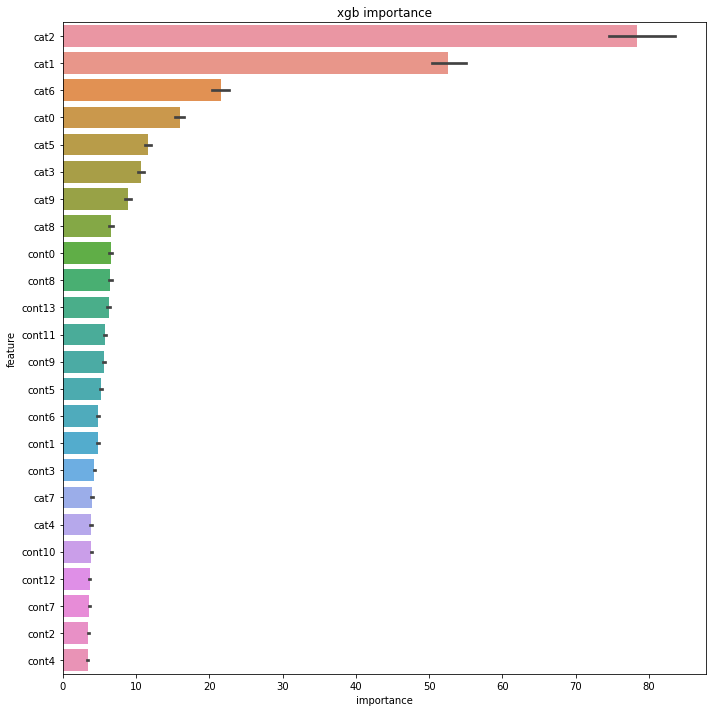

In [33]:
#plot features by importance 
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

### CatBoost

In [34]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
0:	learn: 0.8863775	test: 0.8893783	best: 0.8893783 (0)	total: 111ms	remaining: 37m 4s
200:	learn: 0.8528692	test: 0.8566592	best: 0.8566592 (200)	total: 7.38s	remaining: 12m 6s
400:	learn: 0.8465801	test: 0.8520179	best: 0.8520179 (400)	total: 14.5s	remaining: 11m 48s
600:	learn: 0.8425067	test: 0.8498319	best: 0.8498319 (600)	total: 21.6s	remaining: 11m 38s
800:	learn: 0.8388777	test: 0.8482083	best: 0.8482083 (800)	total: 28.7s	remaining: 11m 27s
1000:	learn: 0.8355746	test: 0.8471927	best: 0.8471927 (1000)	total: 35.8s	remaining: 11m 20s
1200:	learn: 0.8326353	test: 0.8464902	best: 0.8464902 (1200)	total: 42.9s	remaining: 11m 11s
1400:	learn: 0.8298263	test: 0.8459821	best: 0.8459810 (1398)	total: 50.1s	remaining: 11m 4s
1600:	learn: 0.8272136	test: 0.8456062	best: 0.8456062 (1600)	total: 57.2s	remaining: 10m 56s
1800:	learn: 0.8245490	test: 0.8453797	best: 0.8453

Model training144.385[s]
score: 0.84355
****************************************************************************************************
Seed: 42 - Fold: 4
0:	learn: 0.8870703	test: 0.8853461	best: 0.8853461 (0)	total: 42.4ms	remaining: 14m 7s
200:	learn: 0.8532222	test: 0.8543459	best: 0.8543459 (200)	total: 6.84s	remaining: 11m 13s
400:	learn: 0.8469285	test: 0.8498812	best: 0.8498812 (400)	total: 13.6s	remaining: 11m 4s
600:	learn: 0.8429642	test: 0.8477505	best: 0.8477505 (600)	total: 20.4s	remaining: 10m 59s
800:	learn: 0.8393755	test: 0.8459774	best: 0.8459774 (800)	total: 27.4s	remaining: 10m 56s
1000:	learn: 0.8361762	test: 0.8448733	best: 0.8448733 (999)	total: 34.3s	remaining: 10m 50s
1200:	learn: 0.8332748	test: 0.8442167	best: 0.8442167 (1200)	total: 41.1s	remaining: 10m 43s
1400:	learn: 0.8305134	test: 0.8436876	best: 0.8436870 (1399)	total: 48s	remaining: 10m 36s
1600:	learn: 0.8278428	test: 0.8433232	best: 0.8433232 (1600)	total: 54.9s	remaining: 10m 31s
1800:	learn:

In [35]:
score_cat

seed fold  rmse score
0   42    0    0.844796
1   42    1    0.842225
2   42    2    0.846595
3   42    3    0.843547
4   42    4    0.842263
5   42    5    0.840557
6   42    6    0.844297
7   42  oof    0.843471
8  avg  oof    0.843471

In [36]:
score_cat.loc[score_cat.fold == "oof"]

seed fold  rmse score
7   42  oof    0.843471
8  avg  oof    0.843471

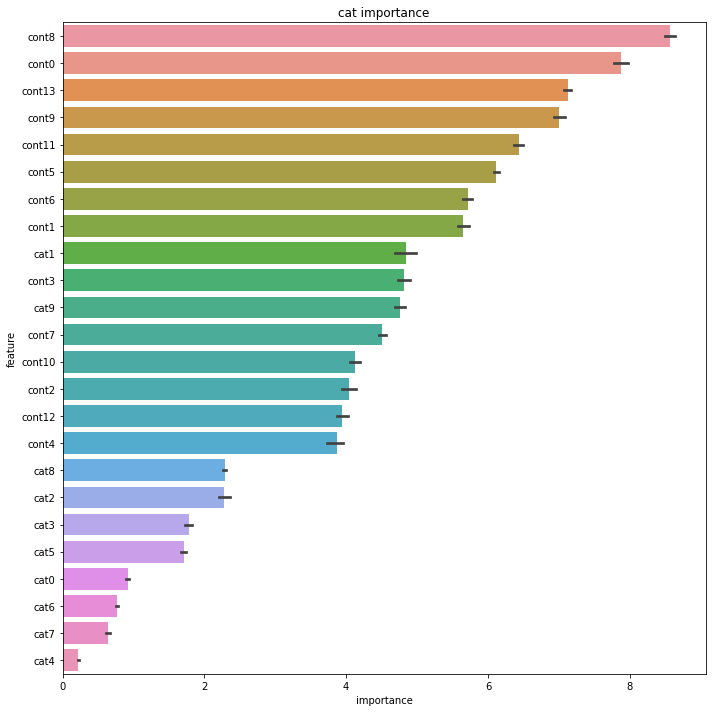

In [37]:
# Plot 
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

## Group them all together 
We need to start by looking at how the correlate the work out some weights and combine the predicted results bassed on the weights we have worked out. 

In [38]:
model_names = ["lgb", "xgb", "cat"]

In [39]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

lgb       xgb       cat
lgb  1.000000  0.992005  0.979122
xgb  0.992005  1.000000  0.985630
cat  0.979122  0.985630  1.000000

In [40]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

lgb       xgb       cat
lgb  1.000000  0.995700  0.984907
xgb  0.995700  1.000000  0.991265
cat  0.984907  0.991265  1.000000

### Simple Averaging First 

In [41]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

oof score avg: 0.84216


### Now Weighted Averaging 

In [42]:
weights = [0.5, 0.4, 0.1]

oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)

print(f"oof score weighted avg: {oof_score_wavg:.5f}")

test_pred_wavg = weights[0] * test_pred_lgb + weights[1] * test_pred_xgb + weights[2] * test_pred_cat

oof score weighted avg: 0.84199


## Finally Make our CSV for sumbmission

In [43]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_pred_wavg

sub.to_csv("tps_submission.csv", index=False)

sub.head()

id    target
0   0  7.646705
1   5  7.779046
2  15  7.599329
3  16  7.517876
4  17  7.260651